<a href="https://colab.research.google.com/github/sennayga/Tugas-Akhir/blob/main/Tugas%20Akhir%20Sentimen%20Analisis%20Model%20RF%20dan%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q Sastrawi
!pip install -q optuna
!pip install -q pytz

# **1. The Package**


In [ ]:
# Python Package
import re
import pandas as pd
import numpy as np
import nltk
import string
import joblib
import pprint
import time
import pytz
import pickle
import os

from datetime import datetime

from sklearn.base import clone
from collections import Counter

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

# NLP Library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Imbalance Data Library
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning Library
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tuning
import optuna

# Evaluation Model Package
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Visalization Library
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from wordcloud import WordCloud

# Additional Package
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", None)  # Menampilkan semua baris
# pd.set_option("display.max_columns", None) # Menampilkan semua kolom

# pd.reset_option("display.max_rows")
# pd.reset_option("display.max_columns")

# **2. Load Dataset**


In [ ]:
dakot = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Dataset/Data Berlabel Sentimen (20Okt23-20kt24).csv')

dakot.head()

conversation_id_str                      created_at sentimen  \
0         1.850000e+18  Sun Oct 20 17:47:56 +0000 2024   netral   
1         1.850000e+18  Sun Oct 20 17:32:22 +0000 2024  negatif   
2         1.850000e+18  Sun Oct 20 17:05:11 +0000 2024  negatif   
3         1.850000e+18  Sun Oct 20 17:02:56 +0000 2024  negatif   
4         1.850000e+18  Sun Oct 20 16:57:22 +0000 2024   netral   

   favorite_count                                          full_text  \
0             0.0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1             0.0              stuju kurikulum merdeka ngabisin duit   
2             0.0  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3             2.0  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4             0.0  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

         id_str image_url in_reply_to_screen_name lang               location  \
0  1.850000e+18       NaN                 CakKhum   in                    NaN   
1  1.850000e+18       NaN                     NaN   in  Yogyakarta, Indonesia   
2  1.850000e+18       NaN          Mahatmagandi69   in   Tangerang, Indonesia   
3  1.850000e+18       NaN               Otto_0967   in              Indonesia   
4  1.850000e+18       NaN            alwaysanehhh   in                    NaN   

   quote_count  reply_count  retweet_count  \
0            0            0              0   
1            0            0              0   
2            0            1              0   
3            0            0              0   
4            0            1              0   

                                           tweet_url   user_id_str  \
0  https://x.com/AhmadGa16937372/status/184805858...  1.500000e+18   
1  https://x.com/renjxjun/status/1848054667131117793  1.520000e+18   
2  https://x.com/koko_busa/status/184804782527757...  1.470000e+18   
3  https://x.com/AshbornDeSoul/status/18480472594...  1.550000e+18   
4  https://x.com/insomenyac/status/18480458587152...  1.360000e+18   

          username  
0  AhmadGa16937372  
1         renjxjun  
2        koko_busa  
3    AshbornDeSoul  
4       insomenyac

# **3. Simple Exploration of Data**


In [ ]:
dakot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10066 entries, 0 to 10065
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      10066 non-null  float64
 1   created_at               10066 non-null  object 
 2   sentimen                 10066 non-null  object 
 3   favorite_count           10065 non-null  float64
 4   full_text                10066 non-null  object 
 5   id_str                   10066 non-null  float64
 6   image_url                885 non-null    object 
 7   in_reply_to_screen_name  5918 non-null   object 
 8   lang                     10066 non-null  object 
 9   location                 5655 non-null   object 
 10  quote_count              10066 non-null  int64  
 11  reply_count              10066 non-null  int64  
 12  retweet_count            10066 non-null  int64  
 13  tweet_url                10066 non-null  object 
 14  user_id_str           

In [ ]:
print("\nJumlah data:", len(dakot))


Jumlah data: 10066


In [ ]:
print(dakot.shape)

(10066, 16)


In [ ]:
dakot.isnull().sum()

conversation_id_str           0
created_at                    0
sentimen                      0
favorite_count                1
full_text                     0
id_str                        0
image_url                  9181
in_reply_to_screen_name    4148
lang                          0
location                   4411
quote_count                   0
reply_count                   0
retweet_count                 0
tweet_url                     0
user_id_str                   0
username                      0
dtype: int64

In [ ]:
duplikat = dakot[dakot.duplicated(subset=['username', 'full_text'], keep=False)]
print("Jumlah total baris duplikat (username + full_text):", duplikat.shape[0])

unique_combinations = duplikat.drop_duplicates(subset=['username', 'full_text'])
print("Jumlah kombinasi username + full_text yang unik dan duplikat:", unique_combinations.shape[0])

Jumlah total baris duplikat (username + full_text): 18
Jumlah kombinasi username + full_text yang unik dan duplikat: 9


In [ ]:
duplikat

conversation_id_str                      created_at sentimen  \
3111         1.830000e+18  Thu Aug 29 22:25:07 +0000 2024   netral   
3162         1.830000e+18  Wed Aug 28 10:20:50 +0000 2024   netral   
4133         1.810000e+18  Wed Jul 17 09:09:11 +0000 2024   netral   
4136         1.810000e+18  Wed Jul 17 08:50:06 +0000 2024   netral   
6135         1.790000e+18  Sat May 04 04:56:18 +0000 2024  positif   
6136         1.790000e+18  Sat May 04 04:56:17 +0000 2024  positif   
6137         1.790000e+18  Sat May 04 04:43:42 +0000 2024  positif   
6138         1.790000e+18  Sat May 04 04:41:07 +0000 2024  positif   
6145         1.790000e+18  Sat May 04 01:13:35 +0000 2024  negatif   
6233         1.780000e+18  Mon Apr 29 08:56:26 +0000 2024   netral   
6236         1.780000e+18  Mon Apr 29 08:28:00 +0000 2024   netral   
6321         1.780000e+18  Sat Apr 20 02:23:21 +0000 2024  negatif   
6325         1.780000e+18  Fri Apr 19 12:15:04 +0000 2024  negatif   
6332         1.780000e+18  Fri Apr 19 07:45:33 +0000 2024  negatif   
6344         1.780000e+18  Thu Apr 18 03:34:31 +0000 2024  negatif   
6349         1.780000e+18  Wed Apr 17 15:11:09 +0000 2024  negatif   
8216         1.760000e+18  Mon Feb 19 04:20:54 +0000 2024   netral   
8247         1.760000e+18  Sat Feb 17 16:50:45 +0000 2024   netral   

      favorite_count                                          full_text  \
3111             0.0  Resmi! Inilah Panduan Pendidikan Perubahan Ikl...   
3162             0.0  Resmi! Inilah Panduan Pendidikan Perubahan Ikl...   
4133             0.0  angkatan 25 masih ada yang pakai kurikulum 13 ...   
4136             1.0  angkatan 25 masih ada yang pakai kurikulum 13 ...   
6135             0.0  Karena ikut acara #hardiknas2024 kemarin jadi ...   
6136             0.0  Di acara #hardiknas2024 kemarin salau satu yan...   
6137             0.0  Karena ikut acara #hardiknas2024 kemarin jadi ...   
6138             0.0  Di acara #hardiknas2024 kemarin salau satu yan...   
6145             0.0  P2G: SNBP 2024 Tidak Berkeadilan bagi Sekolah ...   
6233             0.0  Dalam webinar kali ini kita akan mengulik sepu...   
6236             0.0  Dalam webinar kali ini kita akan mengulik sepu...   
6321             0.0  P2G: SNBP 2024 Tidak Berkeadilan bagi Sekolah ...   
6325             0.0  P2G: SNBP 2024 Tidak Berkeadilan bagi Sekolah ...   
6332             0.0  P2G: SNBP 2024 Tidak Berkeadilan bagi Sekolah ...   
6344             0.0  Nadiem Makarim Hapuskan Beban Administrasi Gur...   
6349             0.0  Nadiem Makarim Hapuskan Beban Administrasi Gur...   
8216             0.0                                  kurikulum merdeka   
8247             0.0                                  kurikulum merdeka   

            id_str image_url in_reply_to_screen_name lang  \
3111  1.830000e+18       NaN                     NaN   in   
3162  1.830000e+18       NaN                     NaN   in   
4133  1.810000e+18       NaN                     NaN   in   
4136  1.810000e+18       NaN                     NaN   in   
6135  1.790000e+18       NaN            ShafiqPontoh   in   
6136  1.790000e+18       NaN            ShafiqPontoh   in   
6137  1.790000e+18       NaN            ShafiqPontoh   in   
6138  1.790000e+18       NaN            ShafiqPontoh   in   
6145  1.790000e+18       NaN                     NaN   in   
6233  1.780000e+18       NaN             bpmplampung   in   
6236  1.780000e+18       NaN             bpmplampung   in   
6321  1.780000e+18       NaN                     NaN   in   
6325  1.780000e+18       NaN                     NaN   in   
6332  1.780000e+18       NaN                     NaN   in   
6344  1.780000e+18       NaN                     NaN   in   
6349  1.780000e+18       NaN                     NaN   in   
8216  1.760000e+18       NaN                     NaN   in   
8247  1.760000e+18       NaN                     NaN   in   

                          location  quote_count  reply_count  retweet_count  \
3111      

In [ ]:
dakot['sentimen'].value_counts()

sentimen
netral      4457
negatif     4174
positif     1433
 negatif       1
netral         1
Name: count, dtype: int64

# **4. Preprocessing Data**



### **4.1 Temporal Feature Extraction**

In [ ]:
dakot = dakot.drop(['conversation_id_str', 'favorite_count', 'id_str',
                    'image_url', 'in_reply_to_screen_name', 'lang',
                    'location', 'quote_count', 'reply_count',
                    'retweet_count', 'user_id_str'], axis=1)
dakot1 = dakot

dakot1.head()

created_at sentimen  \
0  Sun Oct 20 17:47:56 +0000 2024   netral   
1  Sun Oct 20 17:32:22 +0000 2024  negatif   
2  Sun Oct 20 17:05:11 +0000 2024  negatif   
3  Sun Oct 20 17:02:56 +0000 2024  negatif   
4  Sun Oct 20 16:57:22 +0000 2024   netral   

                                           full_text  \
0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1              stuju kurikulum merdeka ngabisin duit   
2  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                           tweet_url         username  
0  https://x.com/AhmadGa16937372/status/184805858...  AhmadGa16937372  
1  https://x.com/renjxjun/status/1848054667131117793         renjxjun  
2  https://x.com/koko_busa/status/184804782527757...        koko_busa  
3  https://x.com/AshbornDeSoul/status/18480472594...    AshbornDeSoul  
4  https://x.com/insomenyac/status/18480458587152...       insomenyac

In [ ]:
dakot1['created_at'] = pd.to_datetime(dakot1['created_at'])

dakot1.head()

created_at sentimen  \
0 2024-10-20 17:47:56+00:00   netral   
1 2024-10-20 17:32:22+00:00  negatif   
2 2024-10-20 17:05:11+00:00  negatif   
3 2024-10-20 17:02:56+00:00  negatif   
4 2024-10-20 16:57:22+00:00   netral   

                                           full_text  \
0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1              stuju kurikulum merdeka ngabisin duit   
2  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                           tweet_url         username  
0  https://x.com/AhmadGa16937372/status/184805858...  AhmadGa16937372  
1  https://x.com/renjxjun/status/1848054667131117793         renjxjun  
2  https://x.com/koko_busa/status/184804782527757...        koko_busa  
3  https://x.com/AshbornDeSoul/status/18480472594...    AshbornDeSoul  
4  https://x.com/insomenyac/status/18480458587152...       insomenyac

In [ ]:
dakot1['day'] = dakot1['created_at'].dt.day
dakot1['month'] = dakot1['created_at'].dt.month
dakot1['year'] = dakot1['created_at'].dt.year
dakot1['time'] = dakot1['created_at'].dt.time

dakot1.head()

created_at sentimen  \
0 2024-10-20 17:47:56+00:00   netral   
1 2024-10-20 17:32:22+00:00  negatif   
2 2024-10-20 17:05:11+00:00  negatif   
3 2024-10-20 17:02:56+00:00  negatif   
4 2024-10-20 16:57:22+00:00   netral   

                                           full_text  \
0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1              stuju kurikulum merdeka ngabisin duit   
2  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                           tweet_url         username  day  \
0  https://x.com/AhmadGa16937372/status/184805858...  AhmadGa16937372   20   
1  https://x.com/renjxjun/status/1848054667131117793         renjxjun   20   
2  https://x.com/koko_busa/status/184804782527757...        koko_busa   20   
3  https://x.com/AshbornDeSoul/status/18480472594...    AshbornDeSoul   20   
4  https://x.com/insomenyac/status/18480458587152...       insomenyac   20   

   month  year      time  
0     10  2024  17:47:56  
1     10  2024  17:32:22  
2     10  2024  17:05:11  
3     10  2024  17:02:56  
4     10  2024  16:57:22

In [ ]:
dakot1['date'] = dakot1['created_at'].dt.date

dakot1.head()

created_at sentimen  \
0 2024-10-20 17:47:56+00:00   netral   
1 2024-10-20 17:32:22+00:00  negatif   
2 2024-10-20 17:05:11+00:00  negatif   
3 2024-10-20 17:02:56+00:00  negatif   
4 2024-10-20 16:57:22+00:00   netral   

                                           full_text  \
0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1              stuju kurikulum merdeka ngabisin duit   
2  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                           tweet_url         username  day  \
0  https://x.com/AhmadGa16937372/status/184805858...  AhmadGa16937372   20   
1  https://x.com/renjxjun/status/1848054667131117793         renjxjun   20   
2  https://x.com/koko_busa/status/184804782527757...        koko_busa   20   
3  https://x.com/AshbornDeSoul/status/18480472594...    AshbornDeSoul   20   
4  https://x.com/insomenyac/status/18480458587152...       insomenyac   20   

   month  year      time        date  
0     10  2024  17:47:56  2024-10-20  
1     10  2024  17:32:22  2024-10-20  
2     10  2024  17:05:11  2024-10-20  
3     10  2024  17:02:56  2024-10-20  
4     10  2024  16:57:22  2024-10-20

In [ ]:
dakot1 = dakot1.drop('created_at', axis=1)
new_order = ['date', 'day', 'month', 'year', 'time'] + [col for col in dakot1.columns if col not in ['date', 'day', 'month', 'year', 'time']]
dakot1 = dakot1[new_order]

dakot1.head()

date  day  month  year      time sentimen  \
0  2024-10-20   20     10  2024  17:47:56   netral   
1  2024-10-20   20     10  2024  17:32:22  negatif   
2  2024-10-20   20     10  2024  17:05:11  negatif   
3  2024-10-20   20     10  2024  17:02:56  negatif   
4  2024-10-20   20     10  2024  16:57:22   netral   

                                           full_text  \
0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1              stuju kurikulum merdeka ngabisin duit   
2  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                           tweet_url         username  
0  https://x.com/AhmadGa16937372/status/184805858...  AhmadGa16937372  
1  https://x.com/renjxjun/status/1848054667131117793         renjxjun  
2  https://x.com/koko_busa/status/184804782527757...        koko_busa  
3  https://x.com/AshbornDeSoul/status/18480472594...    AshbornDeSoul  
4  https://x.com/insomenyac/status/18480458587152...       insomenyac

In [ ]:
dakot1['year'].unique()

array([2024, 2023], dtype=int32)

## **4.2 Duplicate Handling**

In [ ]:
# Hapus duplikat dari seluruh data, simpan satu baris per kombinasi
dakot1 = dakot.drop_duplicates(subset=['username', 'full_text'], keep='first')

print("Jumlah data awal sebelum menghapus duplikat:", len(dakot))
print("Jumlah data setelah menghapus duplikat (menyimpan satu):", dakot1.shape[0])

Jumlah data awal sebelum menghapus duplikat: 10066
Jumlah data setelah menghapus duplikat (menyimpan satu): 10057


## **4.3 Label Handling**

In [ ]:
dakot1['sentimen'].value_counts()

sentimen
netral      4453
negatif     4171
positif     1431
 negatif       1
netral         1
Name: count, dtype: int64

In [ ]:
dakot1['sentimen'] = dakot1['sentimen'].str.strip()
sentimen_counts = dakot1['sentimen'].value_counts()
total_data_count = len(dakot1)

print(sentimen_counts, '\n')
print(f'Total data: {total_data_count}')

sentimen
netral     4454
negatif    4172
positif    1431
Name: count, dtype: int64 

Total data: 10057


## **4.4 Text Normalization**

In [ ]:
replacement_dict = {
  "kumer": "kurikulum merdeka",
  "kurmer": "kurikulum merdeka",
  "ruwet": "ribet",
  "karep": "terserah",
  "dewe": "sendiri",
  "pancen": "memang",
  "iki": "ini",
  "hoong": "bohong",
  "utk": "untuk",
  "ga": "tidak",
  "gak": "tidak",
  "gw": "saya",
  "gw": "saya",
  "ttg": "tentang",
  "krn": "karena",
  "km": "kamu",
  "jg": "juga",
  "ing": "inggris",
  "b": "bahasa",
  "dr": "dari",
  "dg":"dengan",
  "dgn": "dengan",
  "mtk": "matematika",
  "pljrn": "pelajaran",
  "emg": "memang",
  "yg": "yang",
  "knp": "kenapa",
  "tugasna": "tugasnya",
  "tpi": "tapi",
  "tp": "tapi",
  "slalu": "selalu",
  "ketawan": "ketahuan",
  "skrng": "sekarang",
  "skrg": "sekarang",
  "skolah": "sekolah",
  "skolahmu": "sekolahmu",
  "skola": "sekolah",
  "sekola": "sekolah",
  "akt": "angkatan",
  "drastis": "derastis",
  "pisika": "fisika",
  "sepertiny": "sepertinya",
  "camaba": "calon mahasiswa baru",
  "duit": "uang",
  "tbtb": "tiba tiba",
  "jd": "jadi",
  "jkw": "jokowi",
  "pemerinyah": "pemerintah",
  "thx": "terima kasih",
  "bgus": "bagus",
  "eskul": "ekstrakurikuler",
  "ekskul": "ekstrakurikuler",
  "bgt": "banget",
  "kpd": "kepada",
  "univ": "universitas",
  "mencantolkan": "menggantungkan",
  "kyk": "seperti",
  "gw": "saya",
  "gue": "saya",
  "gua": "saya",
  "nerima": "terima",
  "blom": "belum",
  "blm": "belum",
  "lgpl": "lagipula",
  "jaman": "zaman",
  "jlek": "jelek",
  "linjur": "lintas jurusan",
  "sm": "sama",
  "pake": "pakai",
  "kk": "kakak",
  "cayang": "sayang",
  "kerad": "keras",
  "kaka": "kakak",
  "bgtu": "begitu",
  "gjd": "tidak jadi",
  "tydac": "tidak",
  "gj": "tidak jelas",
  "gaje": "tidak jelas",
  "geje": "tidak jelas",
  "anj": "anjing",
  "ajg": "anjing",
  "anjg": "anjing",
  "bgst": "bangsat",
  "kntl": "kontol",
  "dmn": "dimana",
  "akt": "angkatan",
  "ortu": "orang tua",
  "bgt": "banget",
  "pling": "paling",
  "kmrin": "kemarin",
  "pda": "pada",
  "bgt": "banget",
  "ad": "ada",
  "gugel": "google",
  "kur": "kurikulum",
  "ap": "apa",
  "bntr": "sebentar",
  "blio": "beliau",
  "smgt": "semangat",
  "smua": "semua",
  "krna": "karena",
  "sbg": "sebagai",
  "dikdas": "pendidikan dasar",
  "esempe": "smp",
  "esema": "sma",
  "esde": "sd",
  "jwb": "jawab",
  "tnya": "tanya",
  "kgk": "tidak",
  "sy": "saya",
  "ngk": "tidak",
  "mw": "mau",
  "blng":"bilang",
  "ngri": "negeri",
  "mentri": "menteri",
  "kepsek": "kepala sekolah",
  "ngga": "tidak",
  "indo": "indonesia",
  "kemendikbud": "kemendikbudristek",
  "kemdikbud": "kemendikbudristek",
  "orba": "orde baru",
  "gadget": "gawai",
  "gatget": "gawai",
  "managemen": "manajemen",
  "management": "manajemen",
  "kurnas": "kurikulum nasional",
  "pov": "sudut pandang",
  "eng": "inggris",
  "bpk": "bapak",
  "sdgkan": "sedangkan",
  "dk": "tidak",
  "bgini": "begini",
  "ancur": "hancur",
  "ancurnya": "hancurnya",
  "ancuran": "hancuran",
  "latsol": "latihan soal",
  "swbebasnya": "sebebasnya",
  "gx": "tidak",
  "gk": "tidak",
  "matpel": "mata pelajaran",
  "bngs*tttt": "bangsat",
  "tk": "taman kanak kanak",
  "dlu": "dulu",
  "gjls": "tidak jelas",
  "wlwpun": "walapun",
  "bobrok": "buruk",
  "sajam": "senjata tajam",
  "wakasek": "wakil kepala sekolah",
  "kurmed": "kurikulum merdeka",
  "ppt": "power point text",
  "mkin": "makin",
  "skli": "sekali",
  "skli": "sekali",
  "fak": "fuck",
  "gabikin": "tidak buat",
  "ampe": "sampai",
  "membungkan": "membungkam",
  "ara": "arah",
  "dll": "dan lain lain",
  "gnti": "ganti",
  "cape": "lelah",
  "capek": "lelah",
  "onlen": "online",
  "drpd": "dari pada",
  "walkel": "wali kelas",
  "negri": "negeri",
  "fu*k": "fuck",
  "anjink": "anjing",
  "jink": "anjing",
  "lom": "belum",
  "kwbwh": "ke bawah",
  "kureng": "kurang",
  "ril": "nyata",
  "rill": "nyata",
  "manta": "mantap",
  "mmpu": "mampu",
  "trnformasi": "transformasi",
  "hepi": "bahagia",
  "happy": "bahagia",
  "klompk": "kelompok",
  "bimble": "bimbingan belajar",
  "bimbel": "bimbingan belajar",
  "karna": "karena",
  "gada": "tidak ada",
  "kurdek": "kurikulum merdeka",
  "thn": "tahun",
  "sekula": "sekolah",
  "adkel": "adik kelas",
  "sukak": "suka",
  "duit": "uang",
  "kurmed": "kurikulum merdeka",
  "lo": "kamu",
  "lu": "kamu",
  "kurleb": "kurang lebih",
  "apus": "hapus",
  "diapus": "dihapus",
  "mnrt": "menurut",
  "mumet": "pusing",
  "kagak": "tidak",
  "kaga": "tidak",
  "sono": "sana",
  "tdk": "tidak",
  "puyeng": "pusing",
  "kerkom": "kerja kelompok",
  "english": "inggris",
  "kbnykn": "kebanyakan",
  "moga": "semoga",
  "kalo": "kalau",
  "fakyu": "fuck you",
  "taik": "tai",
  "tlg": "tolong",
  "boljug": "boleh juga",
  "gajelas": "tidak jelas",
  "mapel": "mata pelajaran",
  "ngga": "tidak",
  "bnran": "benaran",
  "gaenak": "tidak enak",
  "gaenak": "tidak enak",
  "sebenernya": "sebenarnya",
  "sebenerny": "sebenarnya",
  "gblk": "bodoh",
  "ama": "sama",
  "kurtilas": "k13",
  "math": "matematika",
  "ditaroh": "diletakkan",
  "modar": "mati",
  "ln": "luar negeri",
  "ilangin": "hilangkan",
  "blg": "bilang",
  "kga": "tidak",
  "gaada": "tidak ada",
  "gacocok": "tidak cocok",
  "kacaw": "kacau",
  "kur13": "k13",
  "sklh": "sekolah",
  "ngajarin": "mengajarkan",
  "selamet": "selamat",
  "bobroknya": "rusaknya",
  "gasalah": "tidak salah",
  "sulid": "sulit",
  "ngak": "tidak",
  "cmn": "cuman",
  "gmn": "bagaimana",
  "no": "tidak",
  "yes": "iya",
  "bundir": "bunuh diri",
  "scr": "secara",
  "hapalan": "hafalan",
  "hapal": "hafal",
  "goblog": "goblok",
  "sbnrnya": "sebenarnya",
  "bnr": "benar",
  "g": "tidak",
  "nm": "nadiem makarim",
  "org": "orang",
  "tlol": "tolol",
  "sistim": "sistem",
  "terngga": "tertidak",
  "anjeng": "anjing",
  "tuker": "tukar",
  "tukeran": "tukaran",
  "infra": "infrastruktur",
  "niru": "tiru",
  "mgkn": "mungkin",
  "stuju": "sepakat",
  "itung": "hitung",
  "amburadul": "berantakan",
  "blajar": "belajar",
  "kebablasan": "kelewatan",
  "ngabisin": "menghabiskan",
  "beneran": "benaran",
  "kebeneran": "kebenaran",
  "setuju": "sepakat",
  "udah": "sudah",
  "udh": "sudah",
  "bikin": "membuat",
  "bener": "benar",
  "gimana": "bagaimana",
  "nggak": "tidak",
  "klo": "kalau",
  "kayak": "seperti",
  "sampe": "sampai",
  "ngajar": "mengajar",
  "biar": "agar",
  "tetep": "tetap",
  "kalo": "kalau",
  "cuman": "hanya",
  "ga ": "tidak",
  " ga": "tidak",
  " gak": "tidak",
  "gak ": "tidak",
  "kls": "kelas",
  "mending": "lebih baik",
  "diajarin": "diajarkan",
  "ak": "saya",
  "ngerti": "mengerti",
  "project": "proyek",
  "kayaknya": "sepertinya",
  "temen": "teman",
  "milih": "memilih",
  " gw": "saya",
  "gw ": "saya",
  "gatau": "tidak tahu",
  "bs": "dapat",
  "bisa": "dapat",
  "engga": "tidak",
  "gue ": "saya",
  " gue": "saya",
  "ngerasain": "merasakan",
  "jelek": "buruk",
  "jlk": "buruk",
  "dikasih": "diberi",
  "kasih": "beri",
  "kasihkan": "berikan",
  "kena": "berikan",
  "dikit": "sedikit",
  "sdh": "sudah",
  "nanya": "bertanya",
  "dlm": "dalam",
  "adek": "adik",
  "nerapin": "menerapkan",
  "pinter": "pintar",
  "jdi": "jadi",
  "belom": "belum",
  "hrs": "harus",
  "gabisa": "tidak bisa",
  "byk": "banyak",
  "lbh": "lebih",
  "msh": "masih",
  "jk": "jusuf kalla",
  "kaget": "terkejut",
  "ngapain": "sedang apa",
  "dpt": "dapat",
  "dapet": "dapat",
  "pengen": "ingin",
  "pingin": "ingin",
  "kayanya": "kelihatannya",
  "mikir": "berpikir",
  "abis": "habis",
  "nyari": "mencari",
  "ngeluh": "mengeluh",
  "full": "penuh",
  "cepet": "cepat",
  "jgn": "jangan",
  "ngasih": "memberi",
  "gampang": "mudah",
  "anak²": "anak anak",
  "dibikin": "dibuat",
  "nulis": "menulis",
  "gua ": "saya",
  " gua": "saya",
  "bayangin": "bayangkan",
  "taun": "tahun",
  "uda": "sudah",
  "ngerasa": "merasa",
  "mentri ": "menteri",
  " mentri": "menteri",
  "sman": "sma",
  "make": "pakai",
  "bnyk": "banyak",
  "masi": "masih",
  "denger": "dengar",
  "kudu": "harus",
  "kurmer ": "kurikulum merdeka",
  "njir": "anjir",
  "min": "minimum",
  "text": "teks",
  "nyalahin": "menyalahkan",
  "bbrp": "beberapa",
  "basic": "basik",
  "bullying": "perundungan",
  "sorry": "maaf",
  "bego": "bodoh",
  "goblok": "bodoh",
  "ngeliat": "melihat",
  "liat": "lihat",
  "orangtua": "orang tua",
  "ngobrol": "berbicara",
  "nambah": "tambah",
  "kelar": "selesai",
  "ngikutin": "mengikuti",
  "bocah": "anak",
  " indo": "indonesia",
  "indo ": "indonesia",
  "you": "kamu",
  "lu ": "kamu",
  " lu": "kamu",
  "karna ": "karena",
  " karna": "karena",
  "skrg ": "sekarang",
  " skrg": "sekarang",
  "setres": "stres",
  "stress": "stres",
  "inget": "ingat",
  "sempet": "sempat",
  "raport": "rapor",
  "rapot": "rapor",
  " raport": "rapor",
  "raport ": "rapor",
  "ngomong": "berbicara",
  "maksut": "maksud",
  "ngejar": "mengejar",
  "bs": "bisa",
  "gegara": "gara gara",
  "disalahin": "disalahkan",
  "malem": "malam",
  "setauku": "setahuku",
  "pantes": "pantas",
  "gapapa": "tidak apa",
  "kab": "kabupaten",
  " km": "kamu",
  "km ": "kamu",
  "ponakan": "keponakan",
  "thinking": "berpikir",
  "gede": "besar",
  "mikirin": "memikirkan",
  "nonton": "menonton",
  "based": "berdasarkan",
  "dijadiin": "dijadikan",
  "mrk": "mereka",
  "training": "pelatihan",
  "alhasil": "akibatnya",
  "tmn": "teman",
  "alhasil": "akibatnya",
  "mapel ": "mata pelajaran",
  " mapel": "mata pelajaran",
  "bangett ": "banget",
  "gamau ": "tidak mau",
  "outputnya ": "keluarannya",
  " pake": "pakai",
  "pake ": "pakai",
  "ngurusi": "mengurusi",
  "kerasa": "merasa",
  "emak": "ibu",
  "real": "nyata",
  "mesti": "harus",
  "kesel": "kesal",
  "guru²": "guru",
  "masukin": "memasukkan",
  "gaa": "tidak",
  "problem": "masalah",
  "ngeluarin": "mengeluarkan",
  "ngaruh": "berpengaruh",
  "minusnya": "kurangnya",
  "kompleks": "komplek",
  "terimakasih": "terima kasih",
  "diajari": "diajarkan",
  "bljr": "belajar",
  "reply": "balas",
  "nunggu": "menunggu",
  "ngajarnya": "mengajarnya",
  "good": "baik",
  "ank": "anak",
  "smpe": "sampai",
  "house": "rumah",
  "knp ": "kenapa",
  " knp": "kenapa",
  "gmna": "bagaimana",
  "kyknya": "sepertinya",
  "naikin": "menaikan",
  " ortu": "orang tua",
  "ortu ": "orang tua",
  "jaman ": "zaman",
  " jaman": "zaman",
  "nentuin": "menentukan",
  "bkin": "buat",
  "mreka": "mereka",
  "ngambil": "mengambil",
  "school": "sekolah",
  "sy ": "saya",
  " sy": "saya",
  "ngaco": "melantur",
  "lgsg": "langsung",
  "ok": "oke",
  "yaallah": "ya allah",
  "pke": "pakai",
  "gausah": "tidak usah",
  "dikasi": "diberi",
  "gpp": "tidak apa",
  "bum": "belum",
  "grgr": "gara gara",
  "diem": "diam",
  "dek": "adik",
  "pakek": "pakai",
  "ane": "saya",
  "dirubah": "diubah",
  "ngejelasin": "menjelaskan",
  "bnyak": "banyak",
  "sharing": "berbagi",
  "kau": "kamu",
  "ekskul": "ekstrakurikuler",
  "ngga": "tidak",
  "day": "hari",
  "nyampe": "sampai",
  "relate": "berkaitan",
  "elit": "elite",
  "yaudah": "ya sudah",
  "nangkep": "menangkap",
  "hrus": "harus",
  "ngisi": "mengisi",
  "muter": "putar",
  "class": "kelas",
  "skr": "sekarang",
  "adeknya": "adiknya",
  "emaknya": "ibunya",
  "nurut": "menurut",
  "bener²": "benar benar",
  "ngurus": "mengurus",
  "gaboleh": "tidak boleh",
  "jt": "juta",
  "kt": "kita",
  "bodo": "bodoh",
  "pelajarin": "mempelajari",
  "ngomongin": "membicarakan",
  "benerin": "membenarkan",
  "nguras": "menguras",
  "nnti": "nanti",
  "sebel": "nanti",
  "deket": "dekat",
  "terapin": "menerapkan",
  "ade": "adik",
  "thank": "terima kasih",
  "bandingin": "membandingkan",
  "gapernah": "tidak pernah",
  "jdnya": "jadinya",
  "nyambung": "sambung",
  "sgt": "segitu",
  "gk ": "tidak",
  " gk": "tidak",
  "nyuruh": "suruh",
  "extra": "ekstra",
  "pakenya": "pakainya",
  "bing": "bahasa inggris",
  "gapaham": "tidak paham",
  "rb": "ribu",
  "rame": "ramai",
  "diliat": "dilihat",
  "kerjain": "kerjakan",
  "pj": "penanggung jawab",
  "kec": "kecamatan",
  "kec": "kecamatan",
  "fak ": "fuck",
  " fak": "fuck",
  "emg ": "memang",
  " emg": "memang",
  "kasi": "beri",
  "uprak ": "ujian praktek",
  " uprak": "ujian praktek",
  "samsek": "sama sekali",
  "bru": "baru",
  "bjirrr": "bjir",
  "sem": "semester",
  "darimana": "dari mana",
  "jatim ": "jawa timur",
  " jatim": "jawa timur",
  "twit": "tweet",
  "beneran": "benaran",
  "ngasi": "memberi",
  " kurnas": "kurikulum nasional",
  "kurnas ": "kurikulum nasional",
  "nyusun": "menyusun",
  "ndak": "tidak",
  "nyokap": "ibu",
  "mama": "ibu",
  "kurikulum ": "kurikulum",
  " kurikulum": "kurikulum",
  "kepake": "terpakai",
  "bln": "bulan",
  "just": "hanya",
  " gajelas": "tidak jelas",
  "gajelas ": "tidak jelas",
  " kumer": "kurikulum merdeka",
  "kumer ": "kurikulum merdeka",
  "nyicil": "mencicil",
  "musti": "harus",
  "bner": "benar",
  "numpuk": "bertumpuk",
  "best": "terbaik",
  "mtk ": "matematika",
  " mtk": "matematika",
  "tbh": "sejujurnya",
  " jateng": "jawa tengah",
  "jateng ": "jawa tengah",
  " gaada": "tidak ada",
  "gaada ": "tidak ada",
  "nambahin ": "menambahkan",
  "sblm ": "sebelum",
  "akuu ": "saya",
  "jadiin ": "menjadikan",
  "merdekaa ": "merdeka",
  "adain ": "mengadakan",
  "kur ": "kurikulum",
  " kur": "kurikulum",
  "yes ": "iya",
  " yes": "iya",
  "disuru": "disuruh",
  "bosen": "bosan",
  "hoax": "hoaks",
  "kerkel": "kerja kelompok",
  "sosmed": "media sosial",
  "mabok": "mabuk",
  "maksain": "memaksakan",
  "tau": "tahu",
  "bu": "ibu",
  "worth it": "sangat layak",
  "skill": "keterampilan",
  "bkn": "bukan",
  "sdn": "sd",
  "2010an": "2010",
  "2000an": "2000",
  "1990an": "1990",
  "aamiin": "amin",
  "aamin": "amin",
  "aaminn": "amin",
  "about": "tentang",
  "all": "semua",
  "adaa": "ada",
  "adaaa": "ada",
  "adalagi": "ada lagi",
  "adl": "adalah",
  "adlh": "adalah",
  "adm": "administrasi",
  "adopt": "adopsi",
  "after": "sebelum",
  "ahlak": "akhlak",
  "akhlaq": "akhlak",
  "aktifitas": "aktivitas",
  "ngerjain": "mengerjakan",
  "bebasss": "bebas",
  "bebass": "bebas",
  "bebasinn": "membebaskan",
  "bebasin": "membebaskan",
  "gtu": "gitu",
  "iyaa": "iya",
  "jkt": "jakarta",
  "jir": "njir",
  "jelasin": "jelaskan",
  "ngitung": "menghitung",
  "ngitungnya": "menghitungnya",
  "urusin": "urusi",
  "nolak": "tolak",
  "prof": "profesor",
  "projek": "proyek",
  "smkn": "smk",
  "smpn": "smp",
  "temennya": "temannya",
  "temenku": "temanku",
}

In [ ]:
def replace_words(text, replacement_dict):
    text = text.lower()

    # Tokenisasi berdasarkan kata utuh (tanpa mecah URL atau karakter khusus)
    words = text.split()

    # Ganti berdasarkan dict
    normalized_words = [replacement_dict.get(word, word) for word in words]

    # Gabungkan kembali
    return ' '.join(normalized_words)

dakot1['fix_text'] = dakot1['full_text'].apply(lambda x: replace_words(str(x), replacement_dict))
dakot_replaced = dakot1

dakot_replaced[['full_text', 'fix_text']].head()

full_text  \
0  @CakKhum @nadiemmakarim Kelas X?? Loh model be...   
1              stuju kurikulum merdeka ngabisin duit   
2  @Mahatmagandi69 @kopididid Maaf kak saya bener...   
3  @Otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                            fix_text  
0  @cakkhum @nadiemmakarim kelas x?? loh model be...  
1        sepakat kurikulum merdeka menghabiskan uang  
2  @mahatmagandi69 @kopididid maaf kak saya benar...  
3  @otto_0967 @nadiemmakarim inilah gambaran dari...  
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...

## **4.5 Text Cleaning-1**

In [ ]:
def clean_text_1(text):
    # Gabungkan bagian URL yang dipisah dengan spasi jadi satu dulu (biar bisa dihapus)
    text = re.sub(r'(https?)\s*:\s*/\s*/\s*\S+', '', text)  # hapus URL bentuk https : / / t.co/xyz
    text = re.sub(r'www\s*\.\s*\S+', '', text)              # hapus www . domain .com

    # Hapus URL normal juga
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Hapus mention, termasuk "@ username"
    text = re.sub(r'@\s*\w+', '', text)

    # Hapus hashtag
    text = re.sub(r'#\w+', '', text)

    # Hapus karakter spesial & angka non-4-digit
    text = re.sub(r'[^\w\s]|(?<!\d)\d{1,3}(?!\d)|(?<!\d)\d{5,}(?!\d)', ' ', text)

    # Lowercase
    text = text.lower()

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

dakot_replaced['cleaned_text_1'] = dakot_replaced['fix_text'].apply(clean_text_1)
dakot_cleaned = dakot_replaced

dakot_cleaned[['fix_text', 'cleaned_text_1']].head()

fix_text  \
0  @cakkhum @nadiemmakarim kelas x?? loh model be...   
1        sepakat kurikulum merdeka menghabiskan uang   
2  @mahatmagandi69 @kopididid maaf kak saya benar...   
3  @otto_0967 @nadiemmakarim inilah gambaran dari...   
4  @alwaysanehhh nah rata tuh tapi kurikulum merd...   

                                      cleaned_text_1  
0  kelas x loh model begini kok dapat lulus sd za...  
1        sepakat kurikulum merdeka menghabiskan uang  
2  maaf kak saya benaran tidak tahu tapi kebijaka...  
3  inilah gambaran dari perubahan kurikulum merde...  
4  nah rata tuh tapi kurikulum merdeka tidak ada ...

## **4.6 Stopword**

In [ ]:
stop_words = set(stopwords.words('indonesian'))

In [ ]:
exceptions = {"k13", "p5", "3t", "g30s", "ktsp"}

additional_words_to_remove = {
    "tuh", "loh", "kok", "ya", "aja", "nya", "sih", "k", "emang", "hasil", "p", "gimana", "tau", "gitu", "kak", "gini", "nih", "deh", "dah", "si",
    "iya", "yaa", "kek",  "ku", "mah", "kah", "eh", "yg", "gara", "kali", "lg", "tu",  "an",  "tu", "trs", "tu", "gt",  "ni", "mulu", "wkwk", "btw", "d", "wkwkwk",
    "tp", "trus", "nder", "bs", "s", "pd", "kanak", "i", "yah", "kl", "a", "in", "apanya", "yuk", "pdhl", "guys", "n", "w", "ttp", "bang", "pls", "lho", "oh", "jd",
    "cmiiw", "halo", "m", "bawa", "the", "mari", "hah", "ka", "dri", "spt", "to", "t",  "plis", "bgt", "kmrn", "cm", "gonta", "y", "emng",  "ri",  "re", "re", "krn",
    "aj", "hehe", "c", "yh", "this", "sok", "pisa", "z", "this", "sok", "sok", "bngt", "ra", "ntar", "b", "is", "kakk", "g", "kakk", "no", "bro", "pk", "noh", "but",
    "yak", "buset", "wkwkw", "woy", "hahaha", "or", "ib", "yaaa", "sch", "dh", "om", "dn", "dsb", "dst", "imo", "ayo", "lha", "mu", "sj", "vs", "ki", "ko", "of", "pliss",
    "bgtt", "ngang", "cont", "ngong", "u", "on", "hai", "mbak", "and", "lt", "like", "at", "aduh", "h", "be", "my", "al", "haha", "mo", "ah", "hmmm", "klik", "dl", "up",
    "fyi", "by", "so", "ny", "mgmp", "kahh", "haloo", "gituu", "apaa", "man", "wkwkwkwk", "sihh", "man", "loss", "sii", "nyaa", "dr", "nge", "kn", "moots", "ituu", "jugaa",
    "jp","ato", "inii", "jp", "cuy", "uu", "ter", "klu", "pa", "cc", "ih", "utk", "ha", "weh", "ohh", "me", "wow", "say", "bgttt", "what", "teh", "woi", "ky", "mmg", "oalah",
    "know", "lgi", "kyk", "dm", "tl", "ceunah", "_", "hadeh", "bet", "hehehe", "ama", "as", "krna", "napa", "dahlah", "hi", "tuhh", "kaa", "emg", "us", "do", "kh", "f", "we",
    "huft", "duh", "lahh", "apasih", "pny", "wahh", "guyss", "iyaaa", "jga", "go", "apa²", "tpi", "slh", "ajah", "msih", "boro", "krg", "hmm", "akuu", "nihh", "right",
    "blas", "wkwkwkw", "gaes", "knpa", "for", "now", "dll", "amp", "ya", "aja", "banget", "nya", "sih", "k", "emang", "hasil", "p", "gimana", "tau", "gitu", "kak", "gini", "nih",
    "deh", "dah", "si", "yaa", "kek",  "ku", "mah", "kah", "eh", "yg", "gara", "kali", "lg", "tu",  "an",  "tu", "trs", "tu", "gt",  "ni", "mulu", "wkwk", "btw", "d", "wkwkwk",
    "tp", "trus", "nder", "bs", "s", "pd", "kanak", "i", "yah", "kl", "a", "in", "apanya", "yuk", "pdhl", "guys", "n", "w", "ttp", "bang", "pls", "lho", "oh", "jd", "cmiiw", "halo",
    "m", "bawa", "the", "mari", "hah", "ka", "dri", "spt", "to", "t",  "plis", "bgt", "kmrn", "cm", "gonta", "y", "emng",  "ri",  "re", "re", "krn", "aj", "hehe", "c", "yh", "this",
    "sok", "pisa", "z", "this", "sok", "sok", "bngt", "ra", "ntar", "b", "is", "kakk", "g", "kakk", "no", "bro", "pk", "noh", "but", "yak", "buset", "wkwkw", "woy", "hahaha", "or",
    "ib", "yaaa", "sch", "dh", "om", "dn", "dsb", "dst", "imo", "ayo", "lha", "mu", "sj", "vs", "ki", "ko", "of", "pliss", "bgtt", "ngang", "cont", "ngong", "u", "on", "hai", "mbak",
    "and", "lt", "like", "at", "aduh", "h", "be", "my", "al", "haha", "mo", "ah", "hmmm", "klik", "dl", "up", "fyi", "by", "so", "ny", "mgmp", "kahh", "haloo", "gituu", "apaa", "man",
    "wkwkwkwk", "sihh", "man", "loss", "sii", "nyaa", "dr", "nge", "kn", "moots", "ituu", "jugaa", "jp","ato", "inii", "jp", "cuy", "uu", "ter", "klu", "pa", "cc", "ih", "utk", "ha",
    "weh", "ohh", "me", "wow", "say", "bgttt", "what", "teh", "woi", "ky", "mmg", "oalah", "know", "lgi", "kyk", "dm", "tl", "ceunah", "_", "hadeh", "bet", "hehehe", "ama", "as", "krna",
    "napa", "dahlah", "hi", "tuhh", "kaa", "emg", "us", "do", "kh", "f", "we", "huft", "duh", "lahh", "all", "apasih", "pny", "wahh", "guyss", "iyaaa", "jga", "go", "apa²", "tpi", "slh",
    "ajah", "msih", "boro", "krg", "hmm", "akuu", "nihh", "right", "blas", "wkwkwkw", "gaes", "knpa", "for", "now", "hag", "hahah", "hahahah", "hahahaha", "hahahahah", "hahahahahah",
    "hahahahahahahhahahahahaha", "hahahahhahahaha", "hahahha", "hahahhahalucu", "hahahhha", "hahh", "hahhaha", "hahohhohoogohho", "haii", "haiii", "hall", "hallo", "halloo", "hallooo",
    "halloww", "haloii", "haloooooo", "hadeuhhh", "hadeuhh", "hadeuh", "hadehhhh", "hadehhh", "hadehh", "hadeeehh", "hadeeeeeh", "hadapin", "hadah", "hadaeehh", "hadaaaaah", "haahhh",
    "haaahhh", "haaaai", "haaa", "gymnasium", "gws", "gwejh", "gwej", "gwehj", "gwehh", "gweh", "gweehh", "gwe", "gwa", "guyssss", "guysss", "guw", "guuoobloook", "gusy", "gusti", "guss",
    "gus", "hadeuhhh", "hadeuhh", "hadeuh", "hadehhhh", "hadehhh", "hadehh", "hadeeehh", "hadeeeeeh", "hadaeehh", "hadaaaaah", "huhuu", "huhuhuu", "huhuhuhu", "huhuhu", "huhu", "huhh",
    "huhft", "huh", "huftttt", "huftt", "hufff", "hueueue", "huehuehuehuehue", "huehuehue", "huaaaa", "huaaa", "huaa", "hua", "hssil", "hsl", "hsil", "hsiehdkdb", "hshshss", "hut", "husss",
    "hush", "ig", "ifu", "if", "ieu", "iyye", "iyhh", "iyh", "iyasi", "iyas", "iyakahhh", "iyah", "iyadeh", "iyaah", "iyaaaaaa", "iyaaaa", "xixixi", "xixixix", "xnc", "yaaaa", "yaaaaa",
    "yaaahh", "yaaallah", "yaaasama", "yaah", "yaahhh", "yaallahhhhh", "yaampun", "yaangfun", "yaapa", "yabelajar", "yaelah", "yagesya", "yagesyak", "yagusti", "yahahah", "yahahahah",
    "yahh", "yahhh", "yahud", "yakan", "yakk", "yakkk", "yamg", "yangg", "yankk", "yap", "yapp", "yash", "yashh", "yatuhan", "yaudahlah", "yaudeh", "yaya", "yeaaah", "yeah", "yeayy", "yee",
    "yeeyy", "yeh", "yekan", "yel", "yesman", "yess", "yessss", "yesssssss", "yoi", "yok", "yokkk", "yoo", "²", "¼", "ᗒᗣᗕ", "ー", "ㅠㅠ", ", ", "𝑺𝒆𝒃𝒖𝒂𝒉", "𝑼𝒕𝒂𝒔", "itunya", "itupun", "ituuu",
    "inih", "inihh", "inii", "iniiii", "inikan", "inima", "inimah", "inipun", "initehhh", "inituh", "injak", "maunya", "maut", "mauu", "maw", "maww", "nngis", "nngung", "nnt", "nnya", "nnyaa",
    "np", "nri", "nrnia", "ntah", "ntahlah", "ntas", "nthlah", "nti", "ntn", "ntr", "ntt", "ntu", "ntuh", "ntuk", "o", "oalaa", "oalaah", "oalaahh", "oalahh", "oalahhh", "og", "ogah", "ohhh", "ohhhh",
    "ohhhhh", "ohhini", "ohiya", "ohya", "oi", "oia", "oii", "oiya", "oiyaa", "oiyaa", "oooh", "ooohhh", "oot", "oowh", "otw", "ou", "oun", "our", "out", "pliiiiisss", "plishh", "plisss", "plisssss",
    "plss", "plsss", "suda", "sudaahh", "sudahhhh", "sudahi", "sudahkan", "sudak", "t_____t", "t____t", "t___t", "t__t", "tapii", "tapiii", "tapiiii", "tapiiiii", "tapiiiiii", "tapiiinya", "tapin", "tdi",
    "tdibya", "tdiny", "tdinya", "tdknya", "tdr", "teach", "teacher", "teachers", "than", "thankiess", "thanks", "thankyou", "that", "thats", "thd", "them", "then", "therther", "these", "they", "thing",
    "think", "thinker", "tho", "thought", "thr", "uueee", "uuu", "uyy", "uyyy", "whether", "which", "whichis", "who", "whoaaa", "whole", "why", "wi", "wkakakak", "wkkw", "wkkwkw", "wkw", "wkwkekkwkwk",
    "wkwkk", "wkwkkw", "wkwkkwkw", "wkwkkwkwkwkwkwiwjwkwkwjwjwjwkkw", "wkwkwkk", "wkwkwkkw", "wkwkwkwkak", "wkwkwkwkk", "wkwkwkwkw", "wkwkwkwkwj", "wkwkwkwkwk", "wkwkwkwkwkkw", "wkwkwkwkwkkwkw",
    "wkwkwkwkwkw", "wkwkwkwkwkwkw", "wkwkwkwkwkwkwkwkwkwkwk", "wkwkwkwwk", "wleawleo", "wleee", "woahh", "woe", "woii", "woiii", "woiiii", "wont", "woohhh", "wooiii", "woosh", "woouww", "wooyy",
    "wooyyyy", "it", " _____________", "____", "___", "zu", "aaa", "aaaa", "aaaaa", "aaaaaaa", "aaaaaaaaaa", "aaaaaaahhhh", "aaah", "aaahhhh", "aaamiinnnn", "aaaminnnn", "aaasu", "aahh", "aama",
    "ahad", "ahahah", "ahahahaha", "ahahahahah", "ahh", "ahhh", "ahhhh", "ahhhhhhhhh", "ajaa", "ajaaa", "aje", "ajeee", "ajgg", "ajggg", "ajsgahshsjkskd", "ajsjdjsjdkd", "ajsjjsja", "aju", "akujaauuuhh",
    "akuma", "akumah", "ala", "mas", "bagi", "bagi", "0812", "0877", "1000", "1024", "9440", "9066", "9001", "8822", "8458", "6560", "6502", "5779", "3156", "2999", "2500", "2050"
}

In [ ]:
def remove_stopwords_from_text(text):
    words = text.split()
    cleaned_words = [
        word for word in words
        if word.lower() not in stop_words
        and word.lower() not in exceptions
        and word.lower() not in additional_words_to_remove
    ]
    return ' '.join(cleaned_words)

dakot_cleaned['stopword_text'] = dakot_cleaned['cleaned_text_1'].apply(remove_stopwords_from_text)
dakot_stopword = dakot_cleaned

dakot_stopword[['cleaned_text_1', 'stopword_text']].head()

cleaned_text_1  \
0  kelas x loh model begini kok dapat lulus sd za...   
1        sepakat kurikulum merdeka menghabiskan uang   
2  maaf kak saya benaran tidak tahu tapi kebijaka...   
3  inilah gambaran dari perubahan kurikulum merde...   
4  nah rata tuh tapi kurikulum merdeka tidak ada ...   

                                       stopword_text  
0  kelas x model lulus sd zaman sd kurikulum merdeka  
1        sepakat kurikulum merdeka menghabiskan uang  
2  maaf benaran kebijakan nadiem sekolah negeri a...  
3  gambaran perubahan kurikulum merdeka un ditiad...  
4                          kurikulum merdeka ipa ips

## **4.7 Text Cleaning-2**

In [ ]:
def clean_text_2(text2):
    # 1. Ganti semua jenis spasi tidak normal (tab, newline, dsb) dengan spasi biasa
    text2 = re.sub(r'[\u00A0\t\n\r\f\v]+', ' ', text2)

    # 2. Ganti spasi ganda dengan satu spasi
    text2 = re.sub(r'\s+', ' ', text2)

    # 3. Hapus spasi di awal dan akhir
    return text2.strip()

dakot_stopword['cleaned_text_2'] = dakot_stopword['stopword_text'].apply(clean_text_2)
dakot_cleaned_2 = dakot_stopword

dakot_cleaned_2[['cleaned_text_1', 'cleaned_text_2']].head()

cleaned_text_1  \
0  kelas x loh model begini kok dapat lulus sd za...   
1        sepakat kurikulum merdeka menghabiskan uang   
2  maaf kak saya benaran tidak tahu tapi kebijaka...   
3  inilah gambaran dari perubahan kurikulum merde...   
4  nah rata tuh tapi kurikulum merdeka tidak ada ...   

                                      cleaned_text_2  
0  kelas x model lulus sd zaman sd kurikulum merdeka  
1        sepakat kurikulum merdeka menghabiskan uang  
2  maaf benaran kebijakan nadiem sekolah negeri a...  
3  gambaran perubahan kurikulum merdeka un ditiad...  
4                          kurikulum merdeka ipa ips

## **4.8 Reapply Text Normalization**

In [ ]:
def replace_words_again(text, replacement_dict):
    # Tokenisasi berdasarkan kata utuh (tanpa mecah URL atau karakter khusus)
    words = text.split()

    # Ganti berdasarkan dict
    normalized_words = [replacement_dict.get(word, word) for word in words]

    # Gabungkan kembali
    return ' '.join(normalized_words)

dakot_cleaned_2['readjustment_text'] = dakot_cleaned_2['cleaned_text_2'].apply(lambda x: replace_words_again(str(x), replacement_dict))
dakot_reapply_1 = dakot_cleaned_2

dakot_reapply_1[['cleaned_text_2', 'readjustment_text']].head()

cleaned_text_2  \
0  kelas x model lulus sd zaman sd kurikulum merdeka   
1        sepakat kurikulum merdeka menghabiskan uang   
2  maaf benaran kebijakan nadiem sekolah negeri a...   
3  gambaran perubahan kurikulum merdeka un ditiad...   
4                          kurikulum merdeka ipa ips   

                                   readjustment_text  
0  kelas x model lulus sd zaman sd kurikulum merdeka  
1        sepakat kurikulum merdeka menghabiskan uang  
2  maaf benaran kebijakan nadiem sekolah negeri a...  
3  gambaran perubahan kurikulum merdeka un ditiad...  
4                          kurikulum merdeka ipa ips

## **4.9 Reapply Stopword**

In [ ]:
def reapply_stopwords_from_text(text):
    words = text.split()
    cleaned_words = [
        word for word in words
        if word.lower() not in stop_words
        and word.lower() not in exceptions
        and word.lower() not in additional_words_to_remove
    ]
    return ' '.join(cleaned_words)

dakot_reapply_1['final_text'] = dakot_reapply_1['readjustment_text'].apply(reapply_stopwords_from_text)
dakot_reapply_2 = dakot_reapply_1

dakot_reapply_2[['readjustment_text', 'final_text']].head()

readjustment_text  \
0  kelas x model lulus sd zaman sd kurikulum merdeka   
1        sepakat kurikulum merdeka menghabiskan uang   
2  maaf benaran kebijakan nadiem sekolah negeri a...   
3  gambaran perubahan kurikulum merdeka un ditiad...   
4                          kurikulum merdeka ipa ips   

                                          final_text  
0  kelas x model lulus sd zaman sd kurikulum merdeka  
1        sepakat kurikulum merdeka menghabiskan uang  
2  maaf benaran kebijakan nadiem sekolah negeri a...  
3  gambaran perubahan kurikulum merdeka un ditiad...  
4                          kurikulum merdeka ipa ips

## **4.10 Tokenization**



In [ ]:
dakot_reapply_2['tokenized_text'] = dakot_reapply_2['final_text'].apply(word_tokenize)
dakot_token = dakot_reapply_2

dakot_token[['final_text', 'tokenized_text']].head()

final_text  \
0  kelas x model lulus sd zaman sd kurikulum merdeka   
1        sepakat kurikulum merdeka menghabiskan uang   
2  maaf benaran kebijakan nadiem sekolah negeri a...   
3  gambaran perubahan kurikulum merdeka un ditiad...   
4                          kurikulum merdeka ipa ips   

                                      tokenized_text  
0  [kelas, x, model, lulus, sd, zaman, sd, kuriku...  
1  [sepakat, kurikulum, merdeka, menghabiskan, uang]  
2  [maaf, benaran, kebijakan, nadiem, sekolah, ne...  
3  [gambaran, perubahan, kurikulum, merdeka, un, ...  
4                     [kurikulum, merdeka, ipa, ips]

## **4.11 Stemming**

In [ ]:
kata_dikecualikan = {"bebas", "sebelah"}

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
# def stem_text(tokens):
#     if isinstance(tokens, list):
#         return [word if word.lower() in kata_dikecualikan else stemmer.stem(word) for word in tokens]
#     else:
#         return tokens

# dakot_token['stemming_text'] = dakot_token['tokenized_text'].apply(stem_text)
# dakot_stemm = dakot_token

# dakot_stemm[['tokenized_text', 'stemming_text']].head()

In [ ]:
# # Menyimpan Hasil Stemming ke Google Drive
# with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/dakot_stemm.pkl', 'wb') as f:
#     pickle.dump(dakot_stemm, f)

# Memuat Hasil Stemming dari Google Drive
with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/dakot_stemm.pkl', 'rb') as f:
    dakot_stemm = pickle.load(f)

In [ ]:
dakot_stemm['stemming_text'] = dakot_stemm['stemming_text'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else x
)

cleanData = dakot_stemm

# **5. Split Train and Test Data**



**<font color="yellow"> NOTE: </font>** Proporsi data yang digunakan untuk training dan testing adalah 85:15, karena proporsi data ini memberika hasil yang lebih baik (sudah melalui tahapan trial & error)

In [ ]:
X = cleanData['stemming_text']
Y = cleanData['sentimen']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

In [ ]:
print(f"Total data: {len(cleanData)}")
print(f"Data latih (Training): {len(x_train)} ({len(x_train)/len(cleanData)*100:.2f}%)")
print(f"Data uji (Testing): {len(x_test)} ({len(x_test)/len(cleanData)*100:.2f}%)")

print("\nDistribusi kelas pada data latih (training):")
print(y_train.value_counts())
print("\nDistribusi kelas pada data uji (testing):")
print(y_test.value_counts())

Total data: 10057
Data latih (Training): 8045 (79.99%)
Data uji (Testing): 2012 (20.01%)

Distribusi kelas pada data latih (training):
sentimen
netral     3563
negatif    3337
positif    1145
Name: count, dtype: int64

Distribusi kelas pada data uji (testing):
sentimen
netral     891
negatif    835
positif    286
Name: count, dtype: int64


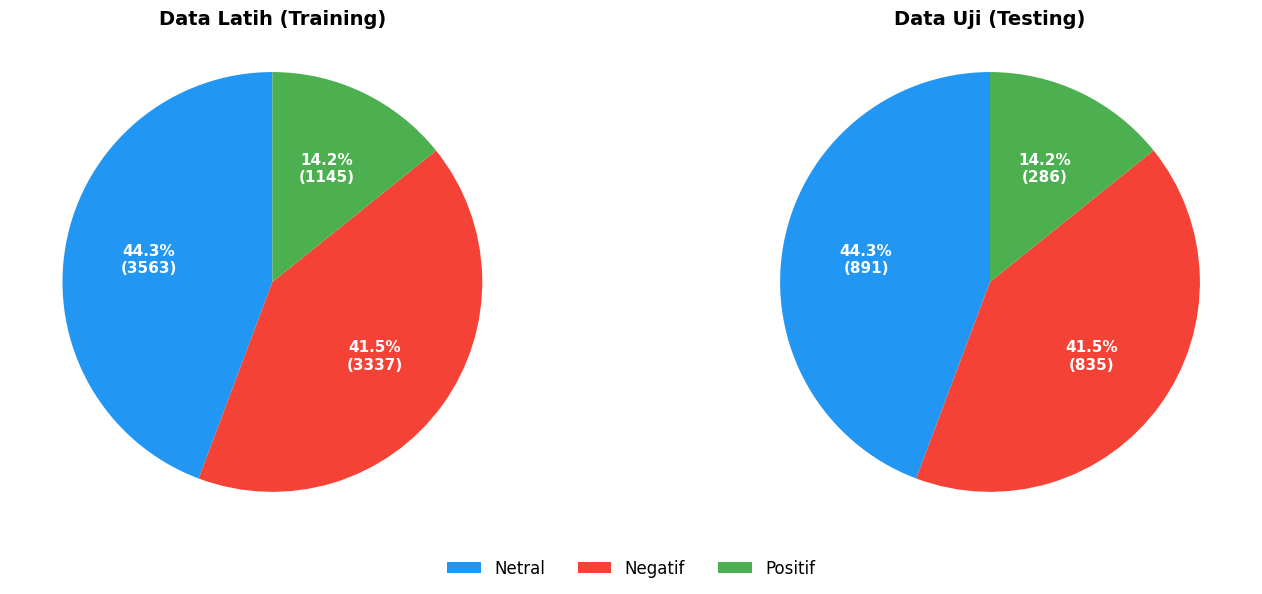

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2196F3', '#F44336', '#4CAF50']  # biru (netral), merah (negatif), hijau (positif)

train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# Fungsi untuk format label persentase dan jumlah
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val})'
    return my_format

# Pie chart untuk data training
wedges1, _, autotexts1 = ax1.pie(
    train_counts,
    colors=colors,
    startangle=90,
    shadow=False,
    autopct=autopct_format(train_counts),
    textprops={'fontsize': 11, 'color': 'white', 'weight': 'bold'}
)

# Turunkan posisi judul
ax1.set_title('Data Latih (Training)', fontsize=14, fontweight='bold', pad=8, y=0.97)

# Pie chart untuk data testing
wedges2, _, autotexts2 = ax2.pie(
    test_counts,
    colors=colors,
    startangle=90,
    shadow=False,
    autopct=autopct_format(test_counts),
    textprops={'fontsize': 11, 'color': 'white', 'weight': 'bold'}
)

# Turunkan posisi judul
ax2.set_title('Data Uji (Testing)', fontsize=14, fontweight='bold', pad=8, y=0.97)

plt.tight_layout()

# Judul utama dengan posisi yang lebih rendah
plt.suptitle('', y=0.98)

legend_labels = ['Netral', 'Negatif', 'Positif']
leg = fig.legend(
    wedges1,
    legend_labels,
    loc='lower center',
    ncol=3,
    frameon=False,
    fontsize=12,
    borderpad=0.5,
    handletextpad=0.8
)

# Sesuaikan layout - kurangi jarak antara plot dan legend
plt.subplots_adjust(bottom=0.08, wspace=0.1)

plt.savefig('distribusi_sentimen_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

# **6. Label Encoding**

In [ ]:
le = LabelEncoder()

In [ ]:
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
reverse_mapping = dict(zip(range(len(le.classes_)), le.classes_))

print("Panduan Label setelah Encoding:")
for encoded, original in reverse_mapping.items():
    print(f"'{original}' -> {encoded}")

Panduan Label setelah Encoding:
'negatif' -> 0
'netral' -> 1
'positif' -> 2


In [ ]:
print("Distribusi kelas setelah encoding:")
train_dist = pd.Series(y_train_enc).value_counts().sort_index()
test_dist = pd.Series(y_test_enc).value_counts().sort_index()

print("\nTraining:")
for idx, count in train_dist.items():
    print(f"  {reverse_mapping[idx]} ({idx}): {count}")

print("\nTesting:")
for idx, count in test_dist.items():
    print(f"  {reverse_mapping[idx]} ({idx}): {count}")

Distribusi kelas setelah encoding:

Training:
  negatif (0): 3337
  netral (1): 3563
  positif (2): 1145

Testing:
  negatif (0): 835
  netral (1): 891
  positif (2): 286


# **7. Feature Extraction (TF-IDF)**



In [ ]:
vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    use_idf=True,
    norm='l2',
    lowercase=True,
    strip_accents='unicode'
)

In [ ]:
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [ ]:
feature_names = vectorizer.get_feature_names_out()

tfidf_sums = np.array(x_train_tfidf.sum(axis=0)).flatten()

tfidf_counts = [(feature_names[i], tfidf_sums[i]) for i in range(len(feature_names))]
tfidf_counts_sorted = sorted(tfidf_counts, key=lambda x: x[1], reverse=True)

top_20 = tfidf_counts_sorted[:20]
bottom_20 = tfidf_counts_sorted[-20:]

In [ ]:
# Informasi dasar tentang hasil transformasi
print("="*50)
print("INFORMASI TF-IDF TRANSFORMATION")
print("="*50)
print(f"Jumlah fitur TF-IDF: {x_train_tfidf.shape[1]:,}")
print(f"Jumlah dokumen training: {x_train_tfidf.shape[0]:,}")
print(f"Jumlah dokumen testing: {x_test_tfidf.shape[0]:,}")
print()

train_sparsity = 1.0 - (x_train_tfidf.nnz / (x_train_tfidf.shape[0] * x_train_tfidf.shape[1]))
test_sparsity = 1.0 - (x_test_tfidf.nnz / (x_test_tfidf.shape[0] * x_test_tfidf.shape[1]))

print(f"Sparsity data training: {train_sparsity:.4f} ({train_sparsity*100:.2f}% kosong)")
print(f"Sparsity data testing: {test_sparsity:.4f} ({test_sparsity*100:.2f}% kosong)")

INFORMASI TF-IDF TRANSFORMATION
Jumlah fitur TF-IDF: 2,384
Jumlah dokumen training: 8,045
Jumlah dokumen testing: 2,012

Sparsity data training: 0.9973 (99.73% kosong)
Sparsity data testing: 0.9974 (99.74% kosong)


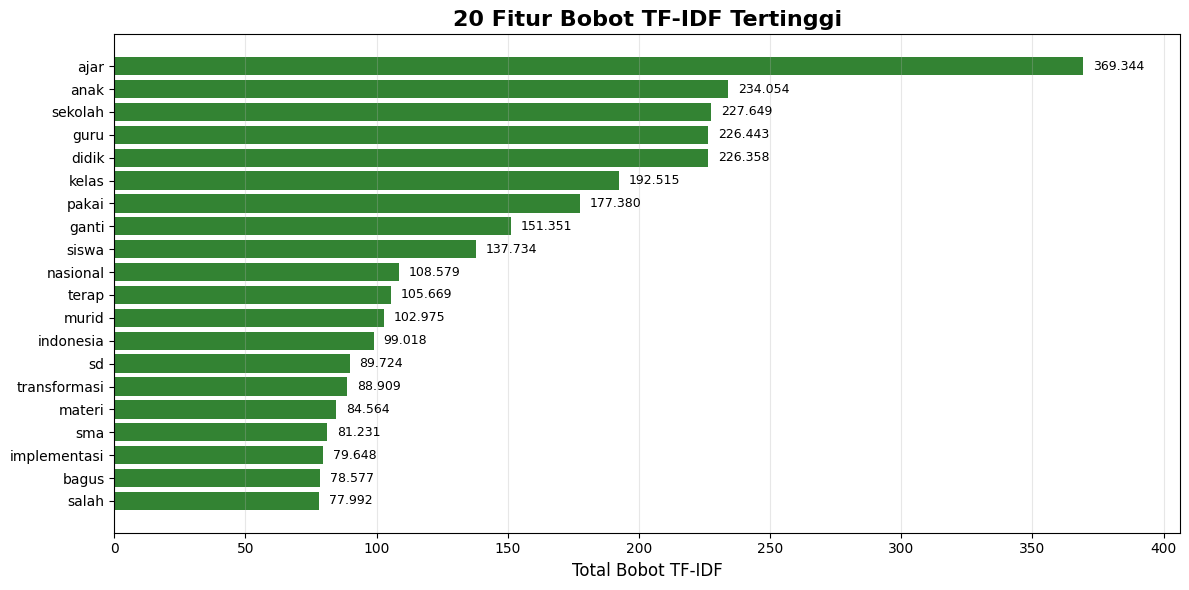

In [ ]:
plt.figure(figsize=(12, 6))
top_words = [word[0] for word in top_20]
top_weights = [word[1] for word in top_20]

bars1 = plt.barh(range(len(top_words)), top_weights, color='darkgreen', alpha=0.8)
plt.yticks(range(len(top_words)), top_words)
plt.xlabel('Total Bobot TF-IDF', fontsize=12)
plt.title('20 Fitur Bobot TF-IDF Tertinggi', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

plt.xlim(0, max(top_weights) * 1.1)  # misalnya 10% lebih lebar dari nilai tertinggi


# Tambahkan nilai di ujung bar
for i, (bar, weight) in enumerate(zip(bars1, top_weights)):
    plt.text(weight + max(top_weights)*0.01, bar.get_y() + bar.get_height()/2,
             f'{weight:.3f}', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_20_tfidf_features.png', dpi=400, bbox_inches='tight')
plt.show()

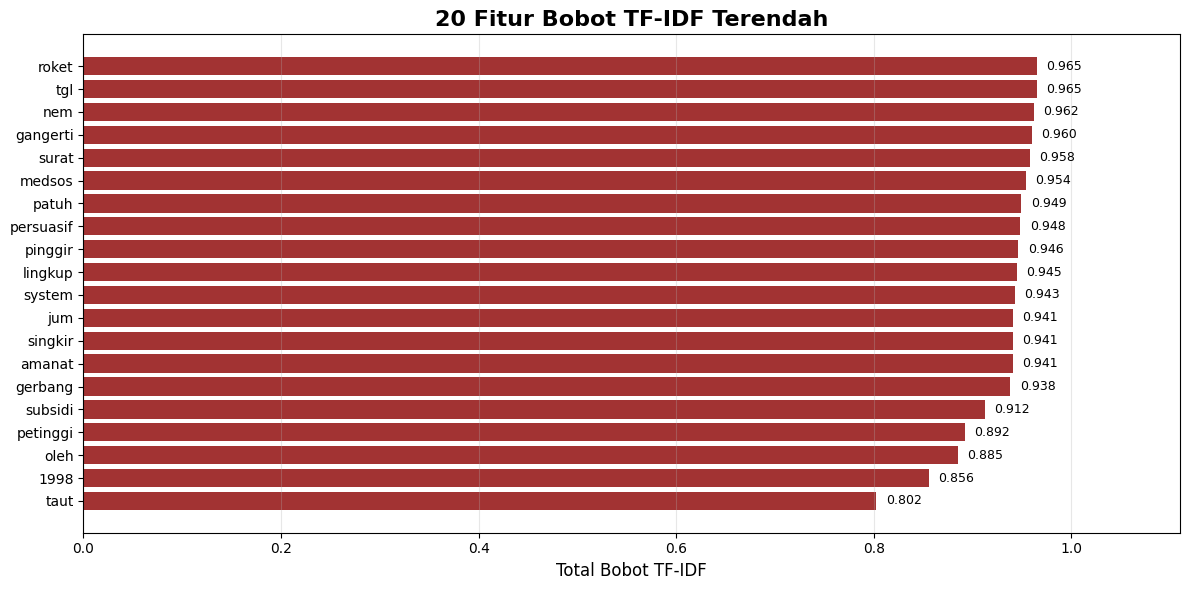

In [ ]:
plt.figure(figsize=(12, 6))
bottom_words = [word[0] for word in bottom_20]
bottom_weights = [word[1] for word in bottom_20]

bars2 = plt.barh(range(len(bottom_words)), bottom_weights, color='darkred', alpha=0.8)
plt.yticks(range(len(bottom_words)), bottom_words)
plt.xlabel('Total Bobot TF-IDF', fontsize=12)
plt.title('20 Fitur Bobot TF-IDF Terendah', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

plt.xlim(0, max(bottom_weights) * 1.15)

for i, (bar, weight) in enumerate(zip(bars2, bottom_weights)):
    plt.text(weight + max(bottom_weights)*0.01, bar.get_y() + bar.get_height()/2,
             f'{weight:.3f}', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('bottom_20_tfidf_features.png', dpi=300, bbox_inches='tight')
plt.show()

# **8. Apply SMOTE on Training Data**

## **8.1 Original Data**

In [ ]:
x_train_nsmote, y_train_nsmote = x_train_tfidf, y_train_enc

In [ ]:
print("Distribusi kelas SEBELUM SMOTE:")
print(Counter(y_train_enc))

Distribusi kelas SEBELUM SMOTE:
Counter({np.int64(1): 3563, np.int64(0): 3337, np.int64(2): 1145})


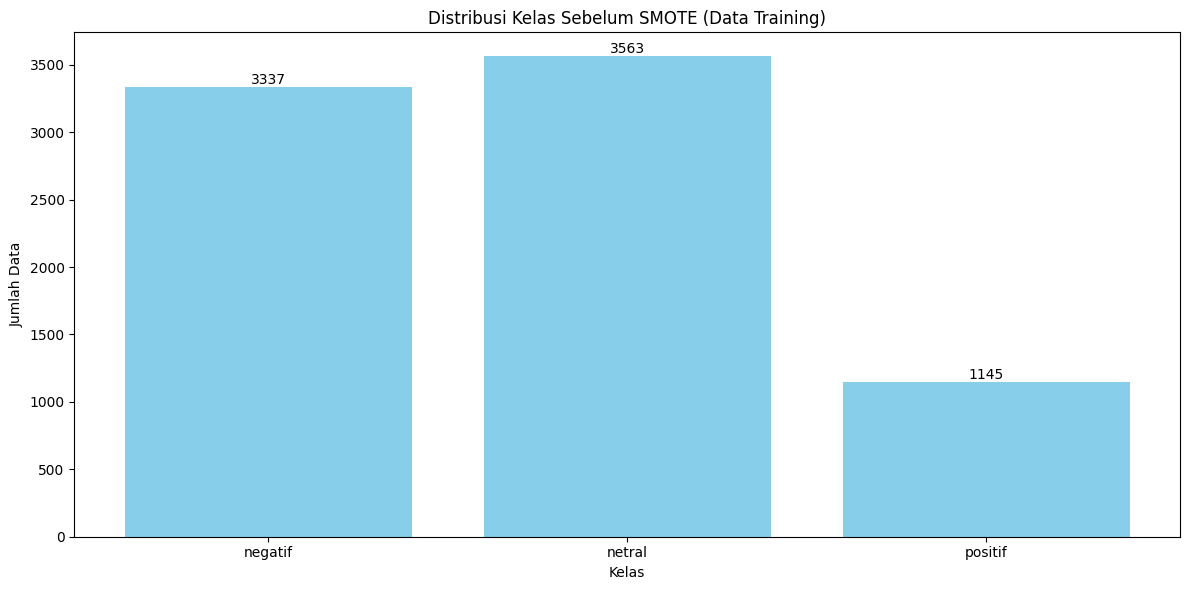

In [ ]:
label_counts = Counter(y_train_nsmote)

plt.figure(figsize=(12, 6))

bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')

# Tambahkan angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

label_mapping = dict(zip(range(len(le.classes_)), le.classes_))
plt.xticks(ticks=list(label_mapping.keys()), labels=list(label_mapping.values()))

plt.title("Distribusi Kelas Sebelum SMOTE (Data Training)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")

plt.tight_layout()
plt.show()

## **8.2 SMOTE**

In [ ]:
smote = SMOTE(sampling_strategy={2: 2500}, random_state=42, k_neighbors=5)

In [ ]:
x_train_smote, y_train_smote = smote.fit_resample(x_train_tfidf, y_train_enc)

In [ ]:
# Distribusi setelah SMOTE
print("Distribusi kelas SETELAH SMOTE:")
label_counts_smote = Counter(y_train_smote)
print(label_counts_smote)

Distribusi kelas SETELAH SMOTE:
Counter({np.int64(1): 3563, np.int64(0): 3337, np.int64(2): 2500})


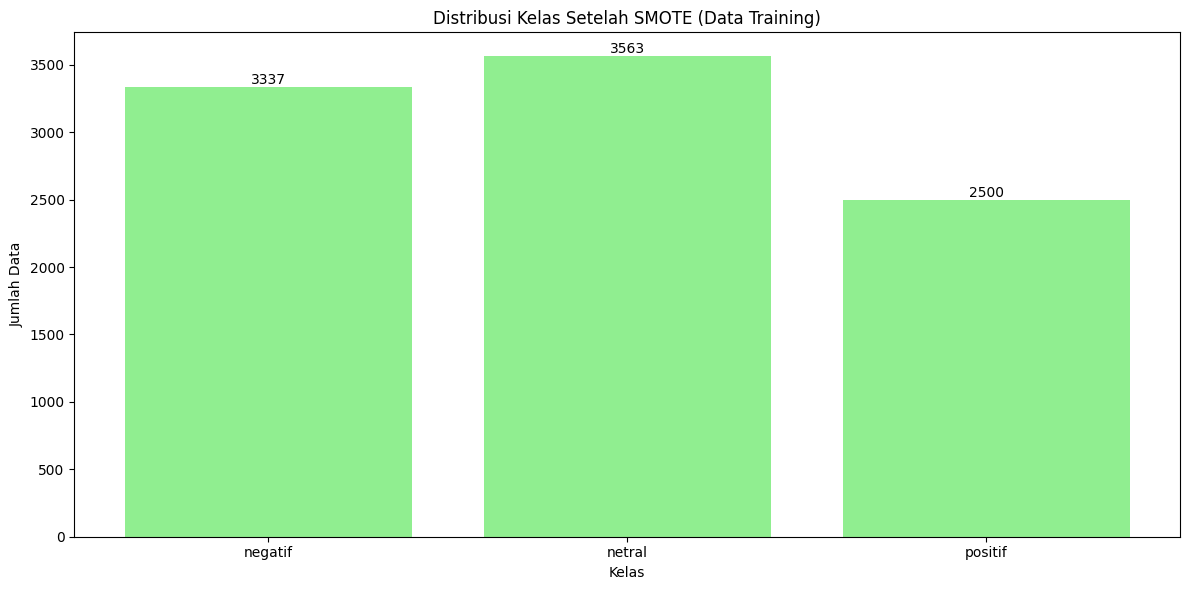

In [ ]:
label_counts_smote = Counter(y_train_smote)

plt.figure(figsize=(12, 6))

bars = plt.bar(label_counts_smote.keys(), label_counts_smote.values(), color='lightgreen')

# Tambahkan angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

label_mapping = dict(zip(range(len(le.classes_)), le.classes_))
plt.xticks(ticks=list(label_mapping.keys()), labels=list(label_mapping.values()))

plt.title("Distribusi Kelas Setelah SMOTE (Data Training)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Jumlah data training:")
print(f"Sebelum SMOTE: {len(y_train_enc):,}")
print(f"Setelah SMOTE: {len(y_train_smote):,}")
print(f"Data tambahan: {len(y_train_smote) - len(y_train_enc):,}")

Jumlah data training:
Sebelum SMOTE: 8,045
Setelah SMOTE: 9,400
Data tambahan: 1,355


In [ ]:
classes = np.unique(y_train_smote)
class_weights = compute_class_weight(
    'balanced',
    classes=classes,
    y=y_train_smote
)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights after SMOTE:", class_weight_dict)

Class weights after SMOTE: {np.int64(0): np.float64(0.9389671361502347), np.int64(1): np.float64(0.8794087379549069), np.int64(2): np.float64(1.2533333333333334)}


# **9. Machine Learning Modeling for Clasification**


## **9.1 <font color="lightgreen"> Random Forest (RF) </font>**

In [ ]:
rf = RandomForestClassifier(random_state=42)

### **9.1.1 Original**

In [ ]:
rf_non_smote = clone(rf)
rf_non_smote.fit(x_train_nsmote, y_train_nsmote)
rf_y_pred_nsmote = rf_non_smote.predict(x_test_tfidf)

In [ ]:
# important_rf_nsmote_params = {k: v for k, v in rf_non_smote.get_params().items()
#                       if k in ['n_estimators', 'max_depth', 'random_state', 'n_jobs',
#                                'class_weight', 'criterion', 'bootstrap', 'max_features',
#                                'min_samples_split', 'min_samples_leaf']}
# pprint.pprint(important_rf_nsmote_params)

### **9.1.2 SMOTE**

In [ ]:
rf_smote = clone(rf)
rf_smote.fit(x_train_smote, y_train_smote)
rf_y_pred_smote = rf_smote.predict(x_test_tfidf)

In [ ]:
# important_rf_params = {k: v for k, v in rf_smote.get_params().items()
#                       if k in ['n_estimators', 'max_depth', 'random_state', 'n_jobs',
#                                'class_weight', 'criterion', 'bootstrap', 'max_features',
#                                'min_samples_split', 'min_samples_leaf']}
# pprint.pprint(important_rf_params)

## **9.2 <font color="red"> Support Vector Machine (SVM) </font>**

In [ ]:
svm = SVC(random_state=42, probability=True)

### **9.2.1 Original**

In [ ]:
svm_non_smote = clone(svm)
svm_non_smote.fit(x_train_nsmote, y_train_nsmote)
svm_y_pred_nsmote = svm_non_smote.predict(x_test_tfidf)

In [ ]:
# important_svm_nsmote_params = {k: v for k, v in svm_non_smote.get_params().items()
#                        if k in ['C', 'kernel', 'gamma', 'probability', 'max_iter', 'tol', 'class_weight']}
# pprint.pprint(important_svm_nsmote_params)

### **9.2.2 SMOTE**

In [ ]:
svm_smote = clone(svm)
svm_smote.fit(x_train_smote, y_train_smote)
svm_y_pred_smote = svm_smote.predict(x_test_tfidf)

In [ ]:
# important_svm_params = {k: v for k, v in svm_smote.get_params().items()
#                        if k in ['C', 'kernel', 'gamma', 'probability', 'max_iter', 'tol', 'class_weight']}
# pprint.pprint(important_svm_params)

# **10. Model Results and Evaluation**

## **10.1 Model Training Result**

In [ ]:
skf_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
def evaluate_model_cv(model, X, y, model_name):
    # Satu kali panggil cross_validate untuk semua metrics
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    cv_results = cross_validate(model, X, y, cv=skf_cv, scoring=scoring,
                                return_train_score=False, n_jobs=-1)

    # Extract results
    results = {
        'accuracy': cv_results['test_accuracy'],
        'precision_macro': cv_results['test_precision_macro'],
        'recall_macro': cv_results['test_recall_macro'],
        'f1_macro': cv_results['test_f1_macro']
    }

    # Display fold-wise results
    print(f'\nDetail Hasil Tiap Fold untuk Model {model_name}')
    print('-' * 70)
    for i in range(len(cv_results['test_accuracy'])):
        print(f'Fold {i+1:>2}: '
              f'Acc={cv_results["test_accuracy"][i]:.4f}, '
              f'Prec={cv_results["test_precision_macro"][i]:.4f}, '
              f'Recall={cv_results["test_recall_macro"][i]:.4f}, '
              f'F1={cv_results["test_f1_macro"][i]:.4f}')
    print('-' * 70)

    # Display average + std results
    print(f'\nHasil Klasifikasi Model {model_name}')
    print('-' * 60)
    print('{:<15} | {:<12} | {:<12} | {:>8}'.format('Metric', 'Mean', 'Std', 'Percent'))
    print('-' * 60)

    for metric, scores in results.items():
        mean_score = scores.mean()
        std_score = scores.std()
        print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format(
            metric.replace('_', ' ').title(), mean_score, std_score, mean_score * 100))

    print('-' * 60)
    return results

### **10.1.1 (Original) <font color="lightgreen">RF</font>**

#### **Cross Valid**

In [ ]:
# models_to_evaluate = [(rf_non_smote, x_train_nsmote, y_train_nsmote, "RF (Non-SMOTE)")]

In [ ]:
# ori_rf = {}
# for model, X, y, name in models_to_evaluate:
#     ori_rf[name] = evaluate_model_cv(model, X, y, name)


Detail Hasil Tiap Fold untuk Model RF (Non-SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7043, Prec=0.7017, Recall=0.6477, F1=0.6657
Fold  2: Acc=0.7043, Prec=0.7466, Recall=0.6513, F1=0.6791
Fold  3: Acc=0.7068, Prec=0.7422, Recall=0.6345, F1=0.6599
Fold  4: Acc=0.6497, Prec=0.6734, Recall=0.5894, F1=0.6119
Fold  5: Acc=0.6398, Prec=0.6988, Recall=0.5822, F1=0.6105
Fold  6: Acc=0.6853, Prec=0.7205, Recall=0.6354, F1=0.6613
Fold  7: Acc=0.6891, Prec=0.7126, Recall=0.6213, F1=0.6447
Fold  8: Acc=0.6953, Prec=0.7209, Recall=0.6258, F1=0.6498
Fold  9: Acc=0.6928, Prec=0.7277, Recall=0.6245, F1=0.6497
Fold 10: Acc=0.7015, Prec=0.7233, Recall=0.6386, F1=0.6626
----------------------------------------------------------------------

Hasil Klasifikasi Model RF (Non-SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
-----------------------------------------------------------

#### **Save & Load CV**

In [ ]:
# # Save Hasil CV
# with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_orf.pkl', 'wb') as f:
#     pickle.dump(ori_rf, f)

# print("Hasil cross-validation berhasil disimpan!")

Hasil cross-validation berhasil disimpan!


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_orf.pkl"

if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        ori_rf = pickle.load(f)

    # Ambil hasil CV untuk model RF (Non-SMOTE)
    model_name = "RF (Non-SMOTE)"
    cv_results = ori_rf[model_name]

    acc_rf_nsmote = cv_results['accuracy']
    pre_rf_nsmote = cv_results['precision_macro']
    rec_rf_nsmote = cv_results['recall_macro']
    f_rf_nsmote = cv_results['f1_macro']

    # Cetak hasil tiap fold
    print(f'\nDetail Hasil Tiap Fold untuk Model {model_name}')
    print('-' * 60)
    for i in range(len(acc_rf_nsmote)):
        print(f'Fold {i+1:>2}: '
              f'Acc={acc_rf_nsmote[i]:.4f}, '
              f'Prec={pre_rf_nsmote[i]:.4f}, '
              f'Recall={rec_rf_nsmote[i]:.4f}, '
              f'F1={f_rf_nsmote[i]:.4f}')
    print('-' * 60)

    # Cetak ringkasan statistik
    print(f'\nHasil Klasifikasi Model {model_name}')
    print('-' * 60)
    print('{:<15} | {:<12} | {:<12} | {:>8}'.format('Metric', 'Mean', 'Std', 'Percent'))
    print('-' * 60)
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Accuracy', acc_rf_nsmote.mean(), acc_rf_nsmote.std(), acc_rf_nsmote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Precision Macro', pre_rf_nsmote.mean(), pre_rf_nsmote.std(), pre_rf_nsmote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Recall Macro', rec_rf_nsmote.mean(), rec_rf_nsmote.std(), rec_rf_nsmote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('F1 Macro', f_rf_nsmote.mean(), f_rf_nsmote.std(), f_rf_nsmote.mean() * 100))
    print('-' * 60)
else:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan file tersebut ada.")


Detail Hasil Tiap Fold untuk Model RF (Non-SMOTE)
------------------------------------------------------------
Fold  1: Acc=0.7043, Prec=0.7017, Recall=0.6477, F1=0.6657
Fold  2: Acc=0.7043, Prec=0.7466, Recall=0.6513, F1=0.6791
Fold  3: Acc=0.7068, Prec=0.7422, Recall=0.6345, F1=0.6599
Fold  4: Acc=0.6497, Prec=0.6734, Recall=0.5894, F1=0.6119
Fold  5: Acc=0.6398, Prec=0.6988, Recall=0.5822, F1=0.6105
Fold  6: Acc=0.6853, Prec=0.7205, Recall=0.6354, F1=0.6613
Fold  7: Acc=0.6891, Prec=0.7126, Recall=0.6213, F1=0.6447
Fold  8: Acc=0.6953, Prec=0.7209, Recall=0.6258, F1=0.6498
Fold  9: Acc=0.6928, Prec=0.7277, Recall=0.6245, F1=0.6497
Fold 10: Acc=0.7015, Prec=0.7233, Recall=0.6386, F1=0.6626
------------------------------------------------------------

Hasil Klasifikasi Model RF (Non-SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
------------------------------------------------------------
Accuracy        | 

### **10.1.2 (SMOTE) <font color="lightgreen">RF</font>**

#### **Cross Valid**

In [ ]:
# models_to_evaluate = [(rf_smote, x_train_smote, y_train_smote, "RF (SMOTE)")]

In [ ]:
# smote_rf = {}
# for model, X, y, name in models_to_evaluate:
#     smote_rf[name] = evaluate_model_cv(model, X, y, name)


Detail Hasil Tiap Fold untuk Model RF (SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7691, Prec=0.7737, Recall=0.7798, F1=0.7756
Fold  2: Acc=0.7447, Prec=0.7544, Recall=0.7541, F1=0.7537
Fold  3: Acc=0.7596, Prec=0.7707, Recall=0.7667, F1=0.7685
Fold  4: Acc=0.7309, Prec=0.7377, Recall=0.7404, F1=0.7377
Fold  5: Acc=0.7277, Prec=0.7422, Recall=0.7422, F1=0.7422
Fold  6: Acc=0.7394, Prec=0.7511, Recall=0.7469, F1=0.7482
Fold  7: Acc=0.7564, Prec=0.7620, Recall=0.7677, F1=0.7646
Fold  8: Acc=0.7479, Prec=0.7546, Recall=0.7571, F1=0.7556
Fold  9: Acc=0.7457, Prec=0.7534, Recall=0.7555, F1=0.7543
Fold 10: Acc=0.7479, Prec=0.7569, Recall=0.7561, F1=0.7562
----------------------------------------------------------------------

Hasil Klasifikasi Model RF (SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
------------------------------------------------------------
Accura

#### **Save & Load CV**

In [ ]:
# # Save Hasil CV
# with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_srf.pkl', 'wb') as f:
#     pickle.dump(smote_rf, f)

# print("Hasil cross-validation berhasil disimpan!")

Hasil cross-validation berhasil disimpan!


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_srf.pkl"

if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        smote_rf = pickle.load(f)

    # Mengambil hasil dari cross-validation untuk model RF (SMOTE)
    model_name = "RF (SMOTE)"
    cv_results = smote_rf[model_name]

    acc_rf_smote = cv_results['accuracy']
    pre_rf_smote = cv_results['precision_macro']
    rec_rf_smote = cv_results['recall_macro']
    f_rf_smote = cv_results['f1_macro']

    # Menampilkan hasil tiap fold
    print(f'\nDetail Hasil Tiap Fold untuk Model {model_name}')
    print('-' * 70)
    for i in range(len(acc_rf_smote)):
        print(f'Fold {i+1:>2}: '
              f'Acc={acc_rf_smote[i]:.4f}, '
              f'Prec={pre_rf_smote[i]:.4f}, '
              f'Recall={rec_rf_smote[i]:.4f}, '
              f'F1={f_rf_smote[i]:.4f}')
    print('-' * 70)

    # Menampilkan ringkasan performa
    print(f'\nHasil Klasifikasi Model {model_name}')
    print('-' * 60)
    print('{:<15} | {:<12} | {:<12} | {:>8}'.format('Metric', 'Mean', 'Std', 'Percent'))
    print('-' * 60)
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Accuracy', acc_rf_smote.mean(), acc_rf_smote.std(), acc_rf_smote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Precision Macro', pre_rf_smote.mean(), pre_rf_smote.std(), pre_rf_smote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Recall Macro', rec_rf_smote.mean(), rec_rf_smote.std(), rec_rf_smote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('F1 Macro', f_rf_smote.mean(), f_rf_smote.std(), f_rf_smote.mean() * 100))
    print('-' * 60)

else:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan file tersebut ada.")


Detail Hasil Tiap Fold untuk Model RF (SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7691, Prec=0.7737, Recall=0.7798, F1=0.7756
Fold  2: Acc=0.7447, Prec=0.7544, Recall=0.7541, F1=0.7537
Fold  3: Acc=0.7596, Prec=0.7707, Recall=0.7667, F1=0.7685
Fold  4: Acc=0.7309, Prec=0.7377, Recall=0.7404, F1=0.7377
Fold  5: Acc=0.7277, Prec=0.7422, Recall=0.7422, F1=0.7422
Fold  6: Acc=0.7394, Prec=0.7511, Recall=0.7469, F1=0.7482
Fold  7: Acc=0.7564, Prec=0.7620, Recall=0.7677, F1=0.7646
Fold  8: Acc=0.7479, Prec=0.7546, Recall=0.7571, F1=0.7556
Fold  9: Acc=0.7457, Prec=0.7534, Recall=0.7555, F1=0.7543
Fold 10: Acc=0.7479, Prec=0.7569, Recall=0.7561, F1=0.7562
----------------------------------------------------------------------

Hasil Klasifikasi Model RF (SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
------------------------------------------------------------
Accura

### **10.1.3 (Original) <font color="red"> SVM </font>**

#### **Cross Valid**

In [ ]:
# models_to_evaluate = [(svm_non_smote, x_train_nsmote, y_train_nsmote, "SVM (Non-SMOTE)")]

In [ ]:
# ori_svm = {}
# for model, X, y, name in models_to_evaluate:
#     ori_svm[name] = evaluate_model_cv(model, X, y, name)


Detail Hasil Tiap Fold untuk Model SVM (Non-SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7366, Prec=0.7415, Recall=0.6793, F1=0.6997
Fold  2: Acc=0.7242, Prec=0.7579, Recall=0.6784, F1=0.7042
Fold  3: Acc=0.7106, Prec=0.7618, Recall=0.6430, F1=0.6719
Fold  4: Acc=0.6957, Prec=0.7311, Recall=0.6491, F1=0.6751
Fold  5: Acc=0.6720, Prec=0.7086, Recall=0.6078, F1=0.6328
Fold  6: Acc=0.7177, Prec=0.7575, Recall=0.6759, F1=0.7028
Fold  7: Acc=0.7326, Prec=0.7610, Recall=0.6649, F1=0.6909
Fold  8: Acc=0.7264, Prec=0.7792, Recall=0.6635, F1=0.6940
Fold  9: Acc=0.7102, Prec=0.7462, Recall=0.6423, F1=0.6682
Fold 10: Acc=0.7351, Prec=0.7882, Recall=0.6802, F1=0.7115
----------------------------------------------------------------------

Hasil Klasifikasi Model SVM (Non-SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
---------------------------------------------------------

#### **Save & Load CV**

In [ ]:
# # Save Hasil CV
# with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_osvm.pkl', 'wb') as f:
#     pickle.dump(ori_svm, f)

# print("Hasil cross-validation berhasil disimpan!")

Hasil cross-validation berhasil disimpan!


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_osvm.pkl"

if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        ori_svm = pickle.load(f)

    # Mengambil hasil dari cross-validation untuk model SVM (Non-SMOTE)
    model_name = "SVM (Non-SMOTE)"
    cv_results = ori_svm[model_name]

    acc_svm_nsmote = cv_results['accuracy']
    pre_svm_nsmote = cv_results['precision_macro']
    rec_svm_nsmote = cv_results['recall_macro']
    f_svm_nsmote = cv_results['f1_macro']

    # Menampilkan hasil tiap fold
    print(f'\nDetail Hasil Tiap Fold untuk Model {model_name}')
    print('-' * 70)
    for i in range(len(acc_svm_nsmote)):
        print(f'Fold {i+1:>2}: '
              f'Acc={acc_svm_nsmote[i]:.4f}, '
              f'Prec={pre_svm_nsmote[i]:.4f}, '
              f'Recall={rec_svm_nsmote[i]:.4f}, '
              f'F1={f_svm_nsmote[i]:.4f}')
    print('-' * 70)

    # Menampilkan ringkasan performa
    print(f'\nHasil Klasifikasi Model {model_name}')
    print('-' * 60)
    print('{:<15} | {:<12} | {:<12} | {:>8}'.format('Metric', 'Mean', 'Std', 'Percent'))
    print('-' * 60)
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Accuracy', acc_svm_nsmote.mean(), acc_svm_nsmote.std(), acc_svm_nsmote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Precision Macro', pre_svm_nsmote.mean(), pre_svm_nsmote.std(), pre_svm_nsmote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Recall Macro', rec_svm_nsmote.mean(), rec_svm_nsmote.std(), rec_svm_nsmote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('F1 Macro', f_svm_nsmote.mean(), f_svm_nsmote.std(), f_svm_nsmote.mean() * 100))
    print('-' * 60)

else:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan file tersebut ada.")


Detail Hasil Tiap Fold untuk Model SVM (Non-SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7366, Prec=0.7415, Recall=0.6793, F1=0.6997
Fold  2: Acc=0.7242, Prec=0.7579, Recall=0.6784, F1=0.7042
Fold  3: Acc=0.7106, Prec=0.7618, Recall=0.6430, F1=0.6719
Fold  4: Acc=0.6957, Prec=0.7311, Recall=0.6491, F1=0.6751
Fold  5: Acc=0.6720, Prec=0.7086, Recall=0.6078, F1=0.6328
Fold  6: Acc=0.7177, Prec=0.7575, Recall=0.6759, F1=0.7028
Fold  7: Acc=0.7326, Prec=0.7610, Recall=0.6649, F1=0.6909
Fold  8: Acc=0.7264, Prec=0.7792, Recall=0.6635, F1=0.6940
Fold  9: Acc=0.7102, Prec=0.7462, Recall=0.6423, F1=0.6682
Fold 10: Acc=0.7351, Prec=0.7882, Recall=0.6802, F1=0.7115
----------------------------------------------------------------------

Hasil Klasifikasi Model SVM (Non-SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
---------------------------------------------------------

### **10.1.4 (SMOTE) <font color="red"> SVM </font>**

#### **Cross Valid**

In [ ]:
# models_to_evaluate = [(svm_smote, x_train_smote, y_train_smote, "SVM (SMOTE)")]

In [ ]:
# smote_svm = {}
# for model, X, y, name in models_to_evaluate:
#     smote_svm[name] = evaluate_model_cv(model, X, y, name)


Detail Hasil Tiap Fold untuk Model SVM (SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7745, Prec=0.7902, Recall=0.7744, F1=0.7807
Fold  2: Acc=0.7564, Prec=0.7865, Recall=0.7556, F1=0.7662
Fold  3: Acc=0.7394, Prec=0.7675, Recall=0.7369, F1=0.7474
Fold  4: Acc=0.7234, Prec=0.7518, Recall=0.7239, F1=0.7340
Fold  5: Acc=0.7202, Prec=0.7475, Recall=0.7237, F1=0.7330
Fold  6: Acc=0.7340, Prec=0.7640, Recall=0.7320, F1=0.7428
Fold  7: Acc=0.7702, Prec=0.7958, Recall=0.7682, F1=0.7780
Fold  8: Acc=0.7383, Prec=0.7663, Recall=0.7366, F1=0.7471
Fold  9: Acc=0.7383, Prec=0.7659, Recall=0.7370, F1=0.7467
Fold 10: Acc=0.7511, Prec=0.7802, Recall=0.7488, F1=0.7596
----------------------------------------------------------------------

Hasil Klasifikasi Model SVM (SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
------------------------------------------------------------
Accu

#### **Save & Load CV**

In [ ]:
# # Save Hasil CV
# with open('/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_ssvm.pkl', 'wb') as f:
#     pickle.dump(smote_svm, f)

# print("Hasil cross-validation berhasil disimpan!")

Hasil cross-validation berhasil disimpan!


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir (TA)/Check Point/cv_results_ssvm.pkl"

if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        smote_svm = pickle.load(f)

    model_name = "SVM (SMOTE)"
    cv_results = smote_svm[model_name]

    acc_svm_smote = cv_results['accuracy']
    pre_svm_smote = cv_results['precision_macro']
    rec_svm_smote = cv_results['recall_macro']
    f_svm_smote = cv_results['f1_macro']

    # Menampilkan hasil tiap fold
    print(f'\nDetail Hasil Tiap Fold untuk Model {model_name}')
    print('-' * 70)
    for i in range(len(acc_svm_smote)):
        print(f'Fold {i+1:>2}: '
              f'Acc={acc_svm_smote[i]:.4f}, '
              f'Prec={pre_svm_smote[i]:.4f}, '
              f'Recall={rec_svm_smote[i]:.4f}, '
              f'F1={f_svm_smote[i]:.4f}')
    print('-' * 70)

    # Menampilkan ringkasan hasil klasifikasi
    print(f'\nHasil Klasifikasi Model {model_name}')
    print('-' * 60)
    print('{:<15} | {:<12} | {:<12} | {:>8}'.format('Metric', 'Mean', 'Std', 'Percent'))
    print('-' * 60)
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Accuracy', acc_svm_smote.mean(), acc_svm_smote.std(), acc_svm_smote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Precision Macro', pre_svm_smote.mean(), pre_svm_smote.std(), pre_svm_smote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('Recall Macro', rec_svm_smote.mean(), rec_svm_smote.std(), rec_svm_smote.mean() * 100))
    print('{:<15} | {:<12.4f} | {:<12.4f} | {:>7.2f}%'.format('F1 Macro', f_svm_smote.mean(), f_svm_smote.std(), f_svm_smote.mean() * 100))
    print('-' * 60)

else:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan file tersebut ada.")


Detail Hasil Tiap Fold untuk Model SVM (SMOTE)
----------------------------------------------------------------------
Fold  1: Acc=0.7745, Prec=0.7902, Recall=0.7744, F1=0.7807
Fold  2: Acc=0.7564, Prec=0.7865, Recall=0.7556, F1=0.7662
Fold  3: Acc=0.7394, Prec=0.7675, Recall=0.7369, F1=0.7474
Fold  4: Acc=0.7234, Prec=0.7518, Recall=0.7239, F1=0.7340
Fold  5: Acc=0.7202, Prec=0.7475, Recall=0.7237, F1=0.7330
Fold  6: Acc=0.7340, Prec=0.7640, Recall=0.7320, F1=0.7428
Fold  7: Acc=0.7702, Prec=0.7958, Recall=0.7682, F1=0.7780
Fold  8: Acc=0.7383, Prec=0.7663, Recall=0.7366, F1=0.7471
Fold  9: Acc=0.7383, Prec=0.7659, Recall=0.7370, F1=0.7467
Fold 10: Acc=0.7511, Prec=0.7802, Recall=0.7488, F1=0.7596
----------------------------------------------------------------------

Hasil Klasifikasi Model SVM (SMOTE)
------------------------------------------------------------
Metric          | Mean         | Std          |  Percent
------------------------------------------------------------
Accu

## **10.2 Confusion Matrix (Testing Data)**

In [ ]:
class_names = le.classes_

In [ ]:
def plot_confusion_matrix_single(y_true, y_pred, model_name, figsize=(8, 6)):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return cm

In [ ]:
def print_classification_report_single(y_true, y_pred, model_name):
    print("="*70)
    print(f"CLASSIFICATION REPORT - {model_name}")
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Calculate per-class accuracy
    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    print("-" * 30)
    for i, acc in enumerate(class_accuracy):
        print(f"{class_names[i]:<10}: {acc:.3f} ({acc*100:.1f}%)")

    # Overall accuracy
    overall_acc = np.trace(cm) / np.sum(cm)
    print(f"{'Overall':<10}: {overall_acc:.3f} ({overall_acc*100:.1f}%)")

### **10.2.1 (Original) <font color="lightgreen"> RF </font>**

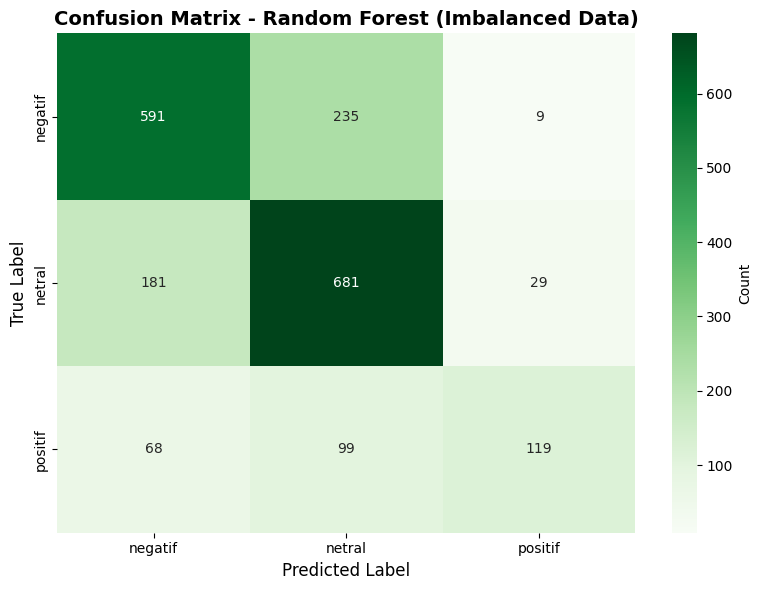

In [ ]:
cm_rf_nsmote = plot_confusion_matrix_single(y_test_enc, rf_y_pred_nsmote, "Random Forest (Imbalanced Data)")

In [ ]:
print_classification_report_single(y_test_enc, rf_y_pred_nsmote, "Random Forest (Imbalanced Data)")

CLASSIFICATION REPORT - Random Forest (Imbalanced Data)
              precision    recall  f1-score   support

     negatif       0.70      0.71      0.71       835
      netral       0.67      0.76      0.71       891
     positif       0.76      0.42      0.54       286

    accuracy                           0.69      2012
   macro avg       0.71      0.63      0.65      2012
weighted avg       0.70      0.69      0.69      2012


Per-Class Accuracy:
------------------------------
negatif   : 0.708 (70.8%)
netral    : 0.764 (76.4%)
positif   : 0.416 (41.6%)
Overall   : 0.691 (69.1%)


### **10.2.2 (SMOTE) <font color="lightgreen"> RF </font>**

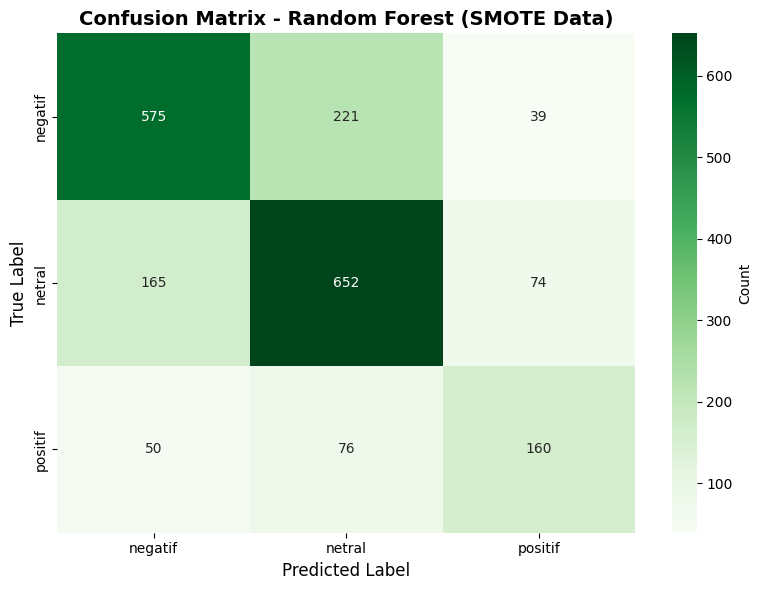

In [ ]:
cm_rf_smote = plot_confusion_matrix_single(y_test_enc, rf_y_pred_smote, "Random Forest (SMOTE Data)")

In [ ]:
print_classification_report_single(y_test_enc, rf_y_pred_smote, "Random Forest (SMOTE)")

CLASSIFICATION REPORT - Random Forest (SMOTE)
              precision    recall  f1-score   support

     negatif       0.73      0.69      0.71       835
      netral       0.69      0.73      0.71       891
     positif       0.59      0.56      0.57       286

    accuracy                           0.69      2012
   macro avg       0.67      0.66      0.66      2012
weighted avg       0.69      0.69      0.69      2012


Per-Class Accuracy:
------------------------------
negatif   : 0.689 (68.9%)
netral    : 0.732 (73.2%)
positif   : 0.559 (55.9%)
Overall   : 0.689 (68.9%)


### **10.2.3 (Original) <font color="red"> SVM </font>**

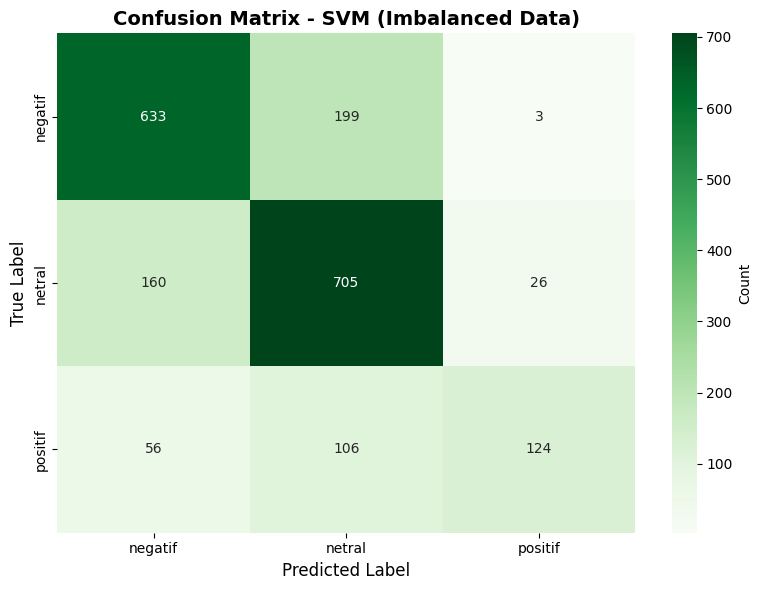

In [ ]:
cm_svm_nsmote = plot_confusion_matrix_single(y_test_enc, svm_y_pred_nsmote, "SVM (Imbalanced Data)")

In [ ]:
print_classification_report_single(y_test_enc, svm_y_pred_nsmote, "SVM (Imbalanced Data)")

CLASSIFICATION REPORT - SVM (Imbalanced Data)
              precision    recall  f1-score   support

     negatif       0.75      0.76      0.75       835
      netral       0.70      0.79      0.74       891
     positif       0.81      0.43      0.56       286

    accuracy                           0.73      2012
   macro avg       0.75      0.66      0.69      2012
weighted avg       0.73      0.73      0.72      2012


Per-Class Accuracy:
------------------------------
negatif   : 0.758 (75.8%)
netral    : 0.791 (79.1%)
positif   : 0.434 (43.4%)
Overall   : 0.727 (72.7%)


### **10.2.4 (SMOTE) <font color="red"> SVM </font>**

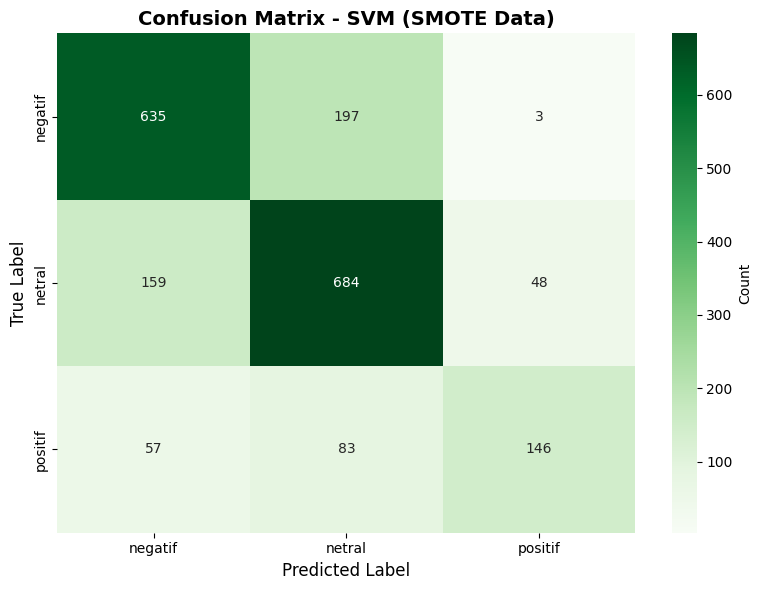

In [ ]:
cm_svm_smote = plot_confusion_matrix_single(y_test_enc, svm_y_pred_smote, "SVM (SMOTE Data)")

In [ ]:
print_classification_report_single(y_test_enc, svm_y_pred_smote, "SVM (SMOTE Data)")

CLASSIFICATION REPORT - SVM (SMOTE Data)
              precision    recall  f1-score   support

     negatif       0.75      0.76      0.75       835
      netral       0.71      0.77      0.74       891
     positif       0.74      0.51      0.60       286

    accuracy                           0.73      2012
   macro avg       0.73      0.68      0.70      2012
weighted avg       0.73      0.73      0.73      2012


Per-Class Accuracy:
------------------------------
negatif   : 0.760 (76.0%)
netral    : 0.768 (76.8%)
positif   : 0.510 (51.0%)
Overall   : 0.728 (72.8%)


## **10.3 ROC AUC**

In [ ]:
skf_lc = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### **10.3.1 (Original) <font color="lightgreen"> RF </font> & <font color="red"> SVM </font>**

In [ ]:
y_test_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
n_classes = y_test_bin.shape[1]

rf_probs_nonsmote = rf_non_smote.predict_proba(x_test_tfidf)
svm_probs_nonsmote = svm_non_smote.predict_proba(x_test_tfidf)

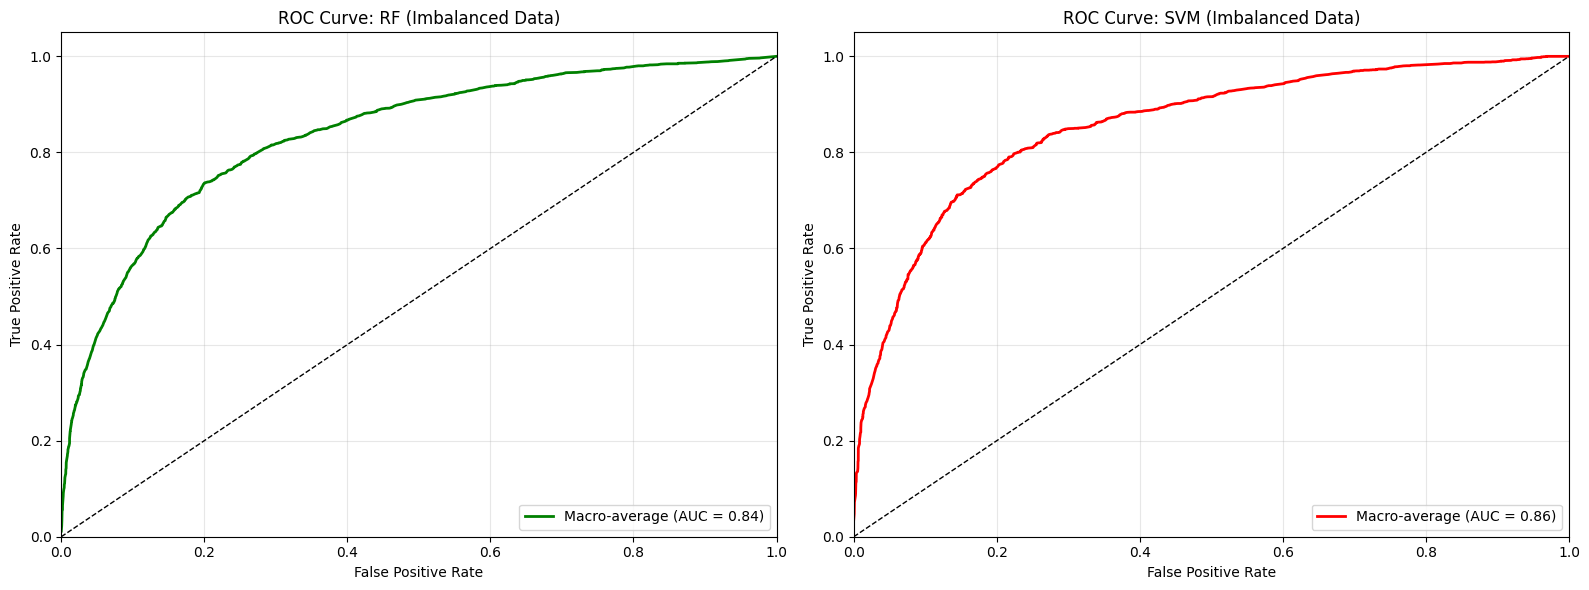

In [ ]:
models_nonsmote = {'RF': rf_probs_nonsmote, 'SVM': svm_probs_nonsmote}
colors = {'RF': 'green', 'SVM': 'red'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (model_name, y_score) in enumerate(models_nonsmote.items()):
    # Hitung FPR dan TPR untuk tiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gabungkan semua FPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolasi TPR dan hitung rata-rata (macro)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot kurva ROC untuk model saat ini dengan warna yang sesuai
    axes[idx].plot(fpr_macro, tpr_macro, color=colors[model_name], lw=2,
             label=f'Macro-average (AUC = {roc_auc_macro:.2f})')

    # Pengaturan plot
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'ROC Curve: {model_name} (Imbalanced Data)')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_comparison_nonsmote.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
def plot_multiclass_roc_side_by_side_nonsmote(models, X_test, y_test, n_classes, model_names):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    colors = ['red', 'blue', 'green']
    classes = ['Negatif', 'Netral', 'Positif']

    for idx, (model, model_name) in enumerate(zip(models, model_names)):
        # Binarisasi label
        y_test_bin = np.zeros((len(y_test), n_classes))
        for i in range(len(y_test)):
            y_test_bin[i, y_test[i]] = 1

        # Prediksi probabilitas
        y_score = model.predict_proba(X_test)

        # Hitung ROC curve untuk setiap kelas
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

            # Plot untuk kelas ke-i
            axes[idx].plot(fpr[i], tpr[i], color=colors[i], lw=2,
                     label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

        # Plot garis diagonal
        axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'ROC Curve Multiclass: {model_name}')
        axes[idx].legend(loc="lower right")
        axes[idx].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('roc_comparison_multiclass_nonsmote.png', dpi=400, bbox_inches='tight')
    plt.show()

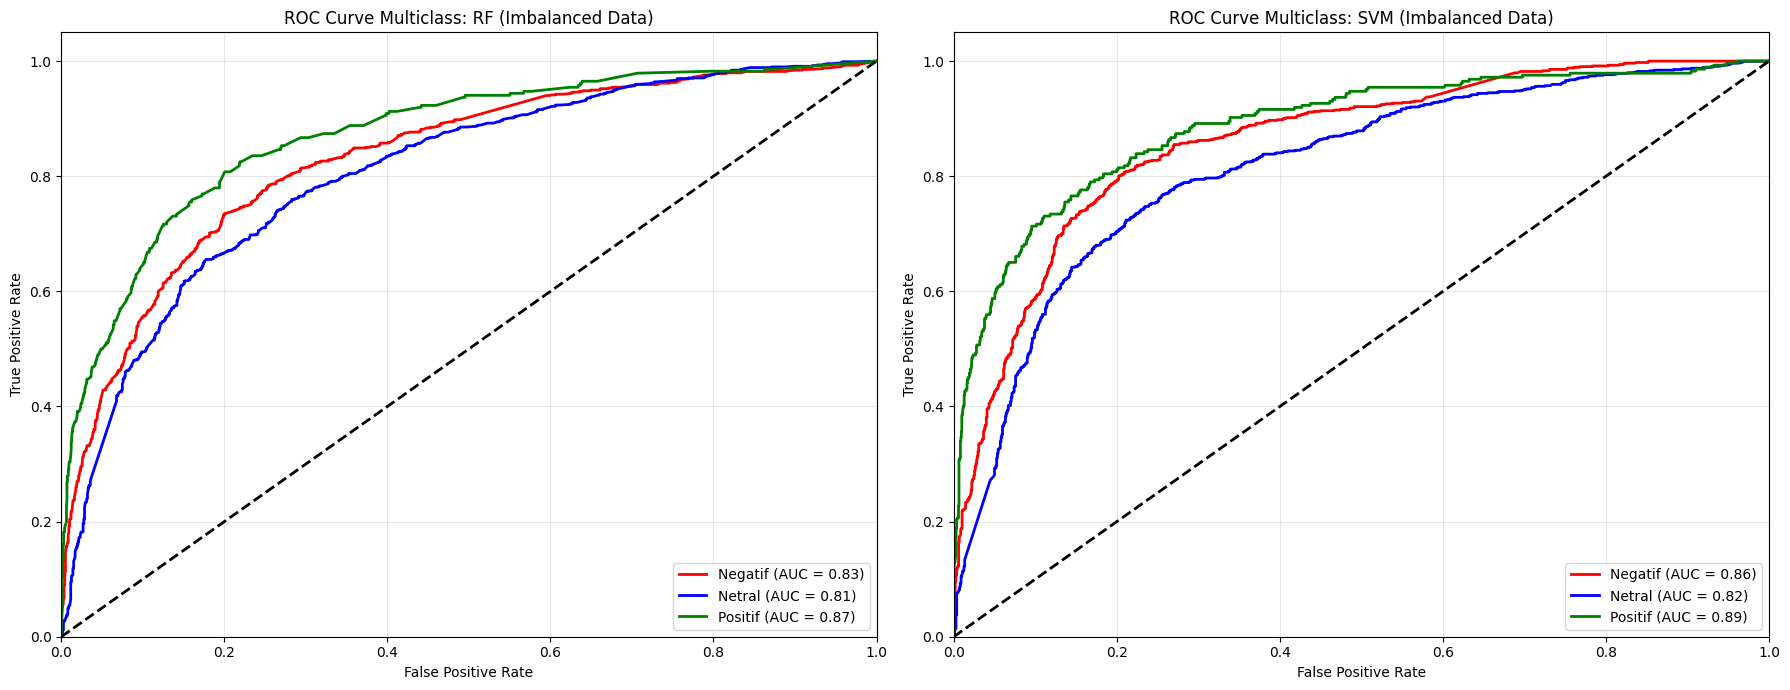

In [ ]:
models_nonsmote = [rf_non_smote, svm_non_smote]
model_names = ["RF (Imbalanced Data)", "SVM (Imbalanced Data)"]
n_classes = 3  # Jumlah kelas: positif, negatif, netral

plot_multiclass_roc_side_by_side_nonsmote(models_nonsmote, x_test_tfidf, y_test_enc, n_classes, model_names)

### **10.3.2 (SMOTE) <font color="lightgreen"> RF </font> & <font color="red"> SVM </font>**

In [ ]:
y_test_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
n_classes = y_test_bin.shape[1]

rf_probs = rf_smote.predict_proba(x_test_tfidf)
svm_probs = svm_smote.predict_proba(x_test_tfidf)

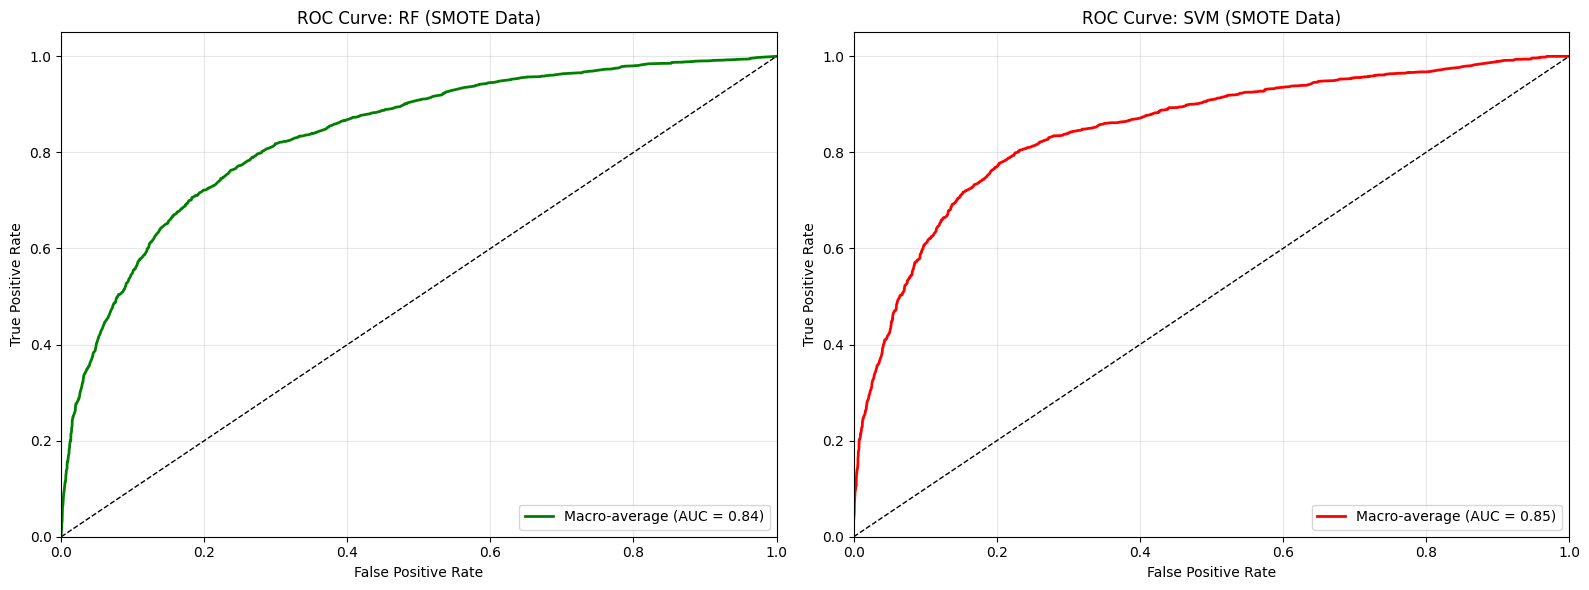

In [ ]:
models = {'RF': rf_probs, 'SVM': svm_probs}
colors = {'RF': 'green', 'SVM': 'red'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (model_name, y_score) in enumerate(models.items()):
    # Hitung FPR dan TPR untuk tiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gabungkan semua FPR
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolasi TPR dan hitung rata-rata (macro)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot kurva ROC untuk model saat ini dengan warna yang sesuai
    axes[idx].plot(fpr_macro, tpr_macro, color=colors[model_name], lw=2,
             label=f'Macro-average (AUC = {roc_auc_macro:.2f})')

    # Pengaturan plot
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'ROC Curve: {model_name} (SMOTE Data)')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_comparison_simple.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def plot_multiclass_roc_side_by_side(models, X_test, y_test, n_classes, model_names):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    colors = ['red', 'blue', 'green']
    classes = ['Negatif', 'Netral', 'Positif']

    for idx, (model, model_name) in enumerate(zip(models, model_names)):
        # Binarisasi label
        y_test_bin = np.zeros((len(y_test), n_classes))
        for i in range(len(y_test)):
            y_test_bin[i, y_test[i]] = 1

        # Prediksi probabilitas
        y_score = model.predict_proba(X_test)

        # Hitung ROC curve untuk setiap kelas
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

            # Plot untuk kelas ke-i
            axes[idx].plot(fpr[i], tpr[i], color=colors[i], lw=2,
                     label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

        # Plot garis diagonal
        axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'ROC Curve Multiclass: {model_name}')
        axes[idx].legend(loc="lower right")
        axes[idx].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('roc_comparison_multiclass.png', dpi=300, bbox_inches='tight')
    plt.show()

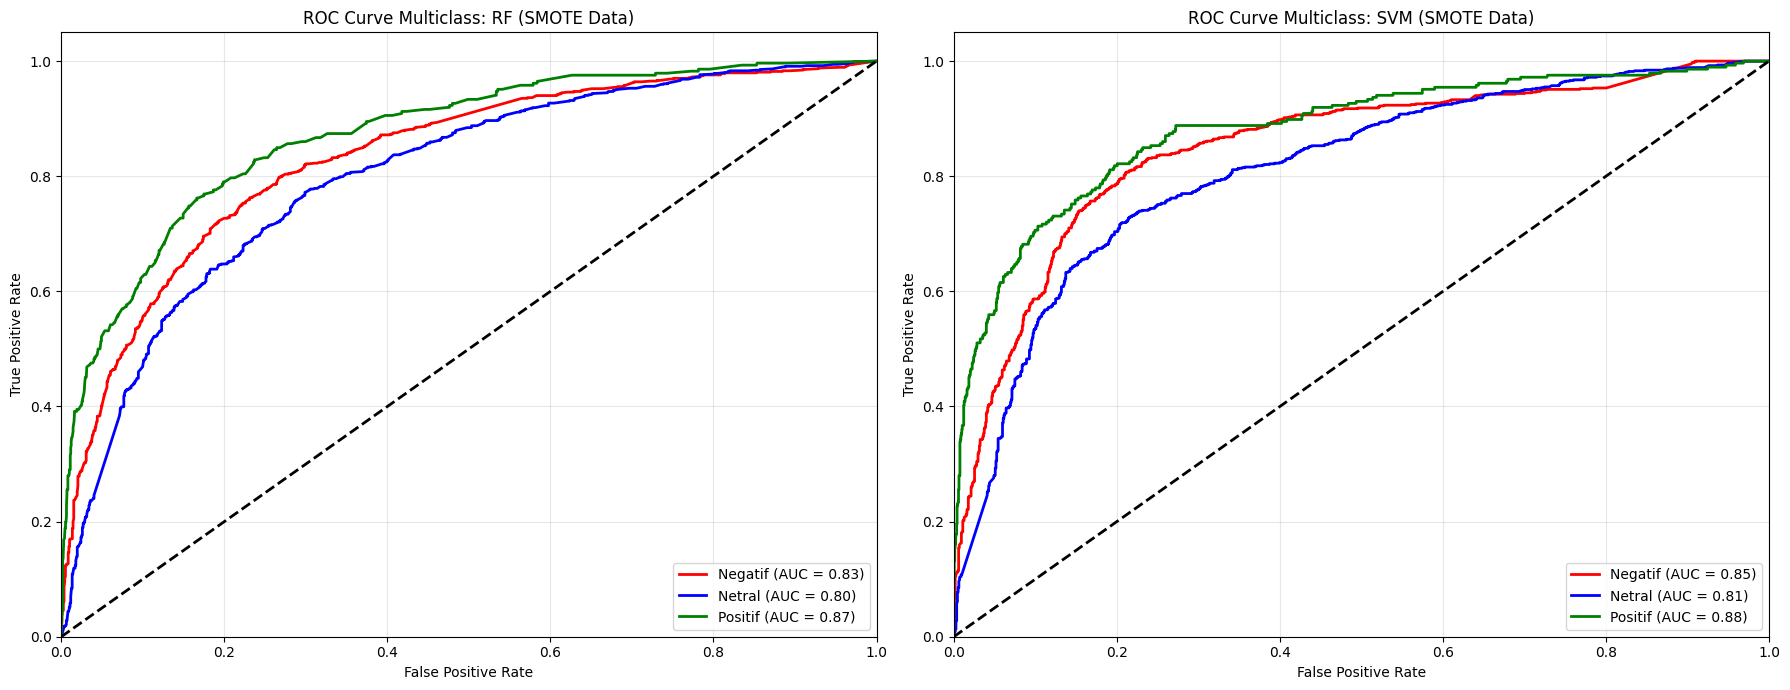

In [ ]:
models = [rf_smote, svm_smote]
model_names = ["RF (SMOTE Data)", "SVM (SMOTE Data)"]
n_classes = 3  # Jumlah kelas: positif, negatif, netral

plot_multiclass_roc_side_by_side(models, x_test_tfidf, y_test_enc, n_classes, model_names)

## **10.4 Rangkuman Akhir Evaluasi Model**

<font color="yellow">**HASIL AKHIR:**</font> Model dengan dengan <font color="red">**menerapkan metode SMOTE**</font> pada data yang digunakan, memberikan hasil yang <font color="red">**lebih baik**</font> terhadap model <font color="red"> **dari pada data yang tidak menerapkan metode SMOTE (Original data)**</font>.

<font color="yellow">**TINDAK LANJUT:**</font>  Kedepannya, <font color="red">**model akan menggunakan data yang telah di SMOTE**</font> sebagai data yang akan digunakan untuk pelatihan dan pengujian lebih lanjut, <font color="red">**karena hasil yang diberikan lebih baik**</font>.

### **10.3.1 (SMOTE) <font color="lightgreen"> RF </font>**

In [ ]:
try:
    cv_results = smote_rf["RF (SMOTE)"]
    acc_score_rf = cv_results['accuracy']
    pre_score_rf = cv_results['precision_macro']
    rec_score_rf = cv_results['recall_macro']
    f_score_rf = cv_results['f1_macro']

    print("="*50)
    print("SUMMARYS RANDOM FOREST WITH SMOTE DATA")
    print("="*50)

    # Accuracy metrics
    rf_test_acc_smote = accuracy_score(y_test_enc, rf_y_pred_smote)
    rf_train_acc_smote = acc_score_rf.mean()

    # F1 macro metrics
    rf_test_f1_smote = f1_score(y_test_enc, rf_y_pred_smote, average='macro')
    rf_train_f1_smote = f_score_rf.mean()

    print(f"Training Accuracy (CV mean): {rf_train_acc_smote:.4f} ({rf_train_acc_smote*100:.2f}%)")
    print(f"Testing Accuracy: {rf_test_acc_smote:.4f} ({rf_test_acc_smote*100:.2f}%)")
    print(f"Accuracy Gap (Training - Testing): {(rf_train_acc_smote - rf_test_acc_smote):.4f} ({(rf_train_acc_smote - rf_test_acc_smote)*100:.2f}%)")

    print(f"\nTraining F1 Macro (CV mean): {rf_train_f1_smote:.4f} ({rf_train_f1_smote*100:.2f}%)")
    print(f"Testing F1 Macro: {rf_test_f1_smote:.4f} ({rf_test_f1_smote*100:.2f}%)")
    print(f"F1 Macro Gap (Training - Testing): {(rf_train_f1_smote - rf_test_f1_smote):.4f} ({(rf_train_f1_smote - rf_test_f1_smote)*100:.2f}%)")

    print('\nTraining Evaluation via Cross-Validation (RF + SMOTE)')
    print('-' * 50)
    print('{:<12} | {:<25} | {:>8}'.format('Metric', 'Value (CV Mean)', 'Percent'))
    print('-' * 50)
    print('{:<12} | {:<25} | {:>7.2f}%'.format('Accuracy', acc_score_rf.mean(), acc_score_rf.mean() * 100))
    print('{:<12} | {:<25} | {:>7.2f}%'.format('Precision', pre_score_rf.mean(), pre_score_rf.mean() * 100))
    print('{:<12} | {:<25} | {:>7.2f}%'.format('Recall', rec_score_rf.mean(), rec_score_rf.mean() * 100))
    print('{:<12} | {:<25} | {:>7.2f}%'.format('F1-Score', f_score_rf.mean(), f_score_rf.mean() * 100))
    print('-' * 50)

    # Gap Analysis Summary
    print('\nGap Analysis (Training vs Testing)')
    print('-' * 53)
    print('{:<12} | {:<10} | {:<10} | {:<10} |'.format('Metric', 'Training', 'Testing', 'Gap'))
    print('-' * 53)
    print('{:<12} | {:<10f} | {:<10f} | {:<10f} |'.format('Accuracy', rf_train_acc_smote, rf_test_acc_smote, rf_train_acc_smote - rf_test_acc_smote))
    print('{:<12} | {:<10f} | {:<10f} | {:<10f} |'.format('F1 Macro', rf_train_f1_smote, rf_test_f1_smote, rf_train_f1_smote - rf_test_f1_smote))
    print('-' * 53)

    print("="*55)

    print("\nTesting Classification Report (RF + SMOTE):")
    print(classification_report(y_test_enc, rf_y_pred_smote))

except KeyError as e:
    print(f"Error: Missing key in data - {e}")
    print("Please check if 'RF (SMOTE)' exists in smote_rf dictionary")
    print("Available keys:", list(smote_rf.keys()) if 'smote_rf' in locals() else "smote_rf not defined")

except NameError as e:
    print(f"Error: Variable not defined - {e}")
    print("Please ensure all required variables are defined:")
    print("- smote_rf, y_test_enc, rf_y_pred_smote")
    print("Also make sure to import: from sklearn.metrics import f1_score")

except AttributeError as e:
    print(f"Error: Attribute error - {e}")
    print("Please check if the cross-validation results have the expected structure")

except Exception as e:
    print(f"Unexpected error occurred: {type(e).__name__}: {e}")
    print("Please check your data and variable definitions")

SUMMARYS RANDOM FOREST WITH SMOTE DATA
Training Accuracy (CV mean): 0.7469 (74.69%)
Testing Accuracy: 0.6894 (68.94%)
Accuracy Gap (Training - Testing): 0.0576 (5.76%)

Training F1 Macro (CV mean): 0.7557 (75.57%)
Testing F1 Macro: 0.6629 (66.29%)
F1 Macro Gap (Training - Testing): 0.0927 (9.27%)

Training Evaluation via Cross-Validation (RF + SMOTE)
--------------------------------------------------
Metric       | Value (CV Mean)           |  Percent
--------------------------------------------------
Accuracy     | 0.7469148936170213        |   74.69%
Precision    | 0.7556781540739743        |   75.57%
Recall       | 0.7566585170278979        |   75.67%
F1-Score     | 0.755651096006537         |   75.57%
--------------------------------------------------

Gap Analysis (Training vs Testing)
-----------------------------------------------------
Metric       | Training   | Testing    | Gap        |
-----------------------------------------------------
Accuracy     | 0.746915   | 0.689364

**<font color="yellow"> NOTE: </font>** Saya menginterpretasikan bahwa model yang terindikasi overfitting memiliki nilai selisih atau GAP antara data latih (train) serta data uji (test) dengan nilai sama dengan diatas 0.1 (10%).

### **10.3.2 (SMOTE) <font color="red"> SVM </font>**

In [ ]:
try:
    cv_results = smote_svm["SVM (SMOTE)"]
    acc_score_svm = cv_results['accuracy']
    pre_score_svm = cv_results['precision_macro']
    rec_score_svm = cv_results['recall_macro']
    f_score_svm = cv_results['f1_macro']

    print("="*50)
    print("SUMMARYS SVM WITH SMOTE DATA")
    print("="*50)

    # Accuracy metrics
    svm_test_acc_smote = accuracy_score(y_test_enc, svm_y_pred_smote)
    svm_train_acc_smote = acc_score_svm.mean()

    # F1 macro metrics
    svm_test_f1_smote = f1_score(y_test_enc, svm_y_pred_smote, average='macro')
    svm_train_f1_smote = f_score_svm.mean()

    print(f"Training Accuracy (CV mean): {svm_train_acc_smote:.4f} ({svm_train_acc_smote*100:.2f}%)")
    print(f"Testing Accuracy: {svm_test_acc_smote:.4f} ({svm_test_acc_smote*100:.2f}%)")
    print(f"Accuracy Gap (Training - Testing): {(svm_train_acc_smote - svm_test_acc_smote):.4f} ({(svm_train_acc_smote - svm_test_acc_smote)*100:.2f}%)")

    print(f"\nTraining F1 Macro (CV mean): {svm_train_f1_smote:.4f} ({svm_train_f1_smote*100:.2f}%)")
    print(f"Testing F1 Macro: {svm_test_f1_smote:.4f} ({svm_test_f1_smote*100:.2f}%)")
    print(f"F1 Macro Gap (Training - Testing): {(svm_train_f1_smote - svm_test_f1_smote):.4f} ({(svm_train_f1_smote - svm_test_f1_smote)*100:.2f}%)")

    print('\nTraining Evaluation via Cross-Validation (SVM + SMOTE)')
    print('-' * 50)
    print('{:<12} | {:<25} | {:>8}'.format('Metric', 'Value (CV Mean)', 'Percent'))
    print('-' * 50)
    print('{:<12} | {:<25} | {:>7.2f}%'.format('Accuracy', acc_score_svm.mean(), acc_score_svm.mean() * 100))
    print('{:<12} | {:<25} | {:>7.2f}%'.format('Precision', pre_score_svm.mean(), pre_score_svm.mean() * 100))
    print('{:<12} | {:<25} | {:>7.2f}%'.format('Recall', rec_score_svm.mean(), rec_score_svm.mean() * 100))
    print('{:<12} | {:<25} | {:>7.2f}%'.format('F1-Score', f_score_svm.mean(), f_score_svm.mean() * 100))
    print('-' * 50)

    # Gap Analysis Summary
    print('\nGap Analysis (Training vs Testing)')
    print('-' * 53)
    print('{:<12} | {:<10} | {:<10} | {:<10} |'.format('Metric', 'Training', 'Testing', 'Gap'))
    print('-' * 53)
    print('{:<12} | {:<10f} | {:<10f} | {:<10f} |'.format('Accuracy', svm_train_acc_smote, svm_test_acc_smote, svm_train_acc_smote - svm_test_acc_smote))
    print('{:<12} | {:<10f} | {:<10f} | {:<10f} |'.format('F1 Macro', svm_train_f1_smote, svm_test_f1_smote, svm_train_f1_smote - svm_test_f1_smote))
    print('-' * 53)

    print("="*55)

    print("\nTesting Classification Report (SVM + SMOTE):")
    print(classification_report(y_test_enc, svm_y_pred_smote))

except KeyError as e:
    print(f"Error: Missing key in data - {e}")
    print("Please check if 'SVM (SMOTE)' exists in smote_svm dictionary")
    print("Available keys:", list(smote_svm.keys()) if 'smote_svm' in locals() else "smote_svm not defined")

except NameError as e:
    print(f"Error: Variable not defined - {e}")
    print("Please ensure all required variables are defined:")
    print("- smote_svm, y_test_enc, svm_y_pred_smote")
    print("Also make sure to import: from sklearn.metrics import f1_score")

except AttributeError as e:
    print(f"Error: Attribute error - {e}")
    print("Please check if the cross-validation results have the expected structure")

except Exception as e:
    print(f"Unexpected error occurred: {type(e).__name__}: {e}")
    print("Please check your data and variable definitions")

SUMMARYS SVM WITH SMOTE DATA
Training Accuracy (CV mean): 0.7446 (74.46%)
Testing Accuracy: 0.7281 (72.81%)
Accuracy Gap (Training - Testing): 0.0164 (1.64%)

Training F1 Macro (CV mean): 0.7535 (75.35%)
Testing F1 Macro: 0.6984 (69.84%)
F1 Macro Gap (Training - Testing): 0.0551 (5.51%)

Training Evaluation via Cross-Validation (SVM + SMOTE)
--------------------------------------------------
Metric       | Value (CV Mean)           |  Percent
--------------------------------------------------
Accuracy     | 0.7445744680851064        |   74.46%
Precision    | 0.7715727383338854        |   77.16%
Recall       | 0.7437120177739323        |   74.37%
F1-Score     | 0.7535412038425553        |   75.35%
--------------------------------------------------

Gap Analysis (Training vs Testing)
-----------------------------------------------------
Metric       | Training   | Testing    | Gap        |
-----------------------------------------------------
Accuracy     | 0.744574   | 0.728131   | 0.01

**<font color="yellow"> NOTE: </font>** Saya menginterpretasikan bahwa model yang terindikasi overfitting memiliki nilai selisih atau GAP antara data latih (train) serta data uji (test) dengan nilai sama dengan diatas 0.1 (10%)

### **10.3.3 Classification Report for SMOTE Models**

In [ ]:
report_rf = classification_report(y_test_enc, rf_y_pred_smote, target_names=['Negatif', 'Netral', 'Positif'], output_dict=True)
report_svm = classification_report(y_test_enc, svm_y_pred_smote, target_names=['Negatif', 'Netral', 'Positif'], output_dict=True)

df = pd.DataFrame({
    'Sentimen': ['Negatif', 'Netral', 'Positif', 'Macro Avg'],
    'RF-Precision': [
        report_rf['Negatif']['precision'],
        report_rf['Netral']['precision'],
        report_rf['Positif']['precision'],
        report_rf['macro avg']['precision']
    ],
    'RF-Recall': [
        report_rf['Negatif']['recall'],
        report_rf['Netral']['recall'],
        report_rf['Positif']['recall'],
        report_rf['macro avg']['recall']
    ],
    'RF-F1': [
        report_rf['Negatif']['f1-score'],
        report_rf['Netral']['f1-score'],
        report_rf['Positif']['f1-score'],
        report_rf['macro avg']['f1-score']
    ],
    'SVM-Precision': [
        report_svm['Negatif']['precision'],
        report_svm['Netral']['precision'],
        report_svm['Positif']['precision'],
        report_svm['macro avg']['precision']
    ],
    'SVM-Recall': [
        report_svm['Negatif']['recall'],
        report_svm['Netral']['recall'],
        report_svm['Positif']['recall'],
        report_svm['macro avg']['recall']
    ],
    'SVM-F1': [
        report_svm['Negatif']['f1-score'],
        report_svm['Netral']['f1-score'],
        report_svm['Positif']['f1-score'],
        report_svm['macro avg']['f1-score']
    ]
})

cr = df.round(4)  # Menggunakan 4 decimal places untuk konsistensi dengan output CV
cr.set_index('Sentimen', inplace=True)

print("="*80)
print("CLASSIFICATION REPORT FOR RF AND SVM (SMOTE DATA)".center(80))
print("="*80)

try:
    display(cr)
except NameError:
    print(cr.to_string())

print("="*80)

               CLASSIFICATION REPORT FOR RF AND SVM (SMOTE DATA)                


RF-Precision  RF-Recall   RF-F1  SVM-Precision  SVM-Recall  SVM-F1
Sentimen                                                                     
Negatif          0.7278     0.6886  0.7077         0.7462      0.7605  0.7533
Netral           0.6870     0.7318  0.7087         0.7095      0.7677  0.7375
Positif          0.5861     0.5594  0.5725         0.7411      0.5105  0.6046
Macro Avg        0.6670     0.6599  0.6629         0.7323      0.6795  0.6984

# **11. Hyperparameter Tuning (HPT)**

## **11.1 Tuning For SVM**

In [ ]:
def save_svm_results(svm_model, svm_params, svm_study, svm_total_time, svm_test_accuracy, svm_test_f1,
                     svm_cv_accuracy, svm_cv_f1, model_name="SVM", tuning_number=3):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"
        os.makedirs(base_path, exist_ok=True)

        # Save study
        svm_study_file_path = os.path.join(base_path, "svm_study.pkl")
        with open(svm_study_file_path, "wb") as f:
            pickle.dump(svm_study, f)

        # Save model
        svm_model_file_path = os.path.join(base_path, "svm_best_model.joblib")
        joblib.dump(svm_model, svm_model_file_path)

        # Save parameters
        svm_best_params_file_path = os.path.join(base_path, "svm_best_params.pkl")
        with open(svm_best_params_file_path, "wb") as f:
            pickle.dump(svm_params, f)

        # Save additional metrics - termasuk accuracy
        additional_metrics = {
            'svm_total_time': svm_total_time,
            'svm_test_accuracy': svm_test_accuracy,
            'svm_test_f1': svm_test_f1,
            'svm_cv_accuracy': svm_cv_accuracy,
            'svm_cv_f1': svm_cv_f1,
            'model_name': model_name,
            'tuning_number': tuning_number
        }
        additional_metrics_path = os.path.join(base_path, "svm_additional_metrics.pkl")
        with open(additional_metrics_path, "wb") as f:
            pickle.dump(additional_metrics, f)

        print(f"\n✅ All SVM Tuning-{tuning_number} results saved successfully!")
        print(f"📁 Saved to: {base_path}")
    except Exception as e:
        print(f"❌ Error saving files: {e}")

In [ ]:
def objective_svm(trial, x_train_smote, y_train_smote):

    kernel = 'rbf'

    # Class weight options - fokus pada yang paling menjanjikan
    class_weight_dict = {0: 0.935, 1: 0.875, 2: 1.26}  # Best dari tuning-2
    class_weight_options = [
        class_weight_dict,                   # Best dari tuning-2: class_weight_idx=2
        {0: 0.932, 1: 0.873, 2: 1.265},     # Micro variation 1 - sangat dekat dengan best
        {0: 0.938, 1: 0.877, 2: 1.255},     # Micro variation 2 - sangat dekat dengan best
        {0: 0.930, 1: 0.870, 2: 1.270},     # Micro variation 3 - sedikit lebih ekstrem
        {0: 0.940, 1: 0.878, 2: 1.250},     # Micro variation 4 - balanced approach
    ]
    class_weight_idx = trial.suggest_categorical('class_weight_idx', [0, 1, 2, 3, 4])
    class_weight = class_weight_options[class_weight_idx]

    params = {
        'kernel': kernel,
        # C: Ultra fine-tune around 1.14 (best dari tuning-2)
        'C': trial.suggest_float('C', 0.95, 1.40, log=False),
        'class_weight': class_weight,
        # tol: Ultra fine-tune around 0.00136 (best dari tuning-2)
        'tol': trial.suggest_float('tol', 0.0008, 0.0025, log=True),
        # shrinking: Keep False as optimal
        'shrinking': False,
        # cache_size: Fokus pada nilai optimal dari tuning-2
        'cache_size': trial.suggest_categorical('cache_size', [1200, 1400, 1600, 1800]),
        # max_iter: Fokus pada nilai optimal dari tuning-2
        'max_iter': trial.suggest_categorical('max_iter', [2000, 2500, 3000, 3500]),
        'probability': True,
        'random_state': 42
    }

    # RBF kernel gamma ultra fine-tuning - 'scale' terbaik dari tuning-2
    gamma_type = trial.suggest_categorical('gamma_type', ['scale', 'float'])
    if gamma_type == 'float':
        # Ultra fine-tune gamma sangat dekat dengan 'scale' equivalent
        params['gamma'] = trial.suggest_float('gamma_float', 8e-5, 3e-4, log=True)
    else:
        params['gamma'] = gamma_type

    try:
        svm = SVC(**params)

        # Enhanced CV folds untuk final tuning yang sangat robust
        skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
        f1_scores = []
        accuracy_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_smote, y_train_smote)):
            X_train_fold, X_val_fold = x_train_smote[train_idx], x_train_smote[val_idx]
            y_train_fold, y_val_fold = y_train_smote[train_idx], y_train_smote[val_idx]

            svm.fit(X_train_fold, y_train_fold)
            y_pred = svm.predict(X_val_fold)

            f1 = f1_score(y_val_fold, y_pred, average='macro')
            acc = accuracy_score(y_val_fold, y_pred)

            f1_scores.append(f1)
            accuracy_scores.append(acc)

            # Early reporting untuk pruning - optimal untuk 12-fold CV
            if fold >= 3:
                current_f1_mean = np.mean(f1_scores)
                current_f1_std = np.std(f1_scores) if len(f1_scores) > 1 else 0
                trial.report(current_f1_mean, fold)

                # Prune dengan threshold yang ketat untuk final tuning
                if fold >= 5:
                    if current_f1_mean < 0.735 or current_f1_std > 0.085:
                        if trial.should_prune():
                            raise optuna.TrialPruned()

        mean_f1 = np.mean(f1_scores)
        mean_acc = np.mean(accuracy_scores)

        # Ultra enhanced stability penalty untuk final tuning
        f1_std = np.std(f1_scores)
        acc_std = np.std(accuracy_scores)

        # Lebih ketat stability penalty untuk final result
        stability_penalty = (f1_std * 0.22) + (acc_std * 0.15)

        # Bonus untuk excellent performance
        performance_bonus = 0
        if mean_f1 > 0.775:  # Higher threshold untuk final tuning
            performance_bonus = (mean_f1 - 0.775) * 0.18
        if mean_f1 > 0.785:  # Extra bonus untuk exceptional performance
            performance_bonus += (mean_f1 - 0.785) * 0.12

        # Objective score dengan ultra enhanced penalties dan bonus
        objective_score = mean_f1 - stability_penalty + performance_bonus

        return objective_score

    except optuna.TrialPruned:
        raise
    except Exception as e:
        print(f"Error in trial {trial.number}: {e}")
        return 0.0

In [ ]:
def visualize_svm_study(svm_study, model_name="SVM", save_path=None):
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except OSError:
        plt.style.use('seaborn-whitegrid')  # fallback untuk versi lama
    except:
        plt.style.use('default')  # fallback terakhir

    fig_size = (10, 4.9)

    # --- Plot Optimization History ---
    ax1 = plot_optimization_history(svm_study)
    fig1 = ax1.get_figure()
    fig1.set_size_inches(*fig_size)
    n_trials = len(svm_study.trials)
    trial_numbers = list(range(n_trials))

    # Tentukan interval yang sesuai berdasarkan jumlah trial
    if n_trials <= 10:
        step = 1  # Tampilkan semua trial jika jumlahnya sedikit
    else:
        step = max(1, n_trials // 10)  # Sekitar 10 label pada sumbu x

    # Tetapkan ticks dan labels dengan interval yang ditentukan
    xticks = trial_numbers[::step]
    # Pastikan trial terakhir selalu ditampilkan
    if (n_trials - 1) not in xticks:
        xticks.append(n_trials - 1)

    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    ax1.set_title(f'Optimization History for {model_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel("Trial", fontsize=12)
    ax1.set_ylabel("Objective Value", fontsize=12)
    ax1.legend(loc='best')
    fig1.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        fig1.savefig(os.path.join(save_path, f"{model_name}_optimization_history.png"), dpi=400)
    plt.show()
    print()

    # --- Plot Parameter Importances ---
    svm_param_importances = optuna.importance.get_param_importances(svm_study)
    sorted_svm_params = sorted(svm_param_importances.items(), key=lambda x: x[1])
    svm_params, svm_scores = zip(*sorted_svm_params)

    plt.figure(figsize=fig_size)
    svm_y_pos = range(len(svm_params))
    plt.barh(svm_y_pos, svm_scores, align='center', color='#1f77b4')
    plt.yticks(svm_y_pos, svm_params)
    plt.title(f'Parameter Importances for {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Hyperparameters', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    for i, v in enumerate(svm_scores):
        plt.text(v, i, f' {v:.2f}', va='center')

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f"{model_name}_parameter_importance.png"), dpi=400)
    plt.show()

In [ ]:
def clean_svm_params(params):
    cleaned_params = params.copy()

    # Handle class_weight_idx
    if 'class_weight_idx' in params:
        class_weight_dict = {0: 0.935, 1: 0.875, 2: 1.26}  # Best dari tuning-2
        class_weight_options = [
            class_weight_dict,
            {0: 0.932, 1: 0.873, 2: 1.265},
            {0: 0.938, 1: 0.877, 2: 1.255},
            {0: 0.930, 1: 0.870, 2: 1.270},
            {0: 0.940, 1: 0.878, 2: 1.250},
        ]
        cleaned_params['class_weight'] = class_weight_options[params['class_weight_idx']]
        cleaned_params.pop('class_weight_idx', None)

    # Handle RBF gamma parameters
    if 'gamma_type' in params:
        if params['gamma_type'] == 'float' and 'gamma_float' in params:
            cleaned_params['gamma'] = params['gamma_float']
        else:
            cleaned_params['gamma'] = params['gamma_type']

    # Remove auxiliary parameters
    for key in ['gamma_type', 'gamma_float']:
        cleaned_params.pop(key, None)

    return cleaned_params

In [ ]:
def early_stopping_exploration(study, trial):
    if len(study.trials) >= 150:  # Optimal untuk final tuning
        recent_trials = study.trials[-40:]  # Analisis 40 trial terakhir
        recent_values = [t.value for t in recent_trials if t.value is not None]
        if len(recent_values) >= 30:
            improvement = max(recent_values) - min(recent_values)
            mean_recent = np.mean(recent_values)

            # Threshold lebih ketat untuk final tuning
            if improvement < 0.0008 and mean_recent > 0.785:
                print("🛑 Early stopping: Final optimization completed")
                study.stop()

In [ ]:
start_time = time.time()

# Membuat study untuk final tuning dengan parameter ultra-optimized
svm_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(
        seed=42,
        n_startup_trials=15,  # Optimal untuk final tuning
        n_ei_candidates=28,   # Lebih tinggi untuk exploration quality
        multivariate=True,
        warn_independent_sampling=False,
        consider_prior=True,
        prior_weight=1.5,     # Sangat mengandalkan prior knowledge
        consider_magic_clip=True,
        consider_endpoints=True,
        constant_liar=False
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=8,   # Sangat agresif pruning
        n_warmup_steps=3,
        interval_steps=1,
        n_min_trials=4
    )
)

# Final tuning target - 12-fold CV dengan waktu optimal
target_hours = 5.0  # Maksimal waktu untuk final tuning
target_seconds = target_hours * 3600
estimated_time_per_trial = 85  # Lebih lama karena 12-fold CV
estimated_n_trials = min(200, int(target_seconds / estimated_time_per_trial))

print(f"🎯 Memulai FINAL TUNING SVM (Tahap 3)")
print(f"🚀 Target: {estimated_n_trials} trials dalam {target_hours} jam")
print(f"⏱️ Estimasi waktu per trial: {estimated_time_per_trial} detik")

try:
    svm_study.optimize(
        lambda trial: objective_svm(trial, x_train_smote, y_train_smote),
        n_trials=estimated_n_trials,
        n_jobs=-1,
        show_progress_bar=True,
        timeout=target_seconds,
        callbacks=[early_stopping_exploration]
    )
except KeyboardInterrupt:
    print("\n⚠️ Final tuning dihentikan oleh user")
except Exception as e:
    print(f"❌ Error during final tuning: {e}")
    print("Melanjutkan dengan trial yang tersedia...")

end_time = time.time()
svm_total_time = end_time - start_time
svm_total_time_minutes = svm_total_time / 60
svm_total_time_hours = svm_total_time / 3600

print("\n" + "="*120)
print("HASIL FINAL TUNING HYPERPARAMETER TUNING - TAHAP 3")
print("="*120)
print(f"\n⏱️ Durasi Waktu Final Tuning: {svm_total_time_minutes:.2f} menit ({svm_total_time_hours:.2f} jam)")
print(f"📊 Total trials completed: {len(svm_study.trials)}")
print(f"🏆 Best trial number: {svm_study.best_trial.number}")
print(f"🎯 Best F1-macro CV Score: {svm_study.best_value:.4f}")

# Waktu selesai
try:
    wib = pytz.timezone('Asia/Jakarta')
    current_time_wib = datetime.now(wib)
    print(f"🕐 Waktu selesai: {current_time_wib.strftime('%d/%m/%Y %H:%M:%S WIB')}")
except ImportError:
    print(f"🕐 Waktu selesai: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

# Statistik trials
successful_trials = len([t for t in svm_study.trials if t.state == optuna.trial.TrialState.COMPLETE])
pruned_trials = len([t for t in svm_study.trials if t.state == optuna.trial.TrialState.PRUNED])
failed_trials = len([t for t in svm_study.trials if t.state == optuna.trial.TrialState.FAIL])

print(f"\n📈 Statistik Optimisasi:")
print(f"  ✅ Successful trials: {successful_trials}")
print(f"  ✂️ Pruned trials: {pruned_trials}")
print(f"  ❌ Failed trials: {failed_trials}")
print(f"  📊 Success rate: {successful_trials/len(svm_study.trials)*100:.1f}%")

[I 2025-06-21 18:43:36,231] A new study created in memory with name: no-name-b18fd22b-0184-40b2-8fb7-d76bf1def3cc


🎯 Memulai FINAL TUNING SVM (Tahap 3)
🚀 Target: 200 trials dalam 5.0 jam
⏱️ Estimasi waktu per trial: 85 detik


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-21 18:53:22,482] Trial 0 finished with value: 0.7131044074383389 and parameters: {'class_weight_idx': 3, 'C': 1.1334792970772567, 'tol': 0.0015511397781436472, 'cache_size': 1800, 'max_iter': 2000, 'gamma_type': 'scale'}. Best is trial 0 with value: 0.7131044074383389.
[I 2025-06-21 18:56:48,576] Trial 1 finished with value: 0.13994921578105762 and parameters: {'class_weight_idx': 3, 'C': 1.281225867662644, 'tol': 0.001987649237623021, 'cache_size': 1400, 'max_iter': 3500, 'gamma_type': 'float', 'gamma_float': 0.00020315725545288162}. Best is trial 0 with value: 0.7131044074383389.
[I 2025-06-21 19:04:35,684] Trial 2 finished with value: 0.7790961341860858 and parameters: {'class_weight_idx': 0, 'C': 1.2233765256391442, 'tol': 0.0008748555929845866, 'cache_size': 1200, 'max_iter': 3000, 'gamma_type': 'scale'}. Best is trial 2 with value: 0.7790961341860858.
[I 2025-06-21 19:07:22,747] Trial 3 finished with value: 0.7823064342402001 and parameters: {'class_weight_idx': 4, 'C'

In [ ]:
if svm_study.best_trial is not None:
    print("="*80)
    print("PARAMETER TERBAIK - FINAL TUNING TAHAP 3")
    print("="*80)
    print("\n📋 Raw parameters dari final tuning:")
    for key, value in svm_study.best_params.items():
        print(f"  - {key}: {value}")

    # Clean parameters
    svm_best_params = clean_svm_params(svm_study.best_params)

    print("\n✅ Final cleaned parameters:")
    for key, value in svm_best_params.items():
        print(f"  - {key}: {value}")

    # Analisis class weight yang terpilih
    selected_class_weight = svm_best_params.get('class_weight')
    if selected_class_weight == {0: 0.935, 1: 0.875, 2: 1.26}:
        print("\n🏷️ Class weight strategy: Best dari tuning-2 (Optimal)")
    else:
        print(f"\n🏷️ Class weight strategy: Micro-tuned variation - {selected_class_weight}")

    # Validasi parameter
    print("\n🔍 Validasi parameter...")
    try:
        test_svm = SVC(**svm_best_params)
        print("✅ Parameter valid untuk SVM!")
    except Exception as e:
        print(f"❌ Parameter validation error: {e}")
        # Fallback parameters dari tuning-2
        svm_best_params = {
            'kernel': 'rbf',
            'C': 1.14362708430968,
            'gamma': 'scale',
            'class_weight': {0: 0.935, 1: 0.875, 2: 1.26},
            'tol': 0.0013550435322463544,
            'cache_size': 1400,
            'max_iter': 2500,
            'shrinking': False,
            'probability': True,
            'random_state': 42
        }
        print("🔧 Menggunakan parameter terbaik dari tuning-2 sebagai fallback")
else:
    print("\n❌ FINAL TUNING GAGAL - Menggunakan parameter dari tuning-2")
    svm_best_params = {
        'kernel': 'rbf',
        'C': 1.14362708430968,
        'gamma': 'scale',
        'class_weight': {0: 0.935, 1: 0.875, 2: 1.26},
        'tol': 0.0013550435322463544,
        'cache_size': 1400,
        'max_iter': 2500,
        'shrinking': False,
        'probability': True,
        'random_state': 42
    }

PARAMETER TERBAIK - FINAL TUNING TAHAP 3

📋 Raw parameters dari final tuning:
  - class_weight_idx: 3
  - C: 1.12491369134423
  - tol: 0.0022065214206400054
  - cache_size: 1200
  - max_iter: 2500
  - gamma_type: scale

✅ Final cleaned parameters:
  - C: 1.12491369134423
  - tol: 0.0022065214206400054
  - cache_size: 1200
  - max_iter: 2500
  - class_weight: {0: 0.93, 1: 0.87, 2: 1.27}
  - gamma: scale

🏷️ Class weight strategy: Micro-tuned variation - {0: 0.93, 1: 0.87, 2: 1.27}

🔍 Validasi parameter...
✅ Parameter valid untuk SVM!


In [ ]:
print("="*80)
print("EVALUASI MODEL DENGAN PARAMETER FINAL TUNED")
print("="*80)

tuning_number_save = 3  # Ini adalah tuning tahap 3 (final)

try:
    # Train final model
    print("🚀 Training model dengan parameter final tuned...")
    svm_best_model = SVC(**svm_best_params)
    svm_best_model.fit(x_train_smote, y_train_smote)

    # Cross-validation evaluation
    print("🔄 Evaluasi cross-validation...")
    skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
    cv_f1_scores = []
    cv_accuracy_scores = []

    for train_idx, val_idx in skf.split(x_train_smote, y_train_smote):
        X_train_fold, X_val_fold = x_train_smote[train_idx], x_train_smote[val_idx]
        y_train_fold, y_val_fold = y_train_smote[train_idx], y_train_smote[val_idx]

        temp_svm = SVC(**svm_best_params)
        temp_svm.fit(X_train_fold, y_train_fold)
        y_pred_cv = temp_svm.predict(X_val_fold)

        cv_f1_scores.append(f1_score(y_val_fold, y_pred_cv, average='macro'))
        cv_accuracy_scores.append(accuracy_score(y_val_fold, y_pred_cv))

    svm_cv_f1 = np.mean(cv_f1_scores)
    svm_cv_accuracy = np.mean(cv_accuracy_scores)
    svm_cv_f1_std = np.std(cv_f1_scores)
    svm_cv_acc_std = np.std(cv_accuracy_scores)

    # Test evaluation
    print("📊 Evaluasi pada test set...")
    svm_y_pred = svm_best_model.predict(x_test_tfidf)
    svm_test_accuracy = accuracy_score(y_test_enc, svm_y_pred)
    svm_test_f1 = f1_score(y_test_enc, svm_y_pred, average='macro')

    # Results display
    print(f"\n📊 HASIL FINAL TUNING (Tuning Tahap 3):")
    print(f"{'='*50}")
    print(f"Training Results (12-Fold CV):")
    print(f"  📈 CV Accuracy: {svm_cv_accuracy:.4f} ± {svm_cv_acc_std:.4f} ({svm_cv_accuracy*100:.2f}%)")
    print(f"  📈 CV F1-macro: {svm_cv_f1:.4f} ± {svm_cv_f1_std:.4f} ({svm_cv_f1*100:.2f}%)")

    print(f"\nTest Results:")
    print(f"  🎯 Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy*100:.2f}%)")
    print(f"  🎯 Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1*100:.2f}%)")

    # Generalization analysis
    accuracy_gap = svm_cv_accuracy - svm_test_accuracy
    f1_gap = svm_cv_f1 - svm_test_f1

    print(f"\n🔍 Analisis Generalisasi:")
    print(f"  📊 Accuracy gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap*100:.2f}%)")
    print(f"  📊 F1-macro gap (CV - Test): {f1_gap:.4f} ({f1_gap*100:.2f}%)")

    # Comparison with ALL previous results
    print(f"\n📈 PERBANDINGAN LENGKAP SEMUA TUNING:")
    print(f"{'='*70}")

    # Baseline
    baseline_test_acc = 0.7281
    baseline_test_f1 = 0.6984
    baseline_gap_f1 = 0.0551

    # Tuning-1 results
    tuning1_test_acc = 0.7177
    tuning1_test_f1 = 0.6907
    tuning1_gap_f1 = 0.0956

    # Tuning-2 results
    tuning2_test_acc = 0.7232
    tuning2_test_f1 = 0.6947
    tuning2_gap_f1 = 0.0913

    print(f"Baseline Test Results:")
    print(f"  Accuracy: {baseline_test_acc:.4f} ({baseline_test_acc*100:.2f}%)")
    print(f"  F1-macro: {baseline_test_f1:.4f} ({baseline_test_f1*100:.2f}%)")
    print(f"  Overfitting (F1 gap): {baseline_gap_f1:.4f} ({baseline_gap_f1*100:.2f}%)")

    print(f"\nTuning-1 Test Results:")
    print(f"  Accuracy: {tuning1_test_acc:.4f} ({tuning1_test_acc*100:.2f}%)")
    print(f"  F1-macro: {tuning1_test_f1:.4f} ({tuning1_test_f1*100:.2f}%)")
    print(f"  Overfitting (F1 gap): {tuning1_gap_f1:.4f} ({tuning1_gap_f1*100:.2f}%)")

    print(f"\nTuning-2 Test Results:")
    print(f"  Accuracy: {tuning2_test_acc:.4f} ({tuning2_test_acc*100:.2f}%)")
    print(f"  F1-macro: {tuning2_test_f1:.4f} ({tuning2_test_f1*100:.2f}%)")
    print(f"  Overfitting (F1 gap): {tuning2_gap_f1:.4f} ({tuning2_gap_f1*100:.2f}%)")

    print(f"\nFinal Tuning-3 Test Results:")
    print(f"  Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy*100:.2f}%)")
    print(f"  F1-macro: {svm_test_f1:.4f} ({svm_test_f1*100:.2f}%)")
    print(f"  Overfitting (F1 gap): {f1_gap:.4f} ({f1_gap*100:.2f}%)")

    # Improvement analysis
    final_vs_baseline_acc = (svm_test_accuracy - baseline_test_acc) * 100
    final_vs_baseline_f1 = (svm_test_f1 - baseline_test_f1) * 100
    final_vs_tuning2_acc = (svm_test_accuracy - tuning2_test_acc) * 100
    final_vs_tuning2_f1 = (svm_test_f1 - tuning2_test_f1) * 100

    print(f"\n🎯 IMPROVEMENT ANALYSIS:")
    print(f"Final Tuning-3 vs Baseline:")
    print(f"  Accuracy improvement: {final_vs_baseline_acc:+.2f}%")
    print(f"  F1-macro improvement: {final_vs_baseline_f1:+.2f}%")

    print(f"\nFinal Tuning-3 vs Tuning-2:")
    print(f"  Accuracy improvement: {final_vs_tuning2_acc:+.2f}%")
    print(f"  F1-macro improvement: {final_vs_tuning2_f1:+.2f}%")

    print(f"\n📋 Classification Report Detail:")
    print(classification_report(y_test_enc, svm_y_pred))
    print("Note: 0 → 'negatif' | 1 → 'netral' | 2 → 'positif'")

    print(f"\n💾 Menyimpan hasil final tuning...")
    save_svm_results(
        svm_model=svm_best_model,
        svm_params=svm_best_params,
        svm_study=svm_study,
        svm_total_time=svm_total_time,
        svm_test_accuracy=svm_test_accuracy,
        svm_test_f1=svm_test_f1,
        svm_cv_accuracy=svm_cv_accuracy,
        svm_cv_f1=svm_cv_f1,
        model_name="SVM_Final_Tuning",
        tuning_number=tuning_number_save
    )

except Exception as e:
    print(f"❌ Error during final tuning evaluation: {e}")
    import traceback
    traceback.print_exc()

EVALUASI MODEL DENGAN PARAMETER FINAL TUNED
🚀 Training model dengan parameter final tuned...
🔄 Evaluasi cross-validation...
📊 Evaluasi pada test set...

📊 HASIL FINAL TUNING (Tuning Tahap 3):
Training Results (12-Fold CV):
  📈 CV Accuracy: 0.7752 ± 0.0113 (77.52%)
  📈 CV F1-macro: 0.7862 ± 0.0105 (78.62%)

Test Results:
  🎯 Test Accuracy: 0.7242 (72.42%)
  🎯 Test F1-macro: 0.6967 (69.67%)

🔍 Analisis Generalisasi:
  📊 Accuracy gap (CV - Test): 0.0511 (5.11%)
  📊 F1-macro gap (CV - Test): 0.0895 (8.95%)

📈 PERBANDINGAN LENGKAP SEMUA TUNING:
Baseline Test Results:
  Accuracy: 0.7281 (72.81%)
  F1-macro: 0.6984 (69.84%)
  Overfitting (F1 gap): 0.0551 (5.51%)

Tuning-1 Test Results:
  Accuracy: 0.7177 (71.77%)
  F1-macro: 0.6907 (69.07%)
  Overfitting (F1 gap): 0.0956 (9.56%)

Tuning-2 Test Results:
  Accuracy: 0.7232 (72.32%)
  F1-macro: 0.6947 (69.47%)
  Overfitting (F1 gap): 0.0913 (9.13%)

Final Tuning-3 Test Results:
  Accuracy: 0.7242 (72.42%)
  F1-macro: 0.6967 (69.67%)
  Overfittin

**Section 3: Visualization of Optimization Results & Parameter Importance**

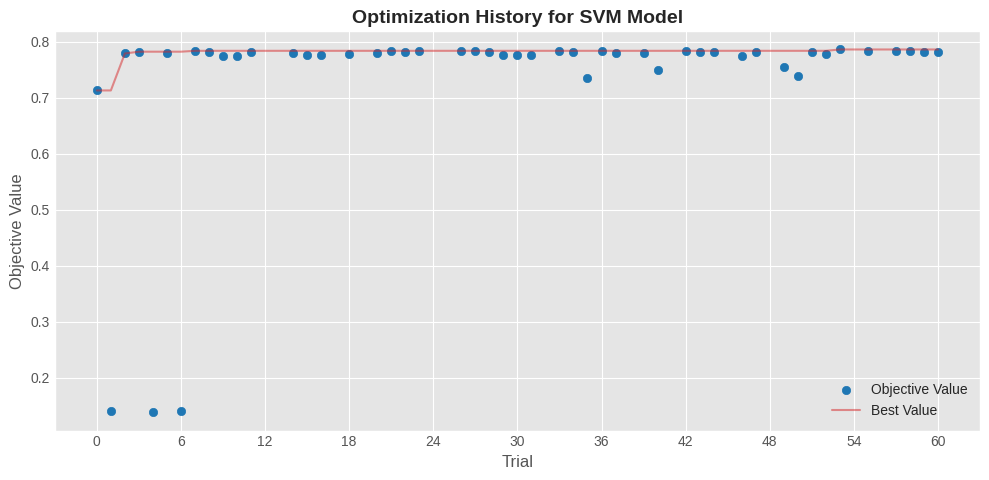

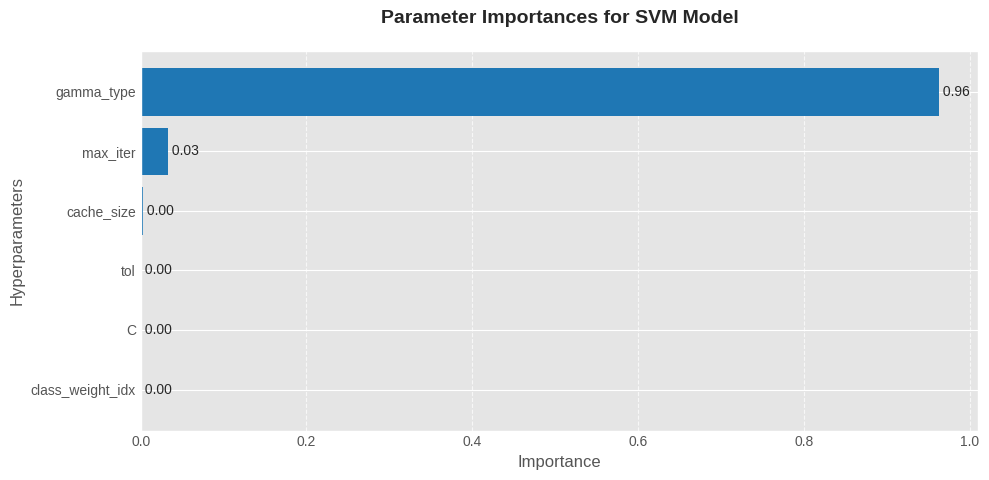

In [ ]:
save_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number_save}/SVM Picture/"
visualize_svm_study(svm_study, model_name="SVM Model", save_path=save_path)

## **11.2 Tuning For RF**

In [ ]:
def save_rf_results(rf_model, rf_params, rf_study, rf_total_time, rf_test_accuracy, rf_test_f1,
                    rf_cv_accuracy, rf_cv_f1, model_name="Random Forest", tuning_number=3):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"
        os.makedirs(base_path, exist_ok=True)

        # Save study
        rf_study_file_path = os.path.join(base_path, "rf_study.pkl")
        with open(rf_study_file_path, "wb") as f:
            pickle.dump(rf_study, f)

        # Save model
        rf_model_file_path = os.path.join(base_path, "rf_best_model.joblib")
        joblib.dump(rf_model, rf_model_file_path)

        # Save parameters
        rf_best_params_file_path = os.path.join(base_path, "rf_best_params.pkl")
        with open(rf_best_params_file_path, "wb") as f:
            pickle.dump(rf_params, f)

        # Save additional metrics
        additional_metrics = {
            'rf_total_time': rf_total_time,
            'rf_test_accuracy': rf_test_accuracy,
            'rf_test_f1': rf_test_f1,
            'rf_cv_accuracy': rf_cv_accuracy,
            'rf_cv_f1': rf_cv_f1,
            'model_name': model_name,
            'tuning_number': tuning_number
        }
        additional_metrics_path = os.path.join(base_path, "rf_additional_metrics.pkl")
        with open(additional_metrics_path, "wb") as f:
            pickle.dump(additional_metrics, f)

        print(f"\n✅ All Random Forest Tuning-{tuning_number} results saved successfully!")
        print(f"📁 Saved to: {base_path}")
    except Exception as e:
        print(f"❌ Error saving files: {e}")

In [ ]:
def objective_rf(trial, x_train_smote, y_train_smote):
    # Dari hasil tuning ke-2, fokus pada parameter yang menunjukkan performa terbaik
    criterion = trial.suggest_categorical('criterion', ['log_loss', 'entropy'])

    # Class weight options - mempertahankan yang terbaik dari tuning sebelumnya
    class_weight_dict = {0: 0.939, 1: 0.879, 2: 1.253}
    class_weight_options = [
        'balanced_subsample',                # Tetap prioritas utama
        'balanced',
        class_weight_dict,
        {0: 1.0, 1: 1.0, 2: 1.4},
        {0: 0.95, 1: 0.88, 2: 1.3},        # Variasi baru untuk final tuning
    ]
    class_weight_idx = trial.suggest_categorical('class_weight_idx', [0, 1, 2, 3, 4])
    class_weight = class_weight_options[class_weight_idx]

    params = {
        'criterion': criterion,
        # Final tuning n_estimators - lebih sempit di sekitar range optimal
        'n_estimators': trial.suggest_int('n_estimators', 480, 580),  # Tighter around best results

        # Final tuning max_depth - fokus pada range yang menunjukkan stabilitas
        'max_depth': trial.suggest_int('max_depth', 18, 23),  # More focused range

        # Final tuning min_samples_split - range lebih sempit
        'min_samples_split': trial.suggest_int('min_samples_split', 6, 10),  # Narrower range

        # Final tuning min_samples_leaf - tetap di range terbaik
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),  # Keep best range

        'class_weight': class_weight,
        'bootstrap': True,

        # Final tuning max_samples - fokus pada range optimal
        'max_samples': trial.suggest_float('max_samples', 0.84, 0.90),  # Tighter range

        # Final tuning ccp_alpha - lebih presisi di sekitar nilai terbaik
        'ccp_alpha': trial.suggest_float('ccp_alpha', 8e-6, 3e-5, log=True),  # More precise range

        'random_state': 42,
        'n_jobs': -1
    }

    # Final tuning max_features - tambah opsi baru untuk eksplorasi final
    max_features_options = ['log2', 'sqrt', 0.8, 0.9]  # Added float options
    max_features_idx = trial.suggest_categorical('max_features_idx', [0, 1, 2, 3])
    params['max_features'] = max_features_options[max_features_idx]

    try:
        rf = RandomForestClassifier(**params)
        # 12-fold CV as requested for robust evaluation
        skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
        f1_scores = []
        accuracy_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_smote, y_train_smote)):
            X_train_fold, X_val_fold = x_train_smote[train_idx], x_train_smote[val_idx]
            y_train_fold, y_val_fold = y_train_smote[train_idx], y_train_smote[val_idx]

            rf.fit(X_train_fold, y_train_fold)
            y_pred = rf.predict(X_val_fold)

            f1 = f1_score(y_val_fold, y_pred, average='macro')
            acc = accuracy_score(y_val_fold, y_pred)
            f1_scores.append(f1)
            accuracy_scores.append(acc)

            # Early reporting for final tuning - start even earlier
            if fold >= 3:  # Start very early for final tuning
                current_f1_mean = np.mean(f1_scores)
                current_f1_std = np.std(f1_scores) if len(f1_scores) > 1 else 0
                trial.report(current_f1_mean, fold)

                # Very aggressive pruning for final tuning
                if fold >= 4:
                    # Stricter thresholds for final tuning
                    if current_f1_mean < 0.705 or current_f1_std > 0.055:
                        if trial.should_prune():
                            raise optuna.TrialPruned()

        mean_f1 = np.mean(f1_scores)
        mean_acc = np.mean(accuracy_scores)

        # Final tuned penalty system - more refined
        f1_std = np.std(f1_scores)
        acc_std = np.std(accuracy_scores)

        # Refined stability penalty for final tuning
        stability_penalty = (f1_std * 0.06) + (acc_std * 0.04)  # Further reduced for final tuning

        # Refined complexity penalty based on previous results
        complexity_penalty = 0
        if params['max_depth'] > 21:  # Based on best results pattern
            complexity_penalty += 0.002
        if params['n_estimators'] > 550:  # Based on diminishing returns
            complexity_penalty += 0.0015
        if params['min_samples_leaf'] == 1:  # Fine penalty for overfitting risk
            complexity_penalty += 0.0003

        # Bonus for parameters showing good generalization in previous tuning
        generalization_bonus = 0
        if 19 <= params['max_depth'] <= 21:  # Sweet spot from previous results
            generalization_bonus += 0.001
        if 500 <= params['n_estimators'] <= 540:  # Efficiency sweet spot
            generalization_bonus += 0.0005

        # Final objective score with generalization bonus
        objective_score = mean_f1 - stability_penalty - complexity_penalty + generalization_bonus

        return objective_score

    except optuna.TrialPruned:
        raise
    except Exception as e:
        print(f"Error in trial {trial.number}: {e}")
        return 0.0

In [ ]:
def visualize_rf_study(rf_study, model_name="Random Forest", save_path=None):
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except OSError:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('default')

    fig_size = (10, 4.9)

    # --- Plot Optimization History ---
    ax1 = plot_optimization_history(rf_study)
    fig1 = ax1.get_figure()
    fig1.set_size_inches(*fig_size)

    n_trials = len(rf_study.trials)

    # Tentukan jumlah maksimum xticks untuk mencegah penumpukan
    max_xticks = 10
    xticks = np.linspace(0, n_trials - 1, num=max_xticks, dtype=int)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([str(t) for t in xticks])

    ax1.set_title(f'Optimization History for {model_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel("Trial", fontsize=12)
    ax1.set_ylabel("Objective Value", fontsize=12)
    ax1.legend(loc='best')
    fig1.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        fig1.savefig(os.path.join(save_path, f"{model_name}_optimization_history.png"), dpi=400)
    plt.show()
    print()

    # --- Plot Parameter Importances ---
    rf_param_importances = optuna.importance.get_param_importances(rf_study)
    sorted_rf_params = sorted(rf_param_importances.items(), key=lambda x: x[1])
    rf_params, rf_scores = zip(*sorted_rf_params)

    plt.figure(figsize=fig_size)
    rf_y_pos = range(len(rf_params))
    plt.barh(rf_y_pos, rf_scores, align='center', color='#1f77b4')
    plt.yticks(rf_y_pos, rf_params)
    plt.title(f'Parameter Importances for {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Hyperparameters', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    for i, v in enumerate(rf_scores):
        plt.text(v, i, f' {v:.2f}', va='center')

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f"{model_name}_parameter_importance.png"), dpi=400)
    plt.show()

In [ ]:
def early_stopping_exploration_rf(study, trial):
    # More sophisticated early stopping for final tuning
    if len(study.trials) >= 150:  # Start checking earlier
        recent_trials = study.trials[-40:]  # Smaller recent window
        recent_values = [t.value for t in recent_trials if t.value is not None]

        if len(recent_values) >= 30:
            improvement = max(recent_values) - min(recent_values)
            mean_recent = np.mean(recent_values)
            std_recent = np.std(recent_values)

            # Very strict criteria for final tuning
            if improvement < 0.0005 and mean_recent > 0.715 and std_recent < 0.005:
                print("🛑 Early stopping: Random Forest final tuning reached convergence")
                study.stop()

In [ ]:
start_time = time.time()

rf_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(
        seed=42,
        n_startup_trials=50,      # More startup trials for final tuning
        n_ei_candidates=50,       # More candidates for precision
        multivariate=True,
        warn_independent_sampling=False,
        consider_prior=True,
        prior_weight=1.5,         # Higher prior weight for final refinement
        consider_magic_clip=True,
        consider_endpoints=True,
        constant_liar=False
    ),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=25,      # More startup for stability
        n_warmup_steps=5,         # More warmup for 12-fold CV
        interval_steps=1,
        n_min_trials=15           # Higher minimum for robust pruning
    )
)

# 5 hours as requested
target_hours = 5.0
target_seconds = target_hours * 3600

# Adjusted time per trial for 12-fold CV (longer than 10-fold)
estimated_time_per_trial = 65  # Increased due to 12-fold CV
estimated_n_trials = min(400, int(target_seconds / estimated_time_per_trial))

print(f"🚀 Memulai FINAL TUNING (Tahap 3) Random Forest dengan target {estimated_n_trials} trials dalam {target_hours} jam")
print(f"⏱️ Estimasi waktu per trial: {estimated_time_per_trial} detik")
print(f"📊 Menggunakan 12-fold Cross Validation untuk robustness maksimal")
print(f"🎯 Target: Mengoptimalkan generalisasi dan mengurangi overfitting")

try:
    rf_study.optimize(
        lambda trial: objective_rf(trial, x_train_smote, y_train_smote),
        n_trials=estimated_n_trials,
        n_jobs=-1,
        show_progress_bar=True,
        timeout=target_seconds,
        callbacks=[early_stopping_exploration_rf]
    )
except KeyboardInterrupt:
    print("\n⚠️ Optimisasi dihentikan oleh user")
except Exception as e:
    print(f"❌ Error during optimization: {e}")
    print("Melanjutkan dengan trial yang tersedia...")

end_time = time.time()
rf_total_time = end_time - start_time
rf_total_time_minutes = rf_total_time / 60
rf_total_time_hours = rf_total_time / 3600

print("\n" + "="*120)
print("HASIL FINAL TUNING HYPERPARAMETER RANDOM FOREST - TAHAP 3")
print("="*120)
print(f"\n⏱️ Durasi Waktu Tuning: {rf_total_time_minutes:.2f} menit ({rf_total_time_hours:.2f} jam)")
print(f"📊 Total trials completed: {len(rf_study.trials)}")
print(f"🏆 Best trial number: {rf_study.best_trial.number}")
print(f"🎯 Best Objective Score: {rf_study.best_value:.4f}")

# Waktu selesai
try:
    wib = pytz.timezone('Asia/Jakarta')
    current_time_wib = datetime.now(wib)
    print(f"🕐 Waktu selesai: {current_time_wib.strftime('%d/%m/%Y %H:%M:%S WIB')}")
except ImportError:
    print(f"🕐 Waktu selesai: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

# Statistik trials
successful_trials = len([t for t in rf_study.trials if t.state == optuna.trial.TrialState.COMPLETE])
pruned_trials = len([t for t in rf_study.trials if t.state == optuna.trial.TrialState.PRUNED])
failed_trials = len([t for t in rf_study.trials if t.state == optuna.trial.TrialState.FAIL])

print(f"\n📈 Statistik Optimisasi:")
print(f"  ✅ Successful trials: {successful_trials}")
print(f"  ✂️ Pruned trials: {pruned_trials}")
print(f"  ❌ Failed trials: {failed_trials}")
print(f"  📊 Success rate: {successful_trials/len(rf_study.trials)*100:.1f}%")

[I 2025-06-22 12:07:52,258] A new study created in memory with name: no-name-3cc253cc-a395-4e86-bf5c-6323ecf0fb6c


🚀 Memulai FINAL TUNING (Tahap 3) Random Forest dengan target 276 trials dalam 5.0 jam
⏱️ Estimasi waktu per trial: 65 detik
📊 Menggunakan 12-fold Cross Validation untuk robustness maksimal
🎯 Target: Mengoptimalkan generalisasi dan mengurangi overfitting


  0%|          | 0/276 [00:00<?, ?it/s]

[I 2025-06-22 12:09:17,181] Trial 1 finished with value: 0.7109841121344835 and parameters: {'criterion': 'log_loss', 'class_weight_idx': 0, 'n_estimators': 507, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_samples': 0.8658567614411649, 'ccp_alpha': 1.2254438498023057e-05, 'max_features_idx': 0}. Best is trial 1 with value: 0.7109841121344835.
[I 2025-06-22 12:09:37,519] Trial 0 finished with value: 0.6826120393331677 and parameters: {'criterion': 'entropy', 'class_weight_idx': 4, 'n_estimators': 565, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_samples': 0.8659332119860828, 'ccp_alpha': 2.942986295276615e-05, 'max_features_idx': 1}. Best is trial 1 with value: 0.7109841121344835.
[I 2025-06-22 12:10:42,517] Trial 2 finished with value: 0.6809326923944521 and parameters: {'criterion': 'entropy', 'class_weight_idx': 4, 'n_estimators': 512, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_samples': 0.8726434063069735, 'c

In [ ]:
if rf_study.best_trial is not None:
    print("="*80)
    print("PARAMETER TERBAIK - FINAL TUNING TAHAP 3")
    print("="*80)
    rf_best_params = rf_study.best_params.copy()

    # Handle conditional parameters
    if 'class_weight_idx' in rf_best_params:
        class_weight_options = [
            'balanced_subsample',
            'balanced',
            {0: 0.939, 1: 0.879, 2: 1.253},
            {0: 1.0, 1: 1.0, 2: 1.4},
            {0: 0.95, 1: 0.88, 2: 1.3}
        ]
        rf_best_params['class_weight'] = class_weight_options[rf_best_params['class_weight_idx']]
        del rf_best_params['class_weight_idx']

    if 'max_features_idx' in rf_best_params:
        max_features_options = ['log2', 'sqrt', 0.8, 0.9]
        rf_best_params['max_features'] = max_features_options[rf_best_params['max_features_idx']]
        del rf_best_params['max_features_idx']

    # Add fixed parameters
    rf_best_params.update({
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    })

    print("\n✅ Best parameters:")
    for key, value in rf_best_params.items():
        if key not in ['random_state', 'n_jobs']:
            print(f"  - {key}: {value}")

    # Parameter validation
    print("\n🔍 Validasi parameter...")
    try:
        test_rf = RandomForestClassifier(**rf_best_params)
        print("✅ Parameter valid untuk Random Forest!")
    except Exception as e:
        print(f"❌ Parameter validation error: {e}")
        # Enhanced fallback based on tuning 2 results
        rf_best_params = {
            'n_estimators': 520,             # Slight adjustment from previous
            'max_depth': 20,
            'min_samples_split': 7,
            'min_samples_leaf': 1,
            'max_features': 'log2',
            'criterion': 'log_loss',
            'max_samples': 0.87,
            'bootstrap': True,
            'class_weight': 'balanced_subsample',
            'ccp_alpha': 1.2e-05,           # Slight adjustment
            'random_state': 42,
            'n_jobs': -1
        }
        print("🔧 Menggunakan parameter fallback yang dioptimalkan")

PARAMETER TERBAIK - FINAL TUNING TAHAP 3

✅ Best parameters:
  - criterion: log_loss
  - n_estimators: 536
  - max_depth: 21
  - min_samples_split: 7
  - min_samples_leaf: 1
  - max_samples: 0.8989991217407548
  - ccp_alpha: 8.841662026194614e-06
  - class_weight: {0: 0.939, 1: 0.879, 2: 1.253}
  - max_features: log2
  - bootstrap: True

🔍 Validasi parameter...
✅ Parameter valid untuk Random Forest!


In [ ]:
print("="*80)
print("EVALUASI MODEL DENGAN PARAMETER TERBAIK - FINAL TUNING")
print("="*80)

tuning_number_save = 3  # Final tuning

try:
    # Train final model
    print("🚀 Training model dengan parameter terbaik...")
    rf_best_model = RandomForestClassifier(**rf_best_params)
    rf_best_model.fit(x_train_smote, y_train_smote)

    # Cross-validation evaluation dengan 12-fold
    print("🔄 Evaluasi cross-validation dengan 12-fold CV...")
    skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
    cv_f1_scores = []
    cv_accuracy_scores = []

    for train_idx, val_idx in skf.split(x_train_smote, y_train_smote):
        X_train_fold, X_val_fold = x_train_smote[train_idx], x_train_smote[val_idx]
        y_train_fold, y_val_fold = y_train_smote[train_idx], y_train_smote[val_idx]

        temp_rf = RandomForestClassifier(**rf_best_params)
        temp_rf.fit(X_train_fold, y_train_fold)
        y_pred_cv = temp_rf.predict(X_val_fold)

        cv_f1_scores.append(f1_score(y_val_fold, y_pred_cv, average='macro'))
        cv_accuracy_scores.append(accuracy_score(y_val_fold, y_pred_cv))

    rf_cv_f1 = np.mean(cv_f1_scores)
    rf_cv_accuracy = np.mean(cv_accuracy_scores)
    rf_cv_f1_std = np.std(cv_f1_scores)
    rf_cv_acc_std = np.std(cv_accuracy_scores)

    # Test evaluation
    print("📊 Evaluasi pada test set...")
    rf_y_pred = rf_best_model.predict(x_test_tfidf)
    rf_test_accuracy = accuracy_score(y_test_enc, rf_y_pred)
    rf_test_f1 = f1_score(y_test_enc, rf_y_pred, average='macro')

    # Results display
    print(f"\n📊 HASIL FINAL TUNING (Tuning Tahap 3):")
    print(f"{'='*50}")
    print(f"Training Results (12-fold CV):")
    print(f"  📈 CV Accuracy: {rf_cv_accuracy:.4f} ± {rf_cv_acc_std:.4f} ({rf_cv_accuracy*100:.2f}%)")
    print(f"  📈 CV F1-macro: {rf_cv_f1:.4f} ± {rf_cv_f1_std:.4f} ({rf_cv_f1*100:.2f}%)")
    print(f"\nTest Results:")
    print(f"  🎯 Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy*100:.2f}%)")
    print(f"  🎯 Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1*100:.2f}%)")

    # Generalization analysis
    accuracy_gap = rf_cv_accuracy - rf_test_accuracy
    f1_gap = rf_cv_f1 - rf_test_f1
    print(f"\n🔍 Analisis Generalisasi:")
    print(f"  📊 Accuracy gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap*100:.2f}%)")
    print(f"  📊 F1-macro gap (CV - Test): {f1_gap:.4f} ({f1_gap*100:.2f}%)")

    # Comprehensive comparison
    print(f"\n📈 PERBANDINGAN SEMUA TAHAP TUNING:")
    print(f"{'='*60}")
    baseline_test_f1 = 0.6629
    tuning1_test_f1 = 0.6600
    tuning2_test_f1 = 0.6618  # From your results

    tuning2_gap_f1 = 0.0640   # From your results

    f1_improvement_vs_baseline = (rf_test_f1 - baseline_test_f1) * 100
    f1_improvement_vs_tuning1 = (rf_test_f1 - tuning1_test_f1) * 100
    f1_improvement_vs_tuning2 = (rf_test_f1 - tuning2_test_f1) * 100
    gap_improvement_vs_tuning2 = (tuning2_gap_f1 - f1_gap) * 100

    print(f"Baseline Test F1-macro: {baseline_test_f1:.4f} ({baseline_test_f1*100:.2f}%)")
    print(f"Tuning 1 Test F1-macro: {tuning1_test_f1:.4f} ({tuning1_test_f1*100:.2f}%)")
    print(f"Tuning 2 Test F1-macro: {tuning2_test_f1:.4f} ({tuning2_test_f1*100:.2f}%)")
    print(f"Tuning 3 Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1*100:.2f}%)")
    print(f"\nImprovement vs Baseline: {f1_improvement_vs_baseline:+.2f}%")
    print(f"Improvement vs Tuning 1: {f1_improvement_vs_tuning1:+.2f}%")
    print(f"Improvement vs Tuning 2: {f1_improvement_vs_tuning2:+.2f}%")
    print(f"\nOverfitting Analysis:")
    print(f"Tuning 2 Gap: {tuning2_gap_f1:.4f} ({tuning2_gap_f1*100:.2f}%)")
    print(f"Tuning 3 Gap: {f1_gap:.4f} ({f1_gap*100:.2f}%)")
    print(f"Gap improvement vs Tuning 2: {gap_improvement_vs_tuning2:+.2f}%")

    print(f"\n📋 Classification Report Detail:")
    print(classification_report(y_test_enc, rf_y_pred))

    # Save results
    print(f"\n💾 Menyimpan hasil final tuning...")
    save_rf_results(
        rf_model=rf_best_model,
        rf_params=rf_best_params,
        rf_study=rf_study,
        rf_total_time=rf_total_time,
        rf_test_accuracy=rf_test_accuracy,
        rf_test_f1=rf_test_f1,
        rf_cv_accuracy=rf_cv_accuracy,
        rf_cv_f1=rf_cv_f1,
        model_name="Random_Forest_Final_Tuning",
        tuning_number=tuning_number_save
    )

    print("✅ Final Tuning Random Forest selesai!")
    print("🎯 Model siap untuk deployment dengan parameter optimal!")

except Exception as e:
    print(f"❌ Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

EVALUASI MODEL DENGAN PARAMETER TERBAIK - FINAL TUNING
🚀 Training model dengan parameter terbaik...
🔄 Evaluasi cross-validation dengan 12-fold CV...
📊 Evaluasi pada test set...

📊 HASIL FINAL TUNING (Tuning Tahap 3):
Training Results (12-fold CV):
  📈 CV Accuracy: 0.7206 ± 0.0141 (72.06%)
  📈 CV F1-macro: 0.7260 ± 0.0134 (72.60%)

Test Results:
  🎯 Test Accuracy: 0.6849 (68.49%)
  🎯 Test F1-macro: 0.6625 (66.25%)

🔍 Analisis Generalisasi:
  📊 Accuracy gap (CV - Test): 0.0357 (3.57%)
  📊 F1-macro gap (CV - Test): 0.0635 (6.35%)

📈 PERBANDINGAN SEMUA TAHAP TUNING:
Baseline Test F1-macro: 0.6629 (66.29%)
Tuning 1 Test F1-macro: 0.6600 (66.00%)
Tuning 2 Test F1-macro: 0.6618 (66.18%)
Tuning 3 Test F1-macro: 0.6625 (66.25%)

Improvement vs Baseline: -0.04%
Improvement vs Tuning 1: +0.25%
Improvement vs Tuning 2: +0.07%

Overfitting Analysis:
Tuning 2 Gap: 0.0640 (6.40%)
Tuning 3 Gap: 0.0635 (6.35%)
Gap improvement vs Tuning 2: +0.05%

📋 Classification Report Detail:
              precision 

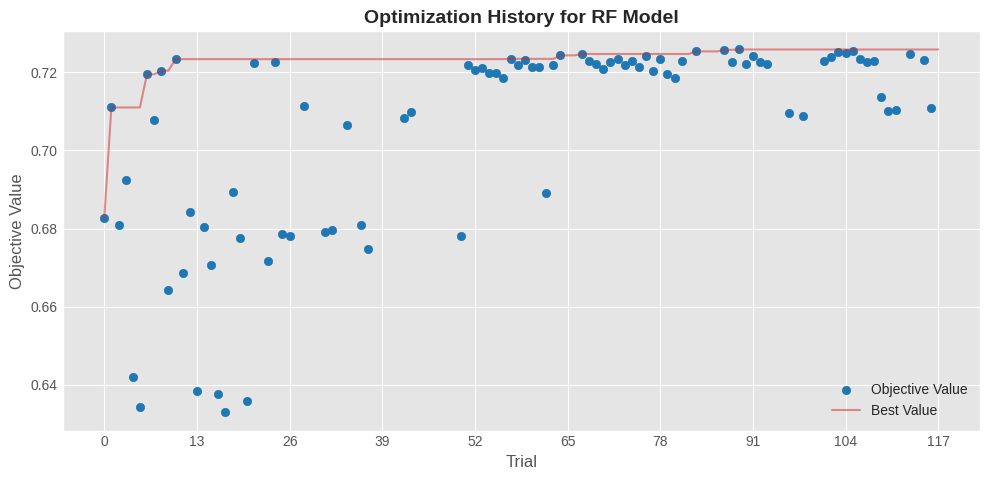

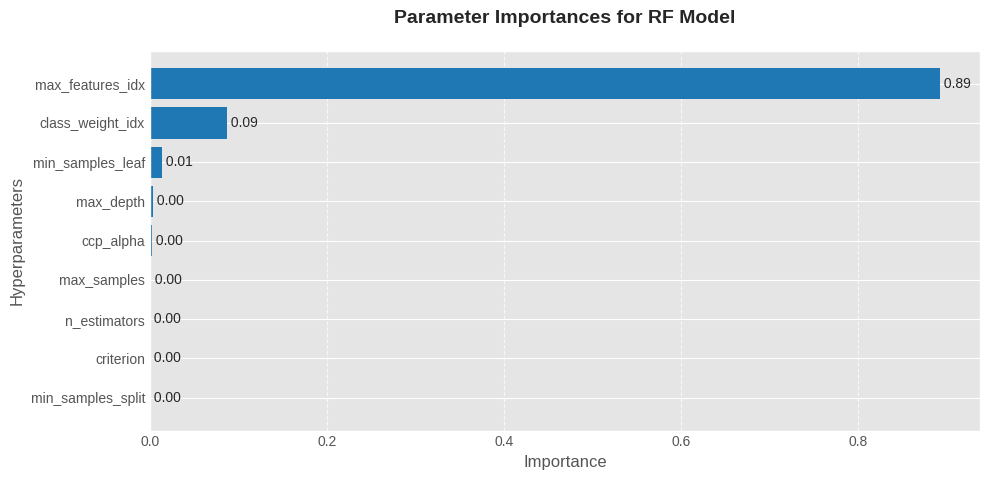

In [ ]:
save_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number_save}/RF Picture/"
visualize_rf_study(rf_study, model_name="RF Model", save_path=save_path)

## **11.3 Summary Hyperparameter Tuning-1 (Exploration)**

### **11.3.1 SVM Tuning Results**

In [ ]:
def load_svm_results_1(tuning_number=1):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"

        # Load study
        svm_study_file_path = os.path.join(base_path, "svm_study.pkl")
        with open(svm_study_file_path, "rb") as f:
            svm_study = pickle.load(f)

        # Load model
        svm_model_file_path = os.path.join(base_path, "svm_best_model.joblib")
        svm_model = joblib.load(svm_model_file_path)

        # Load parameters
        svm_best_params_file_path = os.path.join(base_path, "svm_best_params.pkl")
        with open(svm_best_params_file_path, "rb") as f:
            svm_best_params = pickle.load(f)

        # Load additional metrics - RENAMED TO BE SVM SPECIFIC
        svm_additional_metrics = {}

        try:
            svm_additional_metrics_path = os.path.join(base_path, "svm_additional_metrics.pkl")
            with open(svm_additional_metrics_path, "rb") as f:
                svm_additional_metrics = pickle.load(f)

        except FileNotFoundError:
            print("Note: SVM additional metrics file not found. Some metrics may need to be recalculated.")
        print(f"✅ Successfully loaded SVM Tuning-{tuning_number} results!")
        print(f"📁 Loaded from: {base_path}")

        return svm_model, svm_study, svm_best_params, svm_additional_metrics

    except Exception as e:
        print(f"❌ Error loading SVM Tuning-{tuning_number} results: {e}")
        return None, None, None, None

svm_model, svm_study, svm_best_params, svm_additional_metrics = load_svm_results_1(tuning_number=1)

✅ Successfully loaded SVM Tuning-1 results!
📁 Loaded from: /content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-1/


In [ ]:
def get_class_weight_description_1(class_weight_idx, class_weight_value):
    class_weight_dict = {0: 0.939, 1: 0.879, 2: 1.253}

    class_weight_descriptions = {
        0: ("None (Default)", "Tidak ada penyesuaian weight, semua kelas diperlakukan sama"),
        1: ("Balanced (Auto)", "Sklearn otomatis menghitung weight berdasarkan frekuensi kelas"),
        2: ("SMOTE-derived", f"Weight hasil SMOTE analysis: {class_weight_dict}"),
        3: ("Manual Boost Positif", "Manual weight {0: 1.0, 1: 1.0, 2: 1.5} - boost kelas positif 1.5x"),
        4: ("Manual Boost Tinggi", "Manual weight {0: 1.0, 1: 1.0, 2: 2.0} - boost kelas positif 2x"),
        5: ("Hybrid Manual", "Manual weight {0: 0.9, 1: 0.8, 2: 1.5} - reduce negatif/netral, boost positif")
    }

    if class_weight_idx in class_weight_descriptions:
        strategy_name, strategy_desc = class_weight_descriptions[class_weight_idx]
        return f"{strategy_name}: {strategy_desc}"
    else:
        return f"Custom weight: {class_weight_value}"

In [ ]:
if svm_study is not None:
    # Extract all metrics from SVM additional_metrics
    svm_total_time = svm_additional_metrics.get('svm_total_time', 0)
    svm_test_accuracy = svm_additional_metrics.get('svm_test_accuracy', 0)
    svm_test_f1 = svm_additional_metrics.get('svm_test_f1', 0)
    svm_cv_accuracy = svm_additional_metrics.get('svm_cv_accuracy', 0)
    svm_cv_f1 = svm_additional_metrics.get('svm_cv_f1', 0)
    tuning_number = svm_additional_metrics.get('tuning_number', 1)

    # Check if all SVM metrics are available
    if svm_total_time == 0 or svm_test_accuracy == 0 or svm_test_f1 == 0:
        print("⚠️ Warning: Some SVM metrics are missing. You may need to recalculate test metrics.")

    try:
        print("="*80)
        print(f"FINAL SUMMARY - SUPPORT VECTOR MACHINE HYPERPARAMETER TUNING-{tuning_number} RESULTS")
        print("="*80)
        print(f"Total Waktu Optimization: {svm_total_time/60:.2f} menit ({svm_total_time/3600:.2f} jam)")
        print(f"Total Trial Selesai: {len(svm_study.trials)}")
        print(f"Trial Terbaik: {svm_study.best_trial.number}")

        print("\nBest Hyperparameters:")
        for param, value in svm_study.best_params.items():
            if param == 'class_weight_idx':
                # Get class weight value from best params
                class_weight_value = svm_best_params.get('class_weight', None)
                class_weight_desc = get_class_weight_description_1(value, class_weight_value)
                print(f"  - {param}: {value}")
                print(f"    └── 🏷️ Class Weight: {class_weight_desc}")
            else:
                print(f"  - {param}: {value}")

        # Additional class weight analysis
        if 'class_weight_idx' in svm_study.best_params:
            class_weight_idx = svm_study.best_params['class_weight_idx']
            class_weight_value = svm_best_params.get('class_weight', None)

        print(f"\nPerformance Metrics:")
        print(f"  - Best F1-macro Training: {svm_study.best_value:.4f} ({svm_study.best_value * 100:.2f}%)")
        print()
        print(f"  - CV Accuracy: {svm_cv_accuracy:.4f} ({svm_cv_accuracy * 100:.2f}%)")
        print(f"  - CV F1-macro: {svm_cv_f1:.4f} ({svm_cv_f1 * 100:.2f}%)")
        print()
        print(f"  - Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy * 100:.2f}%)")
        print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")

        # Performance Gap Analysis
        print(f"\nPerformance Gap Analysis:")
        if svm_cv_accuracy > 0 and svm_cv_f1 > 0:
            accuracy_gap = svm_cv_accuracy - svm_test_accuracy
            f1_gap = svm_cv_f1 - svm_test_f1
            print(f"  - CV Accuracy: {svm_cv_accuracy:.4f} ({svm_cv_accuracy * 100:.2f}%)")
            print(f"  - Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy * 100:.2f}%)")
            print(f"  - Accuracy Gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap * 100:.2f}%)")
            print()
            print(f"  - CV F1-macro: {svm_cv_f1:.4f} ({svm_cv_f1 * 100:.2f}%)")
            print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")
            print(f"  - F1-macro Gap (CV - Test): {f1_gap:.4f} ({f1_gap * 100:.2f}%)")
        else:
            # Fallback to study best value vs test
            svm_f1_gap = svm_study.best_value - svm_test_f1
            print(f"  - Training F1-macro: {svm_study.best_value:.4f} ({svm_study.best_value * 100:.2f}%)")
            print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")
            print(f"  - Gap (Training - Test): {svm_f1_gap:.4f} ({svm_f1_gap * 100:.2f}%)")

        print("\n", "="*80)

        # Classification Report
        try:
            svm_y_pred = svm_model.predict(x_test_tfidf)
            print("Detailed Classification Report On Test Data:")
            print(classification_report(y_test_enc, svm_y_pred))
            label_names = ['negatif', 'netral', 'positif']
            label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
            label_info = " | ".join([f"{encoded_val} → '{original_label}'" for encoded_val, original_label in label_mapping.items()])
            print(f"Note: {label_info}")
        except NameError:
            print("⚠️ Warning: x_test_tfidf or y_test_enc not available. Cannot generate classification report.")

        print("="*80)

    except Exception as e:
        print(f"\n⚠️ Error in Final Summary: {e}")
        print("Basic results:")
        print(f"  - Best F1-macro Training: {svm_study.best_value:.4f}")
        print(f"  - Test F1-macro: {svm_test_f1:.4f}")
        print(f"  - Test Accuracy: {svm_test_accuracy:.4f}")
        print(f"  - Best Parameters: {svm_study.best_params}")
else:
    print("❌ Failed to load SVM results. Please check file paths and try again.")

FINAL SUMMARY - SUPPORT VECTOR MACHINE HYPERPARAMETER TUNING-1 RESULTS
Total Waktu Optimization: 303.95 menit (5.07 jam)
Total Trial Selesai: 137
Trial Terbaik: 92

Best Hyperparameters:
  - kernel: rbf
  - class_weight_idx: 2
    └── 🏷️ Class Weight: SMOTE-derived: Weight hasil SMOTE analysis: {0: 0.939, 1: 0.879, 2: 1.253}
  - C: 1.3413413880119973
  - tol: 0.0022263467157175648
  - shrinking: False
  - cache_size: 1200
  - max_iter: 2000
  - gamma_type: scale

Performance Metrics:
  - Best F1-macro Training: 0.7829 (78.29%)

  - CV Accuracy: 0.7753 (77.53%)
  - CV F1-macro: 0.7863 (78.63%)

  - Test Accuracy: 0.7177 (71.77%)
  - Test F1-macro: 0.6907 (69.07%)

Performance Gap Analysis:
  - CV Accuracy: 0.7753 (77.53%)
  - Test Accuracy: 0.7177 (71.77%)
  - Accuracy Gap (CV - Test): 0.0576 (5.76%)

  - CV F1-macro: 0.7863 (78.63%)
  - Test F1-macro: 0.6907 (69.07%)
  - F1-macro Gap (CV - Test): 0.0956 (9.56%)

Detailed Classification Report On Test Data:
              precision    re

### **11.3.2 RF Tuning Results**

In [ ]:
def load_rf_results_1(tuning_number=1):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"

        # Load study
        rf_study_file_path = os.path.join(base_path, "rf_study.pkl")
        with open(rf_study_file_path, "rb") as f:
            rf_study = pickle.load(f)

        # Load model
        rf_model_file_path = os.path.join(base_path, "rf_best_model.joblib")
        rf_model = joblib.load(rf_model_file_path)

        # Load parameters
        rf_best_params_file_path = os.path.join(base_path, "rf_best_params.pkl")
        with open(rf_best_params_file_path, "rb") as f:
            rf_best_params = pickle.load(f)

        # Load additional metrics - RENAMED TO BE RF SPECIFIC
        rf_additional_metrics = {}
        try:
            rf_additional_metrics_path = os.path.join(base_path, "rf_additional_metrics.pkl")
            with open(rf_additional_metrics_path, "rb") as f:
                rf_additional_metrics = pickle.load(f)
        except FileNotFoundError:
            print("Note: RF additional metrics file not found. Some metrics may need to be recalculated.")

        print(f"✅ Successfully loaded Random Forest Tuning-{tuning_number} results!")
        print(f"📁 Loaded from: {base_path}")

        return rf_model, rf_study, rf_best_params, rf_additional_metrics

    except Exception as e:
        print(f"❌ Error loading Random Forest Tuning-{tuning_number} results: {e}")
        return None, None, None, None

rf_model, rf_study, rf_best_params, rf_additional_metrics = load_rf_results_1(tuning_number=1)

✅ Successfully loaded Random Forest Tuning-1 results!
📁 Loaded from: /content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-1/


In [ ]:
def get_class_weight_description_rf_1(class_weight_idx, class_weight_value):

    class_weight_dict = {0: 0.939, 1: 0.879, 2: 1.253}
    class_weight_descriptions = {
        0: ("None (Default)", "Tidak ada penyesuaian weight, semua kelas diperlakukan sama"),
        1: ("Balanced (Auto)", "Sklearn otomatis menghitung weight berdasarkan frekuensi kelas"),
        2: ("Balanced Subsample", "RF specific - balanced per bootstrap sample"),
        3: ("SMOTE-derived", f"Weight hasil SMOTE analysis: {class_weight_dict}"),
        4: ("Manual Boost Positif", "Manual weight {0: 1.0, 1: 1.0, 2: 1.5} - boost kelas positif 1.5x"),
        5: ("Manual Boost Tinggi", "Manual weight {0: 1.0, 1: 1.0, 2: 2.0} - boost kelas positif 2x"),
        6: ("Hybrid Manual", "Manual weight {0: 0.9, 1: 0.8, 2: 1.5} - reduce negatif/netral, boost positif")
    }

    if class_weight_idx in class_weight_descriptions:
        strategy_name, strategy_desc = class_weight_descriptions[class_weight_idx]
        return f"{strategy_name}: {strategy_desc}"
    else:
        return f"Custom weight: {class_weight_value}"

In [ ]:
if rf_study is not None:
    # Extract all metrics from RF additional_metrics
    rf_total_time = rf_additional_metrics.get('rf_total_time', 0)
    rf_test_accuracy = rf_additional_metrics.get('rf_test_accuracy', 0)
    rf_test_f1 = rf_additional_metrics.get('rf_test_f1', 0)
    rf_cv_accuracy = rf_additional_metrics.get('rf_cv_accuracy', 0)
    rf_cv_f1 = rf_additional_metrics.get('rf_cv_f1', 0)
    tuning_number = rf_additional_metrics.get('tuning_number', 1)

    # Check if all RF metrics are available
    if rf_total_time == 0 or rf_test_accuracy == 0 or rf_test_f1 == 0:
        print("⚠️ Warning: Some RF metrics are missing. You may need to recalculate test metrics.")

    try:
        print("="*55)
        print(f"FINAL SUMMARY - RANDOM FOREST HYPERPARAMETER TUNING-{tuning_number} RESULTS")
        print("="*55)
        print(f"Total Waktu Optimization: {rf_total_time/60:.2f} menit ({rf_total_time/3600:.2f} jam)")
        print(f"Total Trial Selesai: {len(rf_study.trials)}")
        print(f"Trial Terbaik: {rf_study.best_trial.number}")

        print("\nBest Hyperparameters:")
        for param, value in rf_study.best_params.items():
            if param == 'class_weight_idx' and 'class_weight_idx' in rf_study.best_params:
                # Get class weight value from best params
                class_weight_value = rf_best_params.get('class_weight', None)
                class_weight_desc = get_class_weight_description_rf_1(value, class_weight_value)
                print(f"  - {param}: {value}")
                print(f"    └── 🏷️ Class Weight: {class_weight_desc}")
            else:
                print(f"  - {param}: {value}")

        print(f"\nPerformance Metrics:")
        print(f"  - Best F1-macro Training: {rf_study.best_value:.4f} ({rf_study.best_value * 100:.2f}%)")
        print()
        print(f"  - CV Accuracy: {rf_cv_accuracy:.4f} ({rf_cv_accuracy * 100:.2f}%)")
        print(f"  - CV F1-macro: {rf_cv_f1:.4f} ({rf_cv_f1 * 100:.2f}%)")
        print()
        print(f"  - Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy * 100:.2f}%)")
        print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")

        # Performance Gap Analysis
        print(f"\nPerformance Gap Analysis:")
        if rf_cv_accuracy > 0 and rf_cv_f1 > 0:
            accuracy_gap = rf_cv_accuracy - rf_test_accuracy
            f1_gap = rf_cv_f1 - rf_test_f1
            print(f"  - CV Accuracy: {rf_cv_accuracy:.4f} ({rf_cv_accuracy * 100:.2f}%)")
            print(f"  - Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy * 100:.2f}%)")
            print(f"  - Accuracy Gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap * 100:.2f}%)")
            print()
            print(f"  - CV F1-macro: {rf_cv_f1:.4f} ({rf_cv_f1 * 100:.2f}%)")
            print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")
            print(f"  - F1-macro Gap (CV - Test): {f1_gap:.4f} ({f1_gap * 100:.2f}%)")
        else:
            # Fallback to study best value vs test
            rf_f1_gap = rf_study.best_value - rf_test_f1
            print(f"  - Training F1-macro: {rf_study.best_value:.4f} ({rf_study.best_value * 100:.2f}%)")
            print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")
            print(f"  - Gap (Training - Test): {rf_f1_gap:.4f} ({rf_f1_gap * 100:.2f}%)")

        print("\n", "="*55)

        # Classification Report
        try:
            rf_y_pred = rf_model.predict(x_test_tfidf)
            print("Detailed Classification Report On Test Data:")
            print(classification_report(y_test_enc, rf_y_pred))

            label_names = ['negatif', 'netral', 'positif']
            label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
            label_info = " | ".join([f"{encoded_val} → '{original_label}'" for encoded_val, original_label in label_mapping.items()])
            print(f"Note: {label_info}")
        except NameError:
            print("⚠️ Warning: x_test_tfidf or y_test_enc not available. Cannot generate classification report.")

        print("="*55)

    except Exception as e:
        print(f"\n⚠️ Error in Final Summary: {e}")
        print("Basic results:")
        print(f"  - Best F1-macro Training: {rf_study.best_value:.4f}")
        print(f"  - Test F1-macro: {rf_test_f1:.4f}")
        print(f"  - Test Accuracy: {rf_test_accuracy:.4f}")
        print(f"  - Best Parameters: {rf_study.best_params}")
else:
    print("❌ Failed to load Random Forest results. Please check file paths and try again.")

FINAL SUMMARY - RANDOM FOREST HYPERPARAMETER TUNING-1 RESULTS
Total Waktu Optimization: 106.52 menit (1.78 jam)
Total Trial Selesai: 400
Trial Terbaik: 175

Best Hyperparameters:
  - criterion: log_loss
  - class_weight_idx: 2
    └── 🏷️ Class Weight: Balanced Subsample: RF specific - balanced per bootstrap sample
  - n_estimators: 531
  - max_depth: 20
  - min_samples_split: 7
  - min_samples_leaf: 1
  - max_samples: 0.8675677379914551
  - ccp_alpha: 1.0203700840904623e-05
  - max_features_type: log2

Performance Metrics:
  - Best F1-macro Training: 0.7172 (71.72%)

  - CV Accuracy: 0.7159 (71.59%)
  - CV F1-macro: 0.7212 (72.12%)

  - Test Accuracy: 0.6809 (68.09%)
  - Test F1-macro: 0.6600 (66.00%)

Performance Gap Analysis:
  - CV Accuracy: 0.7159 (71.59%)
  - Test Accuracy: 0.6809 (68.09%)
  - Accuracy Gap (CV - Test): 0.0349 (3.49%)

  - CV F1-macro: 0.7212 (72.12%)
  - Test F1-macro: 0.6600 (66.00%)
  - F1-macro Gap (CV - Test): 0.0613 (6.13%)

Detailed Classification Report On 

### **11.3.3 Conclusion All Model**

In [ ]:
if __name__ == "__main__":
    BOLD = "\033[1m"
    GREEN = "\033[92m"
    RED = "\033[91m"
    LIGHT_BLUE = "\033[96m"
    YELLOW = "\033[93m"
    ORANGE = "\033[38;5;208m"
    RESET = "\033[0m"
    CYAN = "\033[36m"

    # Check if both models loaded successfully
    if svm_study is not None and rf_study is not None:
        # Extract SVM metrics
        svm_score_tuning = svm_study.best_value  # F1 Training
        svm_test_accuracy = svm_additional_metrics.get('svm_test_accuracy', 0)
        svm_test_f1 = svm_additional_metrics.get('svm_test_f1', 0)
        svm_cv_accuracy = svm_additional_metrics.get('svm_cv_accuracy', 0)  # Training accuracy
        tuning_number = svm_additional_metrics.get('tuning_number', 1)

        # Extract RF metrics
        rf_score_tuning = rf_study.best_value  # F1 Training
        rf_test_accuracy = rf_additional_metrics.get('rf_test_accuracy', 0)
        rf_test_f1 = rf_additional_metrics.get('rf_test_f1', 0)
        rf_cv_accuracy = rf_additional_metrics.get('rf_cv_accuracy', 0)  # Training accuracy

        print(f"\n{BOLD}{CYAN}===> PERBANDINGAN MODEL KLASIFIKASI TUNING-{tuning_number} <==={RESET}\n")

        # Enhanced comparison table
        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            # With training accuracy available
            print(f"{BOLD}{'Model':<20} {'F1-Training':<15} {'Acc-Training':<15} {'F1-Test':<12} {'Acc-Test':<12}{RESET}")
            print("-" * 85)

            # SVM row
            svm_f1_color = GREEN if svm_score_tuning > rf_score_tuning else RED
            svm_acc_color = GREEN if svm_cv_accuracy > rf_cv_accuracy else RED
            svm_f1_test_color = GREEN if svm_test_f1 > rf_test_f1 else RED
            svm_acc_test_color = GREEN if svm_test_accuracy > rf_test_accuracy else RED

            print(f"{'SVM':<20} {svm_f1_color}{svm_score_tuning:.4f}{RESET}{'':>10} "
                  f"{svm_acc_color}{svm_cv_accuracy:.4f}{RESET}{'':>10} "
                  f"{svm_f1_test_color}{svm_test_f1:.4f}{RESET}{'':>7} "
                  f"{svm_acc_test_color}{svm_test_accuracy:.4f}{RESET}")

            # RF row
            rf_f1_color = GREEN if rf_score_tuning > svm_score_tuning else RED
            rf_acc_color = GREEN if rf_cv_accuracy > svm_cv_accuracy else RED
            rf_f1_test_color = GREEN if rf_test_f1 > svm_test_f1 else RED
            rf_acc_test_color = GREEN if rf_test_accuracy > svm_test_accuracy else RED

            print(f"{'Random Forest':<20} {rf_f1_color}{rf_score_tuning:.4f}{RESET}{'':>10} "
                  f"{rf_acc_color}{rf_cv_accuracy:.4f}{RESET}{'':>10} "
                  f"{rf_f1_test_color}{rf_test_f1:.4f}{RESET}{'':>7} "
                  f"{rf_acc_test_color}{rf_test_accuracy:.4f}{RESET}")
        else:
            # Fallback without training accuracy
            print(f"{BOLD}{'Model':<20} {'F1-Training':<15} {'F1-Test':<12} {'Acc-Test':<15}{RESET}")
            print("-" * 65)

            # SVM row
            svm_color = GREEN if svm_score_tuning > rf_score_tuning else RED
            print(f"{'SVM':<20} {svm_color}{svm_score_tuning:.4f}{RESET}{'':>10} "
                  f"{svm_color}{svm_test_f1:.4f}{RESET}{'':>7} "
                  f"{svm_color}{svm_test_accuracy:.4f}{RESET}")

            # RF row
            rf_color = GREEN if rf_score_tuning > svm_score_tuning else RED
            print(f"{'Random Forest':<20} {rf_color}{rf_score_tuning:.4f}{RESET}{'':>10} "
                  f"{rf_color}{rf_test_f1:.4f}{RESET}{'':>7} "
                  f"{rf_color}{rf_test_accuracy:.4f}{RESET}")

        # Best parameters display
        print(f"\n{BOLD}{CYAN}===> PARAMETER TERBAIK TUNING-{tuning_number} <==={RESET}")
        print(f"\n{BOLD}Support Vector Machine (SVM):{RESET}")
        for param, value in svm_best_params.items():
            print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")

        print(f"\n{BOLD}Random Forest (RF):{RESET}")
        for param, value in rf_best_params.items():
            print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")

        # Enhanced Performance analysis
        print(f"\n{BOLD}{CYAN}===> ANALISIS PERFORMA TUNING-{tuning_number} <==={RESET}")

        # SVM Performance Gap
        svm_f1_gap = svm_score_tuning - svm_test_f1
        print(f"\n{BOLD}SVM Performance Gap:{RESET}")
        print(f"  Training F1: {CYAN}{svm_score_tuning:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{svm_test_f1:.4f}{RESET}")
        print(f"  F1 Gap: {YELLOW if svm_f1_gap > 0.05 else GREEN}{svm_f1_gap:.4f}{RESET}")

        if svm_cv_accuracy > 0:
            svm_acc_gap = svm_cv_accuracy - svm_test_accuracy
            print(f"  Training Accuracy: {CYAN}{svm_cv_accuracy:.4f}{RESET}")
            print(f"  Test Accuracy: {CYAN}{svm_test_accuracy:.4f}{RESET}")
            print(f"  Accuracy Gap: {YELLOW if svm_acc_gap > 0.05 else GREEN}{svm_acc_gap:.4f}{RESET}")

        # RF Performance Gap
        rf_f1_gap = rf_score_tuning - rf_test_f1
        print(f"\n{BOLD}Random Forest Performance Gap:{RESET}")
        print(f"  Training F1: {CYAN}{rf_score_tuning:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{rf_test_f1:.4f}{RESET}")
        print(f"  F1 Gap: {YELLOW if rf_f1_gap > 0.05 else GREEN}{rf_f1_gap:.4f}{RESET}")

        if rf_cv_accuracy > 0:
            rf_acc_gap = rf_cv_accuracy - rf_test_accuracy
            print(f"  Training Accuracy: {CYAN}{rf_cv_accuracy:.4f}{RESET}")
            print(f"  Test Accuracy: {CYAN}{rf_test_accuracy:.4f}{RESET}")
            print(f"  Accuracy Gap: {YELLOW if rf_acc_gap > 0.05 else GREEN}{rf_acc_gap:.4f}{RESET}")

        # Enhanced Conclusion
        print(f"\n{BOLD}{CYAN}===> KESIMPULAN TUNING-{tuning_number} <==={RESET}")

        # F1 Score Analysis
        print(f"\n{BOLD}📊 Analisis F1-Score:{RESET}")
        if svm_score_tuning > rf_score_tuning:
            print(f"{GREEN}🟢 Training F1: SVM lebih unggul dengan selisih: {abs(svm_score_tuning - rf_score_tuning):.4f}{RESET}")
        elif rf_score_tuning > svm_score_tuning:
            print(f"{GREEN}🟢 Training F1: Random Forest lebih unggul dengan selisih: {abs(rf_score_tuning - svm_score_tuning):.4f}{RESET}")
        else:
            print(f"{YELLOW}🟡 Training F1: Kedua model memiliki performa yang sama{RESET}")

        if svm_test_f1 > rf_test_f1:
            print(f"{GREEN}🟢 Test F1: SVM lebih unggul dengan selisih: {abs(svm_test_f1 - rf_test_f1):.4f}{RESET}")
        elif rf_test_f1 > svm_test_f1:
            print(f"{GREEN}🟢 Test F1: Random Forest lebih unggul dengan selisih: {abs(rf_test_f1 - svm_test_f1):.4f}{RESET}")
        else:
            print(f"{YELLOW}🟡 Test F1: Kedua model memiliki performa yang sama{RESET}")

        # Accuracy Analysis (only if training accuracy available)
        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            print(f"\n{BOLD}🎯 Analisis Accuracy:{RESET}")
            if svm_cv_accuracy > rf_cv_accuracy:
                print(f"{GREEN}🟢 Training Accuracy: SVM lebih unggul dengan selisih: {abs(svm_cv_accuracy - rf_cv_accuracy):.4f}{RESET}")
            elif rf_cv_accuracy > svm_cv_accuracy:
                print(f"{GREEN}🟢 Training Accuracy: Random Forest lebih unggul dengan selisih: {abs(rf_cv_accuracy - svm_cv_accuracy):.4f}{RESET}")
            else:
                print(f"{YELLOW}🟡 Training Accuracy: Kedua model memiliki performa yang sama{RESET}")

            if svm_test_accuracy > rf_test_accuracy:
                print(f"{GREEN}🟢 Test Accuracy: SVM lebih unggul dengan selisih: {abs(svm_test_accuracy - rf_test_accuracy):.4f}{RESET}")
            elif rf_test_accuracy > svm_test_accuracy:
                print(f"{GREEN}🟢 Test Accuracy: Random Forest lebih unggul dengan selisih: {abs(rf_test_accuracy - svm_test_accuracy):.4f}{RESET}")
            else:
                print(f"{YELLOW}🟡 Test Accuracy: Kedua model memiliki performa yang sama{RESET}")

        # Generalization Analysis
        print(f"\n{BOLD}🔄 Analisis Generalisasi:{RESET}")
        if svm_f1_gap < rf_f1_gap:
            print(f"{GREEN}✅ F1 Generalization: SVM lebih baik (gap: {svm_f1_gap:.4f} vs {rf_f1_gap:.4f}){RESET}")
        elif rf_f1_gap < svm_f1_gap:
            print(f"{GREEN}✅ F1 Generalization: Random Forest lebih baik (gap: {rf_f1_gap:.4f} vs {svm_f1_gap:.4f}){RESET}")
        else:
            print(f"{YELLOW}🟡 F1 Generalization: Kedua model memiliki kemampuan generalisasi yang sama{RESET}")

        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            if svm_acc_gap < rf_acc_gap:
                print(f"{GREEN}✅ Accuracy Generalization: SVM lebih baik (gap: {svm_acc_gap:.4f} vs {rf_acc_gap:.4f}){RESET}")
            elif rf_acc_gap < svm_acc_gap:
                print(f"{GREEN}✅ Accuracy Generalization: Random Forest lebih baik (gap: {rf_acc_gap:.4f} vs {svm_acc_gap:.4f}){RESET}")
            else:
                print(f"{YELLOW}🟡 Accuracy Generalization: Kedua model memiliki kemampuan generalisasi yang sama{RESET}")

        # Final Recommendation
        print(f"\n{BOLD}🏆 REKOMENDASI MODEL FINAL:{RESET}")

        # Calculate overall scores
        svm_f1_better = svm_test_f1 > rf_test_f1
        svm_acc_better = svm_test_accuracy > rf_test_accuracy
        svm_gen_f1_better = svm_f1_gap < rf_f1_gap
        svm_gen_acc_better = (svm_cv_accuracy > 0 and rf_cv_accuracy > 0 and svm_acc_gap < rf_acc_gap)

        svm_wins = sum([svm_f1_better, svm_acc_better, svm_gen_f1_better, svm_gen_acc_better])
        rf_wins = 4 - svm_wins

        if svm_wins > rf_wins:
            print(f"{GREEN}✅ PILIH SVM{RESET}")
            reasons = []
            if svm_f1_better:
                reasons.append(f"F1-Test lebih tinggi ({svm_test_f1:.4f} vs {rf_test_f1:.4f})")
            if svm_acc_better:
                reasons.append(f"Accuracy-Test lebih tinggi ({svm_test_accuracy:.4f} vs {rf_test_accuracy:.4f})")
            if svm_gen_f1_better:
                reasons.append(f"Generalisasi F1 lebih baik (gap: {svm_f1_gap:.4f})")
            if svm_gen_acc_better:
                reasons.append(f"Generalisasi Accuracy lebih baik (gap: {svm_acc_gap:.4f})")

            print(f"{CYAN}   Alasan: {', '.join(reasons)}{RESET}")

        elif rf_wins > svm_wins:
            print(f"{GREEN}✅ PILIH RANDOM FOREST{RESET}")
            reasons = []
            if not svm_f1_better:
                reasons.append(f"F1-Test lebih tinggi ({rf_test_f1:.4f} vs {svm_test_f1:.4f})")
            if not svm_acc_better:
                reasons.append(f"Accuracy-Test lebih tinggi ({rf_test_accuracy:.4f} vs {svm_test_accuracy:.4f})")
            if not svm_gen_f1_better:
                reasons.append(f"Generalisasi F1 lebih baik (gap: {rf_f1_gap:.4f})")
            if not svm_gen_acc_better and rf_cv_accuracy > 0:
                reasons.append(f"Generalisasi Accuracy lebih baik (gap: {rf_acc_gap:.4f})")

            print(f"{CYAN}   Alasan: {', '.join(reasons)}{RESET}")
        else:
            print(f"{YELLOW}⚖️ KEDUA MODEL SETARA{RESET}")
            print(f"{CYAN}   Pertimbangan tambahan: kompleksitas model, waktu training, interpretabilitas{RESET}")

            # Additional considerations
            if abs(svm_f1_gap) < abs(rf_f1_gap):
                print(f"{LIGHT_BLUE}   💡 SVM memiliki overfitting yang lebih rendah{RESET}")
            elif abs(rf_f1_gap) < abs(svm_f1_gap):
                print(f"{LIGHT_BLUE}   💡 Random Forest memiliki overfitting yang lebih rendah{RESET}")

    elif svm_study is not None:
        # Only SVM loaded
        print(f"{YELLOW}⚠️ Hanya SVM Tuning-{svm_additional_metrics.get('tuning_number', 1)} yang berhasil dimuat.{RESET}")
        print("Random Forest belum tersedia untuk perbandingan.")

    elif rf_study is not None:
        # Only RF loaded
        print(f"{YELLOW}⚠️ Hanya Random Forest Tuning-{rf_additional_metrics.get('tuning_number', 1)} yang berhasil dimuat.{RESET}")
        print("SVM belum tersedia untuk perbandingan.")

    else:
        # Neither loaded
        print(f"{RED}❌ Error: Tidak dapat memuat hasil kedua model. Silakan periksa path file.{RESET}")
        print("Pastikan Anda telah menyimpan model menggunakan fungsi save yang sudah diperbaiki.")


===> PERBANDINGAN MODEL KLASIFIKASI TUNING-1 <===

Model                F1-Training     Acc-Training    F1-Test      Acc-Test    
-------------------------------------------------------------------------------------
SVM                  0.7829           0.7753           0.6907        0.7177
Random Forest        0.7172           0.7159           0.6600        0.6809

===> PARAMETER TERBAIK TUNING-1 <===

Support Vector Machine (SVM):
  kernel: rbf
  C: 1.3413413880119973
  tol: 0.0022263467157175648
  shrinking: False
  cache_size: 1200
  max_iter: 2000
  class_weight: {0: 0.939, 1: 0.879, 2: 1.253}
  gamma: scale

Random Forest (RF):
  criterion: log_loss
  n_estimators: 531
  max_depth: 20
  min_samples_split: 7
  min_samples_leaf: 1
  max_samples: 0.8675677379914551
  ccp_alpha: 1.0203700840904623e-05
  class_weight: balanced_subsample
  max_features: log2
  bootstrap: True
  random_state: 42
  n_jobs: -1

===> ANALISIS PERFORMA TUNING-1 <===

SVM Performance Gap:
  Training F1: 0.7

## **11.4 Summary Hyperparameter Tuning-2 (Fine-Tuning)**

### **11.4.1 SVM Tuning Results**

In [ ]:
def load_svm_results_2(tuning_number=2):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"

        # Load study
        svm_study_file_path = os.path.join(base_path, "svm_study.pkl")
        with open(svm_study_file_path, "rb") as f:
            svm_study = pickle.load(f)

        # Load model
        svm_model_file_path = os.path.join(base_path, "svm_best_model.joblib")
        svm_model = joblib.load(svm_model_file_path)

        # Load parameters
        svm_best_params_file_path = os.path.join(base_path, "svm_best_params.pkl")
        with open(svm_best_params_file_path, "rb") as f:
            svm_best_params = pickle.load(f)

        # Load additional metrics - sesuai dengan struktur save function
        svm_additional_metrics = {}
        try:
            svm_additional_metrics_path = os.path.join(base_path, "svm_additional_metrics.pkl")
            with open(svm_additional_metrics_path, "rb") as f:
                svm_additional_metrics = pickle.load(f)

            # Validasi struktur svm_additional_metrics sesuai dengan save function
            expected_keys = ['svm_total_time', 'svm_test_accuracy', 'svm_test_f1',
                           'svm_cv_accuracy', 'svm_cv_f1', 'model_name', 'tuning_number']

            # Cek apakah semua key yang diharapkan ada
            missing_keys = [key for key in expected_keys if key not in svm_additional_metrics]
            if missing_keys:
                print(f"⚠️  Warning: Missing keys in svm_additional_metrics: {missing_keys}")

        except FileNotFoundError:
            print("⚠️  Note: SVM additional metrics file not found. Some metrics may need to be recalculated.")
            # Inisialisasi struktur default sesuai dengan save function
            svm_additional_metrics = {
                'svm_total_time': None,
                'svm_test_accuracy': None,
                'svm_test_f1': None,
                'svm_cv_accuracy': None,
                'svm_cv_f1': None,
                'model_name': None,
                'tuning_number': tuning_number
            }

        print(f"✅ Successfully loaded SVM Tuning-{tuning_number} results!")
        print(f"📁 Loaded from: {base_path}")

        return svm_model, svm_study, svm_best_params, svm_additional_metrics

    except Exception as e:
        print(f"❌ Error loading SVM Tuning-{tuning_number} results: {e}")
        return None, None, None, None

svm_model, svm_study, svm_best_params, svm_additional_metrics_2 = load_svm_results_2(tuning_number=2)

✅ Successfully loaded SVM Tuning-2 results!
📁 Loaded from: /content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-2/


In [ ]:
def get_class_weight_description_2(class_weight_idx, class_weight_value):
    # Class weight options untuk tuning-2
    class_weight_dict = {0: 0.939, 1: 0.879, 2: 1.253}  # Best dari tuning 1

    class_weight_descriptions = {
        0: ("SMOTE-derived (Best T1)", f"Weight terbaik dari tuning-1: {class_weight_dict}"),
        1: ("Slight Variation 1", "Weight {0: 0.94, 1: 0.88, 2: 1.25} - variasi ringan dari best T1"),
        2: ("Slight Variation 2", "Weight {0: 0.935, 1: 0.875, 2: 1.26} - variasi ringan dari best T1"),
        3: ("Slight Variation 3", "Weight {0: 0.95, 1: 0.87, 2: 1.24} - variasi ringan dari best T1"),
        4: ("Balanced (Auto)", "Sklearn otomatis menghitung weight berdasarkan frekuensi kelas")
    }

    if class_weight_idx in class_weight_descriptions:
        strategy_name, strategy_desc = class_weight_descriptions[class_weight_idx]
        return f"{strategy_name}: {strategy_desc}"
    else:
        return f"Custom weight: {class_weight_value}"

In [ ]:
if svm_study is not None:
    # Extract all metrics dari svm_additional_metrics_2
    svm_total_time = svm_additional_metrics_2.get('svm_total_time', 0)
    svm_test_accuracy = svm_additional_metrics_2.get('svm_test_accuracy', 0)
    svm_test_f1 = svm_additional_metrics_2.get('svm_test_f1', 0)
    svm_cv_accuracy = svm_additional_metrics_2.get('svm_cv_accuracy', 0)
    svm_cv_f1 = svm_additional_metrics_2.get('svm_cv_f1', 0)
    tuning_number = svm_additional_metrics_2.get('tuning_number', 2)

    # Check if all metrics are available
    if svm_total_time == 0 or svm_test_accuracy == 0 or svm_test_f1 == 0:
        print("⚠️ Warning: Some metrics are missing. You may need to recalculate test metrics.")

    try:
        print("="*80)
        print(f"FINAL SUMMARY - SUPPORT VECTOR MACHINE HYPERPARAMETER TUNING-{tuning_number} RESULTS")
        print("="*80)
        print(f"Total Waktu Optimization: {svm_total_time/60:.2f} menit ({svm_total_time/3600:.2f} jam)")
        print(f"Total Trial Selesai: {len(svm_study.trials)}")
        print(f"Trial Terbaik: {svm_study.best_trial.number}")

        print("\nBest Hyperparameters:")
        for param, value in svm_study.best_params.items():
            if param == 'class_weight_idx':
                # Get class weight value from best params
                class_weight_value = svm_best_params.get('class_weight', None)
                class_weight_desc = get_class_weight_description_2(value, class_weight_value)
                print(f"  - {param}: {value}")
                print(f"    └── 🏷️ Class Weight: {class_weight_desc}")
            else:
                print(f"  - {param}: {value}")

        # Additional class weight analysis
        if 'class_weight_idx' in svm_study.best_params:
            class_weight_idx = svm_study.best_params['class_weight_idx']
            class_weight_value = svm_best_params.get('class_weight', None)

        print(f"\nPerformance Metrics:")
        print(f"  - Best F1-macro Training: {svm_study.best_value:.4f} ({svm_study.best_value * 100:.2f}%)")
        print()
        print(f"  - CV Accuracy: {svm_cv_accuracy:.4f} ({svm_cv_accuracy * 100:.2f}%)")
        print(f"  - CV F1-macro: {svm_cv_f1:.4f} ({svm_cv_f1 * 100:.2f}%)")
        print()
        print(f"  - Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy * 100:.2f}%)")
        print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")

        # Performance Gap Analysis
        print(f"\nPerformance Gap Analysis:")
        if svm_cv_accuracy > 0 and svm_cv_f1 > 0:
            accuracy_gap = svm_cv_accuracy - svm_test_accuracy
            f1_gap = svm_cv_f1 - svm_test_f1
            print(f"  - CV Accuracy: {svm_cv_accuracy:.4f} ({svm_cv_accuracy * 100:.2f}%)")
            print(f"  - Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy * 100:.2f}%)")
            print(f"  - Accuracy Gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap * 100:.2f}%)")
            print()
            print(f"  - CV F1-macro: {svm_cv_f1:.4f} ({svm_cv_f1 * 100:.2f}%)")
            print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")
            print(f"  - F1-macro Gap (CV - Test): {f1_gap:.4f} ({f1_gap * 100:.2f}%)")
        else:
            # Fallback to study best value vs test
            svm_f1_gap = svm_study.best_value - svm_test_f1
            print(f"  - Training F1-macro: {svm_study.best_value:.4f} ({svm_study.best_value * 100:.2f}%)")
            print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")
            print(f"  - Gap (Training - Test): {svm_f1_gap:.4f} ({svm_f1_gap * 100:.2f}%)")

        print("\n", "="*80)

        # Classification Report
        try:
            svm_y_pred = svm_model.predict(x_test_tfidf)
            print("Detailed Classification Report On Test Data:")
            print(classification_report(y_test_enc, svm_y_pred))

            label_names = ['negatif', 'netral', 'positif']
            label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
            label_info = " | ".join([f"{encoded_val} → '{original_label}'" for encoded_val, original_label in label_mapping.items()])
            print(f"Note: {label_info}")
        except NameError:
            print("⚠️ Warning: x_test_tfidf or y_test_enc not available. Cannot generate classification report.")

        print("="*80)

    except Exception as e:
        print(f"\n⚠️ Error in Final Summary: {e}")
        print("Basic results:")
        print(f"  - Best F1-macro Training: {svm_study.best_value:.4f}")
        print(f"  - Test F1-macro: {svm_test_f1:.4f}")
        print(f"  - Test Accuracy: {svm_test_accuracy:.4f}")
        print(f"  - Best Parameters: {svm_study.best_params}")
else:
    print("❌ Failed to load SVM results. Please check file paths and try again.")

FINAL SUMMARY - SUPPORT VECTOR MACHINE HYPERPARAMETER TUNING-2 RESULTS
Total Waktu Optimization: 272.46 menit (4.54 jam)
Total Trial Selesai: 81
Trial Terbaik: 34

Best Hyperparameters:
  - class_weight_idx: 2
    └── 🏷️ Class Weight: Slight Variation 2: Weight {0: 0.935, 1: 0.875, 2: 1.26} - variasi ringan dari best T1
  - C: 1.14362708430968
  - tol: 0.0013550435322463544
  - cache_size: 1400
  - max_iter: 2500
  - gamma_type: scale

Performance Metrics:
  - Best F1-macro Training: 0.7828 (78.28%)

  - CV Accuracy: 0.7750 (77.50%)
  - CV F1-macro: 0.7860 (78.60%)

  - Test Accuracy: 0.7232 (72.32%)
  - Test F1-macro: 0.6947 (69.47%)

Performance Gap Analysis:
  - CV Accuracy: 0.7750 (77.50%)
  - Test Accuracy: 0.7232 (72.32%)
  - Accuracy Gap (CV - Test): 0.0518 (5.18%)

  - CV F1-macro: 0.7860 (78.60%)
  - Test F1-macro: 0.6947 (69.47%)
  - F1-macro Gap (CV - Test): 0.0913 (9.13%)

Detailed Classification Report On Test Data:
              precision    recall  f1-score   support

  

### **11.4.2 RF Tuning Results**

In [ ]:
def load_rf_results_2(tuning_number=2):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"

        # Load study
        rf_study_file_path = os.path.join(base_path, "rf_study.pkl")
        with open(rf_study_file_path, "rb") as f:
            rf_study = pickle.load(f)

        # Load model
        rf_model_file_path = os.path.join(base_path, "rf_best_model.joblib")
        rf_model = joblib.load(rf_model_file_path)

        # Load parameters
        rf_best_params_file_path = os.path.join(base_path, "rf_best_params.pkl")
        with open(rf_best_params_file_path, "rb") as f:
            rf_best_params = pickle.load(f)

        # Load additional metrics dengan nama yang spesifik
        rf_additional_metrics = {}
        try:
            rf_additional_metrics_path = os.path.join(base_path, "rf_additional_metrics.pkl")
            with open(rf_additional_metrics_path, "rb") as f:
                rf_additional_metrics = pickle.load(f)

            # Validasi struktur rf_additional_metrics
            expected_keys = ['rf_total_time', 'rf_test_accuracy', 'rf_test_f1',
                           'rf_cv_accuracy', 'rf_cv_f1', 'model_name', 'tuning_number']

            missing_keys = [key for key in expected_keys if key not in rf_additional_metrics]
            if missing_keys:
                print(f"⚠️  Warning: Missing keys in rf_additional_metrics: {missing_keys}")

        except FileNotFoundError:
            print("⚠️  Note: RF additional metrics file not found. Some metrics may need to be recalculated.")
            rf_additional_metrics = {
                'rf_total_time': None,
                'rf_test_accuracy': None,
                'rf_test_f1': None,
                'rf_cv_accuracy': None,
                'rf_cv_f1': None,
                'model_name': None,
                'tuning_number': tuning_number
            }

        print(f"✅ Successfully loaded Random Forest Tuning-{tuning_number} results!")
        print(f"📁 Loaded from: {base_path}")

        return rf_model, rf_study, rf_best_params, rf_additional_metrics

    except Exception as e:
        print(f"❌ Error loading Random Forest Tuning-{tuning_number} results: {e}")
        return None, None, None, None

rf_model, rf_study, rf_best_params, rf_additional_metrics_2 = load_rf_results_2(tuning_number=2)

✅ Successfully loaded Random Forest Tuning-2 results!
📁 Loaded from: /content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-2/


In [ ]:
def get_class_weight_description_rf_2(class_weight_idx, class_weight_value):
    class_weight_dict = {0: 0.939, 1: 0.879, 2: 1.253}
    class_weight_descriptions = {
        0: ("Balanced Subsample (TERBAIK)", "RF specific - balanced per bootstrap sample, terbaik di tahap 1"),
        1: ("Balanced (Auto)", "Sklearn otomatis menghitung weight berdasarkan frekuensi kelas"),
        2: ("SMOTE-derived", f"Weight hasil SMOTE analysis: {class_weight_dict}"),
        3: ("Manual Fine-tuned", "Manual weight {0: 1.0, 1: 1.0, 2: 1.4} - fine tuned manual boost")
    }

    if class_weight_idx in class_weight_descriptions:
        strategy_name, strategy_desc = class_weight_descriptions[class_weight_idx]
        return f"{strategy_name}: {strategy_desc}"
    else:
        return f"Custom weight: {class_weight_value}"

In [ ]:
if rf_study is not None:
    # Extract all metrics dari rf_additional_metrics_2
    rf_total_time = rf_additional_metrics_2.get('rf_total_time', 0)
    rf_test_accuracy = rf_additional_metrics_2.get('rf_test_accuracy', 0)
    rf_test_f1 = rf_additional_metrics_2.get('rf_test_f1', 0)
    rf_cv_accuracy = rf_additional_metrics_2.get('rf_cv_accuracy', 0)
    rf_cv_f1 = rf_additional_metrics_2.get('rf_cv_f1', 0)
    tuning_number = rf_additional_metrics_2.get('tuning_number', 2)  # Default ke 2 untuk tuning kedua

    # Check if all metrics are available
    if rf_total_time == 0 or rf_test_accuracy == 0 or rf_test_f1 == 0:
        print("⚠️ Warning: Some metrics are missing. You may need to recalculate test metrics.")

    try:
        print("="*80)
        print(f"FINAL SUMMARY - RANDOM FOREST HYPERPARAMETER TUNING-{tuning_number} RESULTS")
        print("="*80)
        print(f"Total Waktu Optimization: {rf_total_time/60:.2f} menit ({rf_total_time/3600:.2f} jam)")
        print(f"Total Trial Selesai: {len(rf_study.trials)}")
        print(f"Trial Terbaik: {rf_study.best_trial.number}")

        print("\nBest Hyperparameters:")
        for param, value in rf_study.best_params.items():
            if param == 'class_weight_idx' and 'class_weight_idx' in rf_study.best_params:
                # Get class weight value from best params
                class_weight_value = rf_best_params.get('class_weight', None)
                class_weight_desc = get_class_weight_description_rf_2(value, class_weight_value)
                print(f"  - {param}: {value}")
                print(f"    └── 🏷️ Class Weight: {class_weight_desc}")
            else:
                print(f"  - {param}: {value}")

        print(f"\nPerformance Metrics:")
        print(f"  - Best F1-macro Training: {rf_study.best_value:.4f} ({rf_study.best_value * 100:.2f}%)")
        print()
        print(f"  - CV Accuracy: {rf_cv_accuracy:.4f} ({rf_cv_accuracy * 100:.2f}%)")
        print(f"  - CV F1-macro: {rf_cv_f1:.4f} ({rf_cv_f1 * 100:.2f}%)")
        print()
        print(f"  - Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy * 100:.2f}%)")
        print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")

        # Performance Gap Analysis
        print(f"\nPerformance Gap Analysis:")
        if rf_cv_accuracy > 0 and rf_cv_f1 > 0:
            accuracy_gap = rf_cv_accuracy - rf_test_accuracy
            f1_gap = rf_cv_f1 - rf_test_f1
            print(f"  - CV Accuracy: {rf_cv_accuracy:.4f} ({rf_cv_accuracy * 100:.2f}%)")
            print(f"  - Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy * 100:.2f}%)")
            print(f"  - Accuracy Gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap * 100:.2f}%)")
            print()
            print(f"  - CV F1-macro: {rf_cv_f1:.4f} ({rf_cv_f1 * 100:.2f}%)")
            print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")
            print(f"  - F1-macro Gap (CV - Test): {f1_gap:.4f} ({f1_gap * 100:.2f}%)")
        else:
            # Fallback to study best value vs test
            rf_f1_gap = rf_study.best_value - rf_test_f1
            print(f"  - Training F1-macro: {rf_study.best_value:.4f} ({rf_study.best_value * 100:.2f}%)")
            print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")
            print(f"  - Gap (Training - Test): {rf_f1_gap:.4f} ({rf_f1_gap * 100:.2f}%)")

        print("\n", "="*80)

        # Classification Report
        try:
            rf_y_pred = rf_model.predict(x_test_tfidf)
            print("Detailed Classification Report On Test Data:")
            print(classification_report(y_test_enc, rf_y_pred))

            label_names = ['negatif', 'netral', 'positif']
            label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
            label_info = " | ".join([f"{encoded_val} → '{original_label}'" for encoded_val, original_label in label_mapping.items()])
            print(f"Note: {label_info}")
        except NameError:
            print("⚠️ Warning: x_test_tfidf or y_test_enc not available. Cannot generate classification report.")

        print("="*80)

    except Exception as e:
        print(f"\n⚠️ Error in Final Summary: {e}")
        print("Basic results:")
        print(f"  - Best F1-macro Training: {rf_study.best_value:.4f}")
        print(f"  - Test F1-macro: {rf_test_f1:.4f}")
        print(f"  - Test Accuracy: {rf_test_accuracy:.4f}")
        print(f"  - Best Parameters: {rf_study.best_params}")
else:
    print("❌ Failed to load Random Forest results. Please check file paths and try again.")

FINAL SUMMARY - RANDOM FOREST HYPERPARAMETER TUNING-2 RESULTS
Total Waktu Optimization: 168.28 menit (2.80 jam)
Total Trial Selesai: 294
Trial Terbaik: 265

Best Hyperparameters:
  - criterion: entropy
  - class_weight_idx: 2
    └── 🏷️ Class Weight: SMOTE-derived: Weight hasil SMOTE analysis: {0: 0.939, 1: 0.879, 2: 1.253}
  - n_estimators: 583
  - max_depth: 21
  - min_samples_split: 5
  - min_samples_leaf: 1
  - max_samples: 0.8558996843860397
  - ccp_alpha: 1.3336841051424952e-05
  - max_features_type: log2

Performance Metrics:
  - Best F1-macro Training: 0.7241 (72.41%)

  - CV Accuracy: 0.7203 (72.03%)
  - CV F1-macro: 0.7258 (72.58%)

  - Test Accuracy: 0.6859 (68.59%)
  - Test F1-macro: 0.6618 (66.18%)

Performance Gap Analysis:
  - CV Accuracy: 0.7203 (72.03%)
  - Test Accuracy: 0.6859 (68.59%)
  - Accuracy Gap (CV - Test): 0.0344 (3.44%)

  - CV F1-macro: 0.7258 (72.58%)
  - Test F1-macro: 0.6618 (66.18%)
  - F1-macro Gap (CV - Test): 0.0640 (6.40%)

Detailed Classification 

### **11.4.3 Conclusion All Model**

In [ ]:
if __name__ == "__main__":
    BOLD = "\033[1m"
    GREEN = "\033[92m"
    RED = "\033[91m"
    LIGHT_BLUE = "\033[96m"
    YELLOW = "\033[93m"
    ORANGE = "\033[38;5;208m"
    RESET = "\033[0m"
    CYAN = "\033[36m"

    # Check if both models loaded successfully
    if svm_study is not None and rf_study is not None:
        # Extract SVM metrics from svm_additional_metrics_2
        svm_score_tuning = svm_study.best_value  # F1 Training
        svm_test_accuracy = svm_additional_metrics_2.get('svm_test_accuracy', 0)
        svm_test_f1 = svm_additional_metrics_2.get('svm_test_f1', 0)
        svm_cv_accuracy = svm_additional_metrics_2.get('svm_cv_accuracy', 0)  # Training accuracy
        svm_cv_f1 = svm_additional_metrics_2.get('svm_cv_f1', 0)
        svm_total_time = svm_additional_metrics_2.get('svm_total_time', 0)
        tuning_number = svm_additional_metrics_2.get('tuning_number', 2)

        # Extract RF metrics from rf_additional_metrics_2
        rf_score_tuning = rf_study.best_value  # F1 Training
        rf_test_accuracy = rf_additional_metrics_2.get('rf_test_accuracy', 0)
        rf_test_f1 = rf_additional_metrics_2.get('rf_test_f1', 0)
        rf_cv_accuracy = rf_additional_metrics_2.get('rf_cv_accuracy', 0)  # Training accuracy
        rf_cv_f1 = rf_additional_metrics_2.get('rf_cv_f1', 0)
        rf_total_time = rf_additional_metrics_2.get('rf_total_time', 0)

        print(f"\n{BOLD}{CYAN}===> PERBANDINGAN MODEL KLASIFIKASI TUNING-{tuning_number} <==={RESET}\n")

        # Enhanced comparison table
        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            # With training accuracy available
            print(f"{BOLD}{'Model':<20} {'F1-Training':<15} {'Acc-Training':<15} {'F1-Test':<12} {'Acc-Test':<12} {'Time (min)':<12}{RESET}")
            print("-" * 100)

            # SVM row
            svm_f1_color = GREEN if svm_score_tuning > rf_score_tuning else RED
            svm_acc_color = GREEN if svm_cv_accuracy > rf_cv_accuracy else RED
            svm_f1_test_color = GREEN if svm_test_f1 > rf_test_f1 else RED
            svm_acc_test_color = GREEN if svm_test_accuracy > rf_test_accuracy else RED
            svm_time_color = GREEN if svm_total_time < rf_total_time else RED

            print(f"{'SVM':<20} {svm_f1_color}{svm_score_tuning:.4f}{RESET}{'':>10} "
                  f"{svm_acc_color}{svm_cv_accuracy:.4f}{RESET}{'':>10} "
                  f"{svm_f1_test_color}{svm_test_f1:.4f}{RESET}{'':>7} "
                  f"{svm_acc_test_color}{svm_test_accuracy:.4f}{RESET}{'':>7} "
                  f"{svm_time_color}{svm_total_time/60:.2f}{RESET}")

            # RF row
            rf_f1_color = GREEN if rf_score_tuning > svm_score_tuning else RED
            rf_acc_color = GREEN if rf_cv_accuracy > svm_cv_accuracy else RED
            rf_f1_test_color = GREEN if rf_test_f1 > svm_test_f1 else RED
            rf_acc_test_color = GREEN if rf_test_accuracy > svm_test_accuracy else RED
            rf_time_color = GREEN if rf_total_time < svm_total_time else RED

            print(f"{'Random Forest':<20} {rf_f1_color}{rf_score_tuning:.4f}{RESET}{'':>10} "
                  f"{rf_acc_color}{rf_cv_accuracy:.4f}{RESET}{'':>10} "
                  f"{rf_f1_test_color}{rf_test_f1:.4f}{RESET}{'':>7} "
                  f"{rf_acc_test_color}{rf_test_accuracy:.4f}{RESET}{'':>7} "
                  f"{rf_time_color}{rf_total_time/60:.2f}{RESET}")
        else:
            # Fallback without training accuracy
            print(f"{BOLD}{'Model':<20} {'F1-Training':<15} {'F1-Test':<12} {'Acc-Test':<15} {'Time (min)':<12}{RESET}")
            print("-" * 80)

            # SVM row
            svm_f1_color = GREEN if svm_score_tuning > rf_score_tuning else RED
            svm_f1_test_color = GREEN if svm_test_f1 > rf_test_f1 else RED
            svm_acc_test_color = GREEN if svm_test_accuracy > rf_test_accuracy else RED
            svm_time_color = GREEN if svm_total_time < rf_total_time else RED

            print(f"{'SVM':<20} {svm_f1_color}{svm_score_tuning:.4f}{RESET}{'':>10} "
                  f"{svm_f1_test_color}{svm_test_f1:.4f}{RESET}{'':>7} "
                  f"{svm_acc_test_color}{svm_test_accuracy:.4f}{RESET}{'':>10} "
                  f"{svm_time_color}{svm_total_time/60:.2f}{RESET}")

            # RF row
            rf_f1_color = GREEN if rf_score_tuning > svm_score_tuning else RED
            rf_f1_test_color = GREEN if rf_test_f1 > svm_test_f1 else RED
            rf_acc_test_color = GREEN if rf_test_accuracy > svm_test_accuracy else RED
            rf_time_color = GREEN if rf_total_time < svm_total_time else RED

            print(f"{'Random Forest':<20} {rf_f1_color}{rf_score_tuning:.4f}{RESET}{'':>10} "
                  f"{rf_f1_test_color}{rf_test_f1:.4f}{RESET}{'':>7} "
                  f"{rf_acc_test_color}{rf_test_accuracy:.4f}{RESET}{'':>10} "
                  f"{rf_time_color}{rf_total_time/60:.2f}{RESET}")

        # Best parameters display
        print(f"\n{BOLD}{CYAN}===> PARAMETER TERBAIK TUNING-{tuning_number} <==={RESET}")
        print(f"\n{BOLD}Support Vector Machine (SVM):{RESET}")
        for param, value in svm_best_params.items():
            if param == 'class_weight':
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")
                # Show class weight description
                if 'class_weight_idx' in svm_study.best_params:
                    class_weight_idx = svm_study.best_params['class_weight_idx']
                    class_weight_desc = get_class_weight_description_2(class_weight_idx, value)
                    print(f"    └── 🏷️ {YELLOW}{class_weight_desc}{RESET}")
            else:
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")

        print(f"\n{BOLD}Random Forest (RF):{RESET}")
        for param, value in rf_best_params.items():
            if param == 'class_weight':
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")
                # Show class weight description
                if 'class_weight_idx' in rf_study.best_params:
                    class_weight_idx = rf_study.best_params['class_weight_idx']
                    class_weight_desc = get_class_weight_description_rf_2(class_weight_idx, value)
                    print(f"    └── 🏷️ {YELLOW}{class_weight_desc}{RESET}")
            else:
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")

        # Enhanced Performance analysis
        print(f"\n{BOLD}{CYAN}===> ANALISIS PERFORMA TUNING-{tuning_number} <==={RESET}")

        # Training Time Analysis
        print(f"\n{BOLD}⏱️ Analisis Waktu Training:{RESET}")
        print(f"  SVM Training Time: {CYAN}{svm_total_time/60:.2f} menit ({svm_total_time/3600:.2f} jam){RESET}")
        print(f"  RF Training Time: {CYAN}{rf_total_time/60:.2f} menit ({rf_total_time/3600:.2f} jam){RESET}")
        if svm_total_time < rf_total_time:
            time_diff = (rf_total_time - svm_total_time) / 60
            print(f"  {GREEN}✅ SVM lebih cepat {time_diff:.2f} menit ({time_diff/60:.2f} jam){RESET}")
        elif rf_total_time < svm_total_time:
            time_diff = (svm_total_time - rf_total_time) / 60
            print(f"  {GREEN}✅ RF lebih cepat {time_diff:.2f} menit ({time_diff/60:.2f} jam){RESET}")
        else:
            print(f"  {YELLOW}🟡 Waktu training hampir sama{RESET}")

        # SVM Performance Gap
        svm_f1_gap = svm_score_tuning - svm_test_f1
        print(f"\n{BOLD}SVM Performance Gap:{RESET}")
        print(f"  Training F1: {CYAN}{svm_score_tuning:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{svm_test_f1:.4f}{RESET}")
        print(f"  F1 Gap: {YELLOW if svm_f1_gap > 0.05 else GREEN}{svm_f1_gap:.4f}{RESET}")

        if svm_cv_accuracy > 0:
            svm_acc_gap = svm_cv_accuracy - svm_test_accuracy
            print(f"  Training Accuracy: {CYAN}{svm_cv_accuracy:.4f}{RESET}")
            print(f"  Test Accuracy: {CYAN}{svm_test_accuracy:.4f}{RESET}")
            print(f"  Accuracy Gap: {YELLOW if svm_acc_gap > 0.05 else GREEN}{svm_acc_gap:.4f}{RESET}")

        # RF Performance Gap
        rf_f1_gap = rf_score_tuning - rf_test_f1
        print(f"\n{BOLD}Random Forest Performance Gap:{RESET}")
        print(f"  Training F1: {CYAN}{rf_score_tuning:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{rf_test_f1:.4f}{RESET}")
        print(f"  F1 Gap: {YELLOW if rf_f1_gap > 0.05 else GREEN}{rf_f1_gap:.4f}{RESET}")

        if rf_cv_accuracy > 0:
            rf_acc_gap = rf_cv_accuracy - rf_test_accuracy
            print(f"  Training Accuracy: {CYAN}{rf_cv_accuracy:.4f}{RESET}")
            print(f"  Test Accuracy: {CYAN}{rf_test_accuracy:.4f}{RESET}")
            print(f"  Accuracy Gap: {YELLOW if rf_acc_gap > 0.05 else GREEN}{rf_acc_gap:.4f}{RESET}")

        # Enhanced Conclusion
        print(f"\n{BOLD}{CYAN}===> KESIMPULAN TUNING-{tuning_number} <==={RESET}")

        # F1 Score Analysis
        print(f"\n{BOLD}📊 Analisis F1-Score:{RESET}")
        if svm_score_tuning > rf_score_tuning:
            print(f"{GREEN}🟢 Training F1: SVM lebih unggul dengan selisih: {abs(svm_score_tuning - rf_score_tuning):.4f}{RESET}")
        elif rf_score_tuning > svm_score_tuning:
            print(f"{GREEN}🟢 Training F1: Random Forest lebih unggul dengan selisih: {abs(rf_score_tuning - svm_score_tuning):.4f}{RESET}")
        else:
            print(f"{YELLOW}🟡 Training F1: Kedua model memiliki performa yang sama{RESET}")

        if svm_test_f1 > rf_test_f1:
            print(f"{GREEN}🟢 Test F1: SVM lebih unggul dengan selisih: {abs(svm_test_f1 - rf_test_f1):.4f}{RESET}")
        elif rf_test_f1 > svm_test_f1:
            print(f"{GREEN}🟢 Test F1: Random Forest lebih unggul dengan selisih: {abs(rf_test_f1 - svm_test_f1):.4f}{RESET}")
        else:
            print(f"{YELLOW}🟡 Test F1: Kedua model memiliki performa yang sama{RESET}")

        # Accuracy Analysis (only if training accuracy available)
        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            print(f"\n{BOLD}🎯 Analisis Accuracy:{RESET}")
            if svm_cv_accuracy > rf_cv_accuracy:
                print(f"{GREEN}🟢 Training Accuracy: SVM lebih unggul dengan selisih: {abs(svm_cv_accuracy - rf_cv_accuracy):.4f}{RESET}")
            elif rf_cv_accuracy > svm_cv_accuracy:
                print(f"{GREEN}🟢 Training Accuracy: Random Forest lebih unggul dengan selisih: {abs(rf_cv_accuracy - svm_cv_accuracy):.4f}{RESET}")
            else:
                print(f"{YELLOW}🟡 Training Accuracy: Kedua model memiliki performa yang sama{RESET}")

            if svm_test_accuracy > rf_test_accuracy:
                print(f"{GREEN}🟢 Test Accuracy: SVM lebih unggul dengan selisih: {abs(svm_test_accuracy - rf_test_accuracy):.4f}{RESET}")
            elif rf_test_accuracy > svm_test_accuracy:
                print(f"{GREEN}🟢 Test Accuracy: Random Forest lebih unggul dengan selisih: {abs(rf_test_accuracy - svm_test_accuracy):.4f}{RESET}")
            else:
                print(f"{YELLOW}🟡 Test Accuracy: Kedua model memiliki performa yang sama{RESET}")

        # Training Time Analysis
        print(f"\n{BOLD}⏱️ Analisis Efisiensi Waktu:{RESET}")
        if svm_total_time < rf_total_time:
            time_diff_percent = ((rf_total_time - svm_total_time) / rf_total_time) * 100
            print(f"{GREEN}✅ SVM lebih efisien: {time_diff_percent:.1f}% lebih cepat{RESET}")
        elif rf_total_time < svm_total_time:
            time_diff_percent = ((svm_total_time - rf_total_time) / svm_total_time) * 100
            print(f"{GREEN}✅ Random Forest lebih efisien: {time_diff_percent:.1f}% lebih cepat{RESET}")
        else:
            print(f"{YELLOW}🟡 Kedua model memiliki efisiensi waktu yang sama{RESET}")

        # Generalization Analysis
        print(f"\n{BOLD}🔄 Analisis Generalisasi:{RESET}")
        if svm_f1_gap < rf_f1_gap:
            print(f"{GREEN}✅ F1 Generalization: SVM lebih baik (gap: {svm_f1_gap:.4f} vs {rf_f1_gap:.4f}){RESET}")
        elif rf_f1_gap < svm_f1_gap:
            print(f"{GREEN}✅ F1 Generalization: Random Forest lebih baik (gap: {rf_f1_gap:.4f} vs {svm_f1_gap:.4f}){RESET}")
        else:
            print(f"{YELLOW}🟡 F1 Generalization: Kedua model memiliki kemampuan generalisasi yang sama{RESET}")

        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            if svm_acc_gap < rf_acc_gap:
                print(f"{GREEN}✅ Accuracy Generalization: SVM lebih baik (gap: {svm_acc_gap:.4f} vs {rf_acc_gap:.4f}){RESET}")
            elif rf_acc_gap < svm_acc_gap:
                print(f"{GREEN}✅ Accuracy Generalization: Random Forest lebih baik (gap: {rf_acc_gap:.4f} vs {svm_acc_gap:.4f}){RESET}")
            else:
                print(f"{YELLOW}🟡 Accuracy Generalization: Kedua model memiliki kemampuan generalisasi yang sama{RESET}")

        # Final Recommendation with weighted scoring
        print(f"\n{BOLD}🏆 REKOMENDASI MODEL FINAL:{RESET}")

        # Calculate weighted scores (performance metrics have higher weight than time)
        svm_f1_better = svm_test_f1 > rf_test_f1
        svm_acc_better = svm_test_accuracy > rf_test_accuracy
        svm_gen_f1_better = svm_f1_gap < rf_f1_gap
        svm_gen_acc_better = (svm_cv_accuracy > 0 and rf_cv_accuracy > 0 and svm_acc_gap < rf_acc_gap)
        svm_time_better = svm_total_time < rf_total_time

        # Weighted scoring: performance metrics (weight=2), generalization (weight=2), time (weight=1)
        svm_score = (2 * svm_f1_better + 2 * svm_acc_better +
                    2 * svm_gen_f1_better + 2 * svm_gen_acc_better +
                    1 * svm_time_better)
        rf_score = (2 * (not svm_f1_better) + 2 * (not svm_acc_better) +
                   2 * (not svm_gen_f1_better) + 2 * (not svm_gen_acc_better) +
                   1 * (not svm_time_better))

        if svm_score > rf_score:
            print(f"{GREEN}✅ PILIH SVM{RESET}")
            reasons = []
            if svm_f1_better:
                reasons.append(f"F1-Test lebih tinggi ({svm_test_f1:.4f} vs {rf_test_f1:.4f})")
            if svm_acc_better:
                reasons.append(f"Accuracy-Test lebih tinggi ({svm_test_accuracy:.4f} vs {rf_test_accuracy:.4f})")
            if svm_gen_f1_better:
                reasons.append(f"Generalisasi F1 lebih baik (gap: {svm_f1_gap:.4f})")
            if svm_gen_acc_better:
                reasons.append(f"Generalisasi Accuracy lebih baik (gap: {svm_acc_gap:.4f})")
            if svm_time_better:
                reasons.append(f"Training lebih cepat ({svm_total_time/60:.2f} vs {rf_total_time/60:.2f} menit)")

            print(f"{CYAN}   Alasan: {', '.join(reasons)}{RESET}")

        elif rf_score > svm_score:
            print(f"{GREEN}✅ PILIH RANDOM FOREST{RESET}")
            reasons = []
            if not svm_f1_better:
                reasons.append(f"F1-Test lebih tinggi ({rf_test_f1:.4f} vs {svm_test_f1:.4f})")
            if not svm_acc_better:
                reasons.append(f"Accuracy-Test lebih tinggi ({rf_test_accuracy:.4f} vs {svm_test_accuracy:.4f})")
            if not svm_gen_f1_better:
                reasons.append(f"Generalisasi F1 lebih baik (gap: {rf_f1_gap:.4f})")
            if not svm_gen_acc_better and rf_cv_accuracy > 0:
                reasons.append(f"Generalisasi Accuracy lebih baik (gap: {rf_acc_gap:.4f})")
            if not svm_time_better:
                reasons.append(f"Training lebih cepat ({rf_total_time/60:.2f} vs {svm_total_time/60:.2f} menit)")

            print(f"{CYAN}   Alasan: {', '.join(reasons)}{RESET}")
        else:
            print(f"{YELLOW}⚖️ KEDUA MODEL SETARA{RESET}")
            print(f"{CYAN}   Pertimbangan tambahan: kompleksitas model, interpretabilitas, kebutuhan produksi{RESET}")

            # Additional considerations for tie-breaking
            if abs(svm_f1_gap) < abs(rf_f1_gap):
                print(f"{LIGHT_BLUE}   💡 SVM memiliki overfitting yang lebih rendah{RESET}")
            elif abs(rf_f1_gap) < abs(svm_f1_gap):
                print(f"{LIGHT_BLUE}   💡 Random Forest memiliki overfitting yang lebih rendah{RESET}")

            if svm_total_time < rf_total_time:
                print(f"{LIGHT_BLUE}   💡 SVM lebih cocok untuk deployment dengan resource terbatas{RESET}")
            elif rf_total_time < svm_total_time:
                print(f"{LIGHT_BLUE}   💡 Random Forest lebih cocok untuk deployment dengan resource terbatas{RESET}")

        # Summary Statistics
        print(f"\n{BOLD}{CYAN}===> RINGKASAN STATISTIK TUNING-{tuning_number} <==={RESET}")
        print(f"Total Trials: SVM={len(svm_study.trials)}, RF={len(rf_study.trials)}")
        print(f"Best Trial: SVM=#{svm_study.best_trial.number}, RF=#{rf_study.best_trial.number}")
        print(f"Total Time: SVM={svm_total_time/3600:.2f}h, RF={rf_total_time/3600:.2f}h")
        print(f"Best Performance: SVM F1={svm_test_f1:.4f}, RF F1={rf_test_f1:.4f}")

    elif svm_study is not None:
        # Only SVM loaded
        tuning_number = svm_additional_metrics_2.get('tuning_number', 2)
        print(f"{YELLOW}⚠️ Hanya SVM Tuning-{tuning_number} yang berhasil dimuat.{RESET}")
        print("Random Forest belum tersedia untuk perbandingan.")

        # Show SVM results
        svm_test_f1 = svm_additional_metrics_2.get('svm_test_f1', 0)
        svm_test_accuracy = svm_additional_metrics_2.get('svm_test_accuracy', 0)
        svm_total_time = svm_additional_metrics_2.get('svm_total_time', 0)

        print(f"\n{BOLD}SVM Tuning-{tuning_number} Results:{RESET}")
        print(f"  Training F1: {CYAN}{svm_study.best_value:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{svm_test_f1:.4f}{RESET}")
        print(f"  Test Accuracy: {CYAN}{svm_test_accuracy:.4f}{RESET}")
        print(f"  Training Time: {CYAN}{svm_total_time/60:.2f} minutes{RESET}")

    elif rf_study is not None:
        # Only RF loaded
        tuning_number = rf_additional_metrics_2.get('tuning_number', 2)
        print(f"{YELLOW}⚠️ Hanya Random Forest Tuning-{tuning_number} yang berhasil dimuat.{RESET}")
        print("SVM belum tersedia untuk perbandingan.")

        # Show RF results
        rf_test_f1 = rf_additional_metrics_2.get('rf_test_f1', 0)
        rf_test_accuracy = rf_additional_metrics_2.get('rf_test_accuracy', 0)
        rf_total_time = rf_additional_metrics_2.get('rf_total_time', 0)

        print(f"\n{BOLD}Random Forest Tuning-{tuning_number} Results:{RESET}")
        print(f"  Training F1: {CYAN}{rf_study.best_value:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{rf_test_f1:.4f}{RESET}")
        print(f"  Test Accuracy: {CYAN}{rf_test_accuracy:.4f}{RESET}")
        print(f"  Training Time: {CYAN}{rf_total_time/60:.2f} minutes{RESET}")

    else:
        # Neither loaded
        print(f"{RED}❌ Error: Tidak dapat memuat hasil kedua model. Silakan periksa path file.{RESET}")
        print("Pastikan Anda telah menyimpan model menggunakan fungsi save yang sudah diperbaiki.")
        print("Dan pastikan variabel svm_study, rf_study, svm_additional_metrics_2, dan rf_additional_metrics_2 telah dimuat dengan benar.")


===> PERBANDINGAN MODEL KLASIFIKASI TUNING-2 <===

Model                F1-Training     Acc-Training    F1-Test      Acc-Test     Time (min)  
----------------------------------------------------------------------------------------------------
SVM                  0.7828           0.7750           0.6947        0.7232        272.46
Random Forest        0.7241           0.7203           0.6618        0.6859        168.28

===> PARAMETER TERBAIK TUNING-2 <===

Support Vector Machine (SVM):
  C: 1.14362708430968
  tol: 0.0013550435322463544
  cache_size: 1400
  max_iter: 2500
  class_weight: {0: 0.935, 1: 0.875, 2: 1.26}
    └── 🏷️ Slight Variation 2: Weight {0: 0.935, 1: 0.875, 2: 1.26} - variasi ringan dari best T1
  gamma: scale

Random Forest (RF):
  criterion: entropy
  n_estimators: 583
  max_depth: 21
  min_samples_split: 5
  min_samples_leaf: 1
  max_samples: 0.8558996843860397
  ccp_alpha: 1.3336841051424952e-05
  class_weight: {0: 0.939, 1: 0.879, 2: 1.253}
    └── 🏷️ SMOTE-der

## **11.5 Summary Hyperparameter Tuning-3 (Final Optimization)**

### **11.5.1 SVM Tuning Results**

In [ ]:
def load_svm_results_3(tuning_number=3):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"

        # Load study
        svm_study_file_path = os.path.join(base_path, "svm_study.pkl")
        with open(svm_study_file_path, "rb") as f:
            svm_study = pickle.load(f)

        # Load model
        svm_model_file_path = os.path.join(base_path, "svm_best_model.joblib")
        svm_model = joblib.load(svm_model_file_path)

        # Load parameters
        svm_best_params_file_path = os.path.join(base_path, "svm_best_params.pkl")
        with open(svm_best_params_file_path, "rb") as f:
            svm_best_params = pickle.load(f)

        # Try to load additional metrics if they exist
        additional_metrics = {}

        try:
            additional_metrics_path = os.path.join(base_path, "svm_additional_metrics.pkl")

            with open(additional_metrics_path, "rb") as f:
                additional_metrics = pickle.load(f)

        except FileNotFoundError:
            print("Note: Additional metrics file not found. Some metrics may need to be recalculated.")

        print(f"✅ Successfully loaded SVM Tuning-{tuning_number} results!")
        print(f"📁 Loaded from: {base_path}")

        return svm_model, svm_study, svm_best_params, additional_metrics

    except Exception as e:
        print(f"❌ Error loading SVM Tuning-{tuning_number} results: {e}")
        return None, None, None, None

svm_model, svm_study, svm_best_params, svm_additional_metrics_3 = load_svm_results_3(tuning_number=3)

✅ Successfully loaded SVM Tuning-3 results!
📁 Loaded from: /content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-3/


In [ ]:
def get_class_weight_description_3(class_weight_idx, class_weight_value):
    # Class weight options untuk tuning-3 - fokus pada yang paling menjanjikan
    class_weight_dict = {0: 0.935, 1: 0.875, 2: 1.26}  # Best dari tuning-2

    class_weight_descriptions = {
        0: ("Best from T2", f"Weight terbaik dari tuning-2: {class_weight_dict}"),
        1: ("Micro Variation 1", "Weight {0: 0.932, 1: 0.873, 2: 1.265} - sangat dekat dengan best T2"),
        2: ("Micro Variation 2", "Weight {0: 0.938, 1: 0.877, 2: 1.255} - sangat dekat dengan best T2"),
        3: ("Micro Variation 3", "Weight {0: 0.930, 1: 0.870, 2: 1.270} - sedikit lebih ekstrem"),
        4: ("Micro Variation 4", "Weight {0: 0.940, 1: 0.878, 2: 1.250} - balanced approach")
    }

    if class_weight_idx in class_weight_descriptions:
        strategy_name, strategy_desc = class_weight_descriptions[class_weight_idx]
        return f"{strategy_name}: {strategy_desc}"
    else:
        return f"Custom weight: {class_weight_value}"

In [ ]:
if svm_study is not None:
    # Extract all metrics dari svm_additional_metrics_3
    svm_total_time = svm_additional_metrics_3.get('svm_total_time', 0)
    svm_test_accuracy = svm_additional_metrics_3.get('svm_test_accuracy', 0)
    svm_test_f1 = svm_additional_metrics_3.get('svm_test_f1', 0)
    svm_cv_accuracy = svm_additional_metrics_3.get('svm_cv_accuracy', 0)
    svm_cv_f1 = svm_additional_metrics_3.get('svm_cv_f1', 0)
    tuning_number = svm_additional_metrics_3.get('tuning_number', 3)

    # Check if all metrics are available
    if svm_total_time == 0 or svm_test_accuracy == 0 or svm_test_f1 == 0:
        print("⚠️ Warning: Some metrics are missing. You may need to recalculate test metrics.")

    try:
        print("="*80)
        print(f"FINAL SUMMARY - SUPPORT VECTOR MACHINE HYPERPARAMETER TUNING-{tuning_number} RESULTS")
        print("="*80)
        print(f"Total Waktu Optimization: {svm_total_time/60:.2f} menit ({svm_total_time/3600:.2f} jam)")
        print(f"Total Trial Selesai: {len(svm_study.trials)}")
        print(f"Trial Terbaik: {svm_study.best_trial.number}")

        print("\nBest Hyperparameters:")
        for param, value in svm_study.best_params.items():
            if param == 'class_weight_idx':
                # Get class weight value from best params
                class_weight_value = svm_best_params.get('class_weight', None)
                class_weight_desc = get_class_weight_description_3(value, class_weight_value)
                print(f"  - {param}: {value}")
                print(f"    └── 🏷️ Class Weight: {class_weight_desc}")
            else:
                print(f"  - {param}: {value}")

        # Additional class weight analysis
        if 'class_weight_idx' in svm_study.best_params:
            class_weight_idx = svm_study.best_params['class_weight_idx']
            class_weight_value = svm_best_params.get('class_weight', None)

        print(f"\nPerformance Metrics:")
        print(f"  - Best F1-macro Training: {svm_study.best_value:.4f} ({svm_study.best_value * 100:.2f}%)")
        print()
        print(f"  - CV Accuracy: {svm_cv_accuracy:.4f} ({svm_cv_accuracy * 100:.2f}%)")
        print(f"  - CV F1-macro: {svm_cv_f1:.4f} ({svm_cv_f1 * 100:.2f}%)")
        print()
        print(f"  - Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy * 100:.2f}%)")
        print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")

        # Performance Gap Analysis
        print(f"\nPerformance Gap Analysis:")
        if svm_cv_accuracy > 0 and svm_cv_f1 > 0:
            accuracy_gap = svm_cv_accuracy - svm_test_accuracy
            f1_gap = svm_cv_f1 - svm_test_f1
            print(f"  - CV Accuracy: {svm_cv_accuracy:.4f} ({svm_cv_accuracy * 100:.2f}%)")
            print(f"  - Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy * 100:.2f}%)")
            print(f"  - Accuracy Gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap * 100:.2f}%)")
            print()
            print(f"  - CV F1-macro: {svm_cv_f1:.4f} ({svm_cv_f1 * 100:.2f}%)")
            print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")
            print(f"  - F1-macro Gap (CV - Test): {f1_gap:.4f} ({f1_gap * 100:.2f}%)")
        else:
            # Fallback to study best value vs test
            svm_f1_gap = svm_study.best_value - svm_test_f1
            print(f"  - Training F1-macro: {svm_study.best_value:.4f} ({svm_study.best_value * 100:.2f}%)")
            print(f"  - Test F1-macro: {svm_test_f1:.4f} ({svm_test_f1 * 100:.2f}%)")
            print(f"  - Gap (Training - Test): {svm_f1_gap:.4f} ({svm_f1_gap * 100:.2f}%)")

        print("\n", "="*80)

        # Classification Report
        try:
            svm_y_pred = svm_model.predict(x_test_tfidf)
            print("Detailed Classification Report On Test Data:")
            print(classification_report(y_test_enc, svm_y_pred))

            label_names = ['negatif', 'netral', 'positif']
            label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
            label_info = " | ".join([f"{encoded_val} → '{original_label}'" for encoded_val, original_label in label_mapping.items()])
            print(f"Note: {label_info}")
        except NameError:
            print("⚠️ Warning: x_test_tfidf or y_test_enc not available. Cannot generate classification report.")

        print("="*80)

    except Exception as e:
        print(f"\n⚠️ Error in Final Summary: {e}")
        print("Basic results:")
        print(f"  - Best F1-macro Training: {svm_study.best_value:.4f}")
        print(f"  - Test F1-macro: {svm_test_f1:.4f}")
        print(f"  - Test Accuracy: {svm_test_accuracy:.4f}")
        print(f"  - Best Parameters: {svm_study.best_params}")

        # Tampilkan class weight info meskipun error
        if 'class_weight_idx' in svm_study.best_params:
            class_weight_idx = svm_study.best_params['class_weight_idx']
            class_weight_desc = get_class_weight_description_3(class_weight_idx, None)
            print(f"  - Class Weight: {class_weight_desc}")
else:
    print("❌ Failed to load SVM results. Please check file paths and try again.")

FINAL SUMMARY - SUPPORT VECTOR MACHINE HYPERPARAMETER TUNING-3 RESULTS
Total Waktu Optimization: 303.61 menit (5.06 jam)
Total Trial Selesai: 61
Trial Terbaik: 53

Best Hyperparameters:
  - class_weight_idx: 3
    └── 🏷️ Class Weight: Micro Variation 3: Weight {0: 0.930, 1: 0.870, 2: 1.270} - sedikit lebih ekstrem
  - C: 1.12491369134423
  - tol: 0.0022065214206400054
  - cache_size: 1200
  - max_iter: 2500
  - gamma_type: scale

Performance Metrics:
  - Best F1-macro Training: 0.7863 (78.63%)

  - CV Accuracy: 0.7752 (77.52%)
  - CV F1-macro: 0.7862 (78.62%)

  - Test Accuracy: 0.7242 (72.42%)
  - Test F1-macro: 0.6967 (69.67%)

Performance Gap Analysis:
  - CV Accuracy: 0.7752 (77.52%)
  - Test Accuracy: 0.7242 (72.42%)
  - Accuracy Gap (CV - Test): 0.0511 (5.11%)

  - CV F1-macro: 0.7862 (78.62%)
  - Test F1-macro: 0.6967 (69.67%)
  - F1-macro Gap (CV - Test): 0.0895 (8.95%)

Detailed Classification Report On Test Data:
              precision    recall  f1-score   support

        

### **10.5.2 RF Tuning Results**

In [ ]:
def load_rf_results_3(tuning_number=3):
    try:
        base_path = f"/content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-{tuning_number}/"

        # Load study
        rf_study_file_path = os.path.join(base_path, "rf_study.pkl")
        with open(rf_study_file_path, "rb") as f:
            rf_study = pickle.load(f)

        # Load model
        rf_model_file_path = os.path.join(base_path, "rf_best_model.joblib")
        rf_model = joblib.load(rf_model_file_path)

        # Load parameters
        rf_best_params_file_path = os.path.join(base_path, "rf_best_params.pkl")
        with open(rf_best_params_file_path, "rb") as f:
            rf_best_params = pickle.load(f)

        # Load additional metrics dengan nama yang spesifik
        rf_additional_metrics = {}
        try:
            rf_additional_metrics_path = os.path.join(base_path, "rf_additional_metrics.pkl")
            with open(rf_additional_metrics_path, "rb") as f:
                rf_additional_metrics = pickle.load(f)

            # Validasi struktur rf_additional_metrics
            expected_keys = ['rf_total_time', 'rf_test_accuracy', 'rf_test_f1',
                           'rf_cv_accuracy', 'rf_cv_f1', 'model_name', 'tuning_number']

            missing_keys = [key for key in expected_keys if key not in rf_additional_metrics]
            if missing_keys:
                print(f"⚠️  Warning: Missing keys in rf_additional_metrics: {missing_keys}")

        except FileNotFoundError:
            print("⚠️  Note: RF additional metrics file not found. Some metrics may need to be recalculated.")
            rf_additional_metrics = {
                'rf_total_time': None,
                'rf_test_accuracy': None,
                'rf_test_f1': None,
                'rf_cv_accuracy': None,
                'rf_cv_f1': None,
                'model_name': None,
                'tuning_number': tuning_number
            }

        print(f"✅ Successfully loaded Random Forest Tuning-{tuning_number} results!")
        print(f"📁 Loaded from: {base_path}")

        return rf_model, rf_study, rf_best_params, rf_additional_metrics

    except Exception as e:
        print(f"❌ Error loading Random Forest Tuning-{tuning_number} results: {e}")
        return None, None, None, None

rf_model, rf_study, rf_best_params, rf_additional_metrics_3 = load_rf_results_3(tuning_number=3)

✅ Successfully loaded Random Forest Tuning-3 results!
📁 Loaded from: /content/drive/My Drive/Colab Notebooks/Tugas Akhir (TA)/Check Point/Tuning-3/


In [ ]:
def get_class_weight_description_rf_3(class_weight_idx, class_weight_value):
    class_weight_dict = {0: 0.939, 1: 0.879, 2: 1.253}
    class_weight_descriptions = {
        0: ("Balanced Subsample (PRIORITAS)", "RF specific - balanced per bootstrap sample, prioritas utama tuning-3"),
        1: ("Balanced (Auto)", "Sklearn otomatis menghitung weight berdasarkan frekuensi kelas"),
        2: ("SMOTE-derived", f"Weight hasil SMOTE analysis: {class_weight_dict}"),
        3: ("Manual Fine-tuned v1", "Manual weight {0: 1.0, 1: 1.0, 2: 1.4} - boost minoritas sedang"),
        4: ("Manual Fine-tuned v2", "Manual weight {0: 0.95, 1: 0.88, 2: 1.3} - variasi baru untuk final tuning")
    }

    if class_weight_idx in class_weight_descriptions:
        strategy_name, strategy_desc = class_weight_descriptions[class_weight_idx]
        return f"{strategy_name}: {strategy_desc}"
    else:
        return f"Custom weight: {class_weight_value}"

In [ ]:
if rf_study is not None:
    # Extract all metrics dari rf_additional_metrics_3
    rf_total_time = rf_additional_metrics_3.get('rf_total_time', 0)
    rf_test_accuracy = rf_additional_metrics_3.get('rf_test_accuracy', 0)
    rf_test_f1 = rf_additional_metrics_3.get('rf_test_f1', 0)
    rf_cv_accuracy = rf_additional_metrics_3.get('rf_cv_accuracy', 0)
    rf_cv_f1 = rf_additional_metrics_3.get('rf_cv_f1', 0)
    tuning_number = rf_additional_metrics_3.get('tuning_number', 3)  # Default ke 3 untuk tuning ketiga

    # Check if all metrics are available
    if rf_total_time == 0 or rf_test_accuracy == 0 or rf_test_f1 == 0:
        print("⚠️ Warning: Some metrics are missing. You may need to recalculate test metrics.")

    try:
        print("="*80)
        print(f"FINAL SUMMARY - RANDOM FOREST HYPERPARAMETER TUNING-{tuning_number} RESULTS")
        print("="*80)
        print(f"Total Waktu Optimization: {rf_total_time/60:.2f} menit ({rf_total_time/3600:.2f} jam)")
        print(f"Total Trial Selesai: {len(rf_study.trials)}")
        print(f"Trial Terbaik: {rf_study.best_trial.number}")

        print("\nBest Hyperparameters:")
        for param, value in rf_study.best_params.items():
            if param == 'class_weight_idx' and 'class_weight_idx' in rf_study.best_params:
                # Get class weight value from best params
                class_weight_value = rf_best_params.get('class_weight', None)
                class_weight_desc = get_class_weight_description_rf_3(value, class_weight_value)
                print(f"  - {param}: {value}")
                print(f"    └── 🏷️ Class Weight: {class_weight_desc}")
            else:
                print(f"  - {param}: {value}")

        print(f"\nPerformance Metrics:")
        print(f"  - Best F1-macro Training: {rf_study.best_value:.4f} ({rf_study.best_value * 100:.2f}%)")
        print()
        print(f"  - CV Accuracy: {rf_cv_accuracy:.4f} ({rf_cv_accuracy * 100:.2f}%)")
        print(f"  - CV F1-macro: {rf_cv_f1:.4f} ({rf_cv_f1 * 100:.2f}%)")
        print()
        print(f"  - Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy * 100:.2f}%)")
        print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")

        # Performance Gap Analysis
        print(f"\nPerformance Gap Analysis:")
        if rf_cv_accuracy > 0 and rf_cv_f1 > 0:
            accuracy_gap = rf_cv_accuracy - rf_test_accuracy
            f1_gap = rf_cv_f1 - rf_test_f1
            print(f"  - CV Accuracy: {rf_cv_accuracy:.4f} ({rf_cv_accuracy * 100:.2f}%)")
            print(f"  - Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy * 100:.2f}%)")
            print(f"  - Accuracy Gap (CV - Test): {accuracy_gap:.4f} ({accuracy_gap * 100:.2f}%)")
            print()
            print(f"  - CV F1-macro: {rf_cv_f1:.4f} ({rf_cv_f1 * 100:.2f}%)")
            print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")
            print(f"  - F1-macro Gap (CV - Test): {f1_gap:.4f} ({f1_gap * 100:.2f}%)")
        else:
            # Fallback to study best value vs test
            rf_f1_gap = rf_study.best_value - rf_test_f1
            print(f"  - Training F1-macro: {rf_study.best_value:.4f} ({rf_study.best_value * 100:.2f}%)")
            print(f"  - Test F1-macro: {rf_test_f1:.4f} ({rf_test_f1 * 100:.2f}%)")
            print(f"  - Gap (Training - Test): {rf_f1_gap:.4f} ({rf_f1_gap * 100:.2f}%)")

        print("\n", "="*80)

        # Classification Report
        try:
            rf_y_pred = rf_model.predict(x_test_tfidf)
            print("Detailed Classification Report On Test Data:")
            print(classification_report(y_test_enc, rf_y_pred))

            label_names = ['negatif', 'netral', 'positif']
            label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
            label_info = " | ".join([f"{encoded_val} → '{original_label}'" for encoded_val, original_label in label_mapping.items()])
            print(f"Note: {label_info}")
        except NameError:
            print("⚠️ Warning: x_test_tfidf or y_test_enc not available. Cannot generate classification report.")

        print("="*80)

    except Exception as e:
        print(f"\n⚠️ Error in Final Summary: {e}")
        print("Basic results:")
        print(f"  - Best F1-macro Training: {rf_study.best_value:.4f}")
        print(f"  - Test F1-macro: {rf_test_f1:.4f}")
        print(f"  - Test Accuracy: {rf_test_accuracy:.4f}")
        print(f"  - Best Parameters: {rf_study.best_params}")
else:
    print("❌ Failed to load Random Forest results. Please check file paths and try again.")

FINAL SUMMARY - RANDOM FOREST HYPERPARAMETER TUNING-3 RESULTS
Total Waktu Optimization: 316.04 menit (5.27 jam)
Total Trial Selesai: 118
Trial Terbaik: 89

Best Hyperparameters:
  - criterion: log_loss
  - class_weight_idx: 2
    └── 🏷️ Class Weight: SMOTE-derived: Weight hasil SMOTE analysis: {0: 0.939, 1: 0.879, 2: 1.253}
  - n_estimators: 536
  - max_depth: 21
  - min_samples_split: 7
  - min_samples_leaf: 1
  - max_samples: 0.8989991217407548
  - ccp_alpha: 8.841662026194614e-06
  - max_features_idx: 0

Performance Metrics:
  - Best F1-macro Training: 0.7258 (72.58%)

  - CV Accuracy: 0.7206 (72.06%)
  - CV F1-macro: 0.7260 (72.60%)

  - Test Accuracy: 0.6849 (68.49%)
  - Test F1-macro: 0.6625 (66.25%)

Performance Gap Analysis:
  - CV Accuracy: 0.7206 (72.06%)
  - Test Accuracy: 0.6849 (68.49%)
  - Accuracy Gap (CV - Test): 0.0357 (3.57%)

  - CV F1-macro: 0.7260 (72.60%)
  - Test F1-macro: 0.6625 (66.25%)
  - F1-macro Gap (CV - Test): 0.0635 (6.35%)

Detailed Classification Repor

### **10.3.4 Conclusion All Model**

In [ ]:
if __name__ == "__main__":
    BOLD = "\033[1m"
    GREEN = "\033[92m"
    RED = "\033[91m"
    LIGHT_BLUE = "\033[96m"
    YELLOW = "\033[93m"
    ORANGE = "\033[38;5;208m"
    RESET = "\033[0m"
    CYAN = "\033[36m"

    # Check if both models loaded successfully
    if svm_study is not None and rf_study is not None:
        # Extract SVM metrics from svm_additional_metrics_3
        svm_score_tuning = svm_study.best_value  # F1 Training
        svm_test_accuracy = svm_additional_metrics_3.get('svm_test_accuracy', 0)
        svm_test_f1 = svm_additional_metrics_3.get('svm_test_f1', 0)
        svm_cv_accuracy = svm_additional_metrics_3.get('svm_cv_accuracy', 0)  # Training accuracy
        svm_cv_f1 = svm_additional_metrics_3.get('svm_cv_f1', 0)
        svm_total_time = svm_additional_metrics_3.get('svm_total_time', 0)
        tuning_number = svm_additional_metrics_3.get('tuning_number', 3)

        # Extract RF metrics from rf_additional_metrics_3
        rf_score_tuning = rf_study.best_value  # F1 Training
        rf_test_accuracy = rf_additional_metrics_3.get('rf_test_accuracy', 0)
        rf_test_f1 = rf_additional_metrics_3.get('rf_test_f1', 0)
        rf_cv_accuracy = rf_additional_metrics_3.get('rf_cv_accuracy', 0)  # Training accuracy
        rf_cv_f1 = rf_additional_metrics_3.get('rf_cv_f1', 0)
        rf_total_time = rf_additional_metrics_3.get('rf_total_time', 0)

        print(f"\n{BOLD}{CYAN}===> PERBANDINGAN MODEL KLASIFIKASI TUNING-{tuning_number} <==={RESET}\n")

        # Enhanced comparison table
        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            # With training accuracy available
            print(f"{BOLD}{'Model':<20} {'F1-Training':<15} {'Acc-Training':<15} {'F1-Test':<12} {'Acc-Test':<12} {'Time (min)':<12}{RESET}")
            print("-" * 100)

            # SVM row
            svm_f1_color = GREEN if svm_score_tuning > rf_score_tuning else RED
            svm_acc_color = GREEN if svm_cv_accuracy > rf_cv_accuracy else RED
            svm_f1_test_color = GREEN if svm_test_f1 > rf_test_f1 else RED
            svm_acc_test_color = GREEN if svm_test_accuracy > rf_test_accuracy else RED
            svm_time_color = GREEN if svm_total_time < rf_total_time else RED

            print(f"{'SVM':<20} {svm_f1_color}{svm_score_tuning:.4f}{RESET}{'':>10} "
                  f"{svm_acc_color}{svm_cv_accuracy:.4f}{RESET}{'':>10} "
                  f"{svm_f1_test_color}{svm_test_f1:.4f}{RESET}{'':>7} "
                  f"{svm_acc_test_color}{svm_test_accuracy:.4f}{RESET}{'':>7} "
                  f"{svm_time_color}{svm_total_time/60:.2f}{RESET}")

            # RF row
            rf_f1_color = GREEN if rf_score_tuning > svm_score_tuning else RED
            rf_acc_color = GREEN if rf_cv_accuracy > svm_cv_accuracy else RED
            rf_f1_test_color = GREEN if rf_test_f1 > svm_test_f1 else RED
            rf_acc_test_color = GREEN if rf_test_accuracy > svm_test_accuracy else RED
            rf_time_color = GREEN if rf_total_time < svm_total_time else RED

            print(f"{'Random Forest':<20} {rf_f1_color}{rf_score_tuning:.4f}{RESET}{'':>10} "
                  f"{rf_acc_color}{rf_cv_accuracy:.4f}{RESET}{'':>10} "
                  f"{rf_f1_test_color}{rf_test_f1:.4f}{RESET}{'':>7} "
                  f"{rf_acc_test_color}{rf_test_accuracy:.4f}{RESET}{'':>7} "
                  f"{rf_time_color}{rf_total_time/60:.2f}{RESET}")
        else:
            # Fallback without training accuracy
            print(f"{BOLD}{'Model':<20} {'F1-Training':<15} {'F1-Test':<12} {'Acc-Test':<15} {'Time (min)':<12}{RESET}")
            print("-" * 80)

            # SVM row
            svm_f1_color = GREEN if svm_score_tuning > rf_score_tuning else RED
            svm_f1_test_color = GREEN if svm_test_f1 > rf_test_f1 else RED
            svm_acc_test_color = GREEN if svm_test_accuracy > rf_test_accuracy else RED
            svm_time_color = GREEN if svm_total_time < rf_total_time else RED

            print(f"{'SVM':<20} {svm_f1_color}{svm_score_tuning:.4f}{RESET}{'':>10} "
                  f"{svm_f1_test_color}{svm_test_f1:.4f}{RESET}{'':>7} "
                  f"{svm_acc_test_color}{svm_test_accuracy:.4f}{RESET}{'':>10} "
                  f"{svm_time_color}{svm_total_time/60:.2f}{RESET}")

            # RF row
            rf_f1_color = GREEN if rf_score_tuning > svm_score_tuning else RED
            rf_f1_test_color = GREEN if rf_test_f1 > svm_test_f1 else RED
            rf_acc_test_color = GREEN if rf_test_accuracy > svm_test_accuracy else RED
            rf_time_color = GREEN if rf_total_time < svm_total_time else RED

            print(f"{'Random Forest':<20} {rf_f1_color}{rf_score_tuning:.4f}{RESET}{'':>10} "
                  f"{rf_f1_test_color}{rf_test_f1:.4f}{RESET}{'':>7} "
                  f"{rf_acc_test_color}{rf_test_accuracy:.4f}{RESET}{'':>10} "
                  f"{rf_time_color}{rf_total_time/60:.2f}{RESET}")

        # Best parameters display
        print(f"\n{BOLD}{CYAN}===> PARAMETER TERBAIK TUNING-{tuning_number} <==={RESET}")
        print(f"\n{BOLD}Support Vector Machine (SVM):{RESET}")
        for param, value in svm_best_params.items():
            if param == 'class_weight':
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")
                # Show class weight description
                if 'class_weight_idx' in svm_study.best_params:
                    class_weight_idx = svm_study.best_params['class_weight_idx']
                    class_weight_desc = get_class_weight_description_3(class_weight_idx, value)
                    print(f"    └── 🏷️ {YELLOW}{class_weight_desc}{RESET}")
            else:
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")

        print(f"\n{BOLD}Random Forest (RF):{RESET}")
        for param, value in rf_best_params.items():
            if param == 'class_weight':
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")
                # Show class weight description
                if 'class_weight_idx' in rf_study.best_params:
                    class_weight_idx = rf_study.best_params['class_weight_idx']
                    class_weight_desc = get_class_weight_description_rf_3(class_weight_idx, value)
                    print(f"    └── 🏷️ {YELLOW}{class_weight_desc}{RESET}")
            else:
                print(f"  {BOLD}{param}{RESET}: {CYAN}{value}{RESET}")

        # Enhanced Performance analysis
        print(f"\n{BOLD}{CYAN}===> ANALISIS PERFORMA TUNING-{tuning_number} <==={RESET}")

        # Training Time Analysis
        print(f"\n{BOLD}⏱️ Analisis Waktu Training:{RESET}")
        print(f"  SVM Training Time: {CYAN}{svm_total_time/60:.2f} menit ({svm_total_time/3600:.2f} jam){RESET}")
        print(f"  RF Training Time: {CYAN}{rf_total_time/60:.2f} menit ({rf_total_time/3600:.2f} jam){RESET}")
        if svm_total_time < rf_total_time:
            time_diff = (rf_total_time - svm_total_time) / 60
            print(f"  {GREEN}✅ SVM lebih cepat {time_diff:.2f} menit ({time_diff/60:.2f} jam){RESET}")
        elif rf_total_time < svm_total_time:
            time_diff = (svm_total_time - rf_total_time) / 60
            print(f"  {GREEN}✅ RF lebih cepat {time_diff:.2f} menit ({time_diff/60:.2f} jam){RESET}")
        else:
            print(f"  {YELLOW}🟡 Waktu training hampir sama{RESET}")

        # SVM Performance Gap
        svm_f1_gap = svm_score_tuning - svm_test_f1
        print(f"\n{BOLD}SVM Performance Gap:{RESET}")
        print(f"  Training F1: {CYAN}{svm_score_tuning:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{svm_test_f1:.4f}{RESET}")
        print(f"  F1 Gap: {YELLOW if svm_f1_gap > 0.05 else GREEN}{svm_f1_gap:.4f}{RESET}")

        if svm_cv_accuracy > 0:
            svm_acc_gap = svm_cv_accuracy - svm_test_accuracy
            print(f"  Training Accuracy: {CYAN}{svm_cv_accuracy:.4f}{RESET}")
            print(f"  Test Accuracy: {CYAN}{svm_test_accuracy:.4f}{RESET}")
            print(f"  Accuracy Gap: {YELLOW if svm_acc_gap > 0.05 else GREEN}{svm_acc_gap:.4f}{RESET}")

        # RF Performance Gap
        rf_f1_gap = rf_score_tuning - rf_test_f1
        print(f"\n{BOLD}Random Forest Performance Gap:{RESET}")
        print(f"  Training F1: {CYAN}{rf_score_tuning:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{rf_test_f1:.4f}{RESET}")
        print(f"  F1 Gap: {YELLOW if rf_f1_gap > 0.05 else GREEN}{rf_f1_gap:.4f}{RESET}")

        if rf_cv_accuracy > 0:
            rf_acc_gap = rf_cv_accuracy - rf_test_accuracy
            print(f"  Training Accuracy: {CYAN}{rf_cv_accuracy:.4f}{RESET}")
            print(f"  Test Accuracy: {CYAN}{rf_test_accuracy:.4f}{RESET}")
            print(f"  Accuracy Gap: {YELLOW if rf_acc_gap > 0.05 else GREEN}{rf_acc_gap:.4f}{RESET}")

        # Enhanced Conclusion
        print(f"\n{BOLD}{CYAN}===> KESIMPULAN TUNING-{tuning_number} <==={RESET}")

        # F1 Score Analysis
        print(f"\n{BOLD}📊 Analisis F1-Score:{RESET}")
        if svm_score_tuning > rf_score_tuning:
            print(f"{GREEN}🟢 Training F1: SVM lebih unggul dengan selisih: {abs(svm_score_tuning - rf_score_tuning):.4f}{RESET}")
        elif rf_score_tuning > svm_score_tuning:
            print(f"{GREEN}🟢 Training F1: Random Forest lebih unggul dengan selisih: {abs(rf_score_tuning - svm_score_tuning):.4f}{RESET}")
        else:
            print(f"{YELLOW}🟡 Training F1: Kedua model memiliki performa yang sama{RESET}")

        if svm_test_f1 > rf_test_f1:
            print(f"{GREEN}🟢 Test F1: SVM lebih unggul dengan selisih: {abs(svm_test_f1 - rf_test_f1):.4f}{RESET}")
        elif rf_test_f1 > svm_test_f1:
            print(f"{GREEN}🟢 Test F1: Random Forest lebih unggul dengan selisih: {abs(rf_test_f1 - svm_test_f1):.4f}{RESET}")
        else:
            print(f"{YELLOW}🟡 Test F1: Kedua model memiliki performa yang sama{RESET}")

        # Accuracy Analysis (only if training accuracy available)
        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            print(f"\n{BOLD}🎯 Analisis Accuracy:{RESET}")
            if svm_cv_accuracy > rf_cv_accuracy:
                print(f"{GREEN}🟢 Training Accuracy: SVM lebih unggul dengan selisih: {abs(svm_cv_accuracy - rf_cv_accuracy):.4f}{RESET}")
            elif rf_cv_accuracy > svm_cv_accuracy:
                print(f"{GREEN}🟢 Training Accuracy: Random Forest lebih unggul dengan selisih: {abs(rf_cv_accuracy - svm_cv_accuracy):.4f}{RESET}")
            else:
                print(f"{YELLOW}🟡 Training Accuracy: Kedua model memiliki performa yang sama{RESET}")

            if svm_test_accuracy > rf_test_accuracy:
                print(f"{GREEN}🟢 Test Accuracy: SVM lebih unggul dengan selisih: {abs(svm_test_accuracy - rf_test_accuracy):.4f}{RESET}")
            elif rf_test_accuracy > svm_test_accuracy:
                print(f"{GREEN}🟢 Test Accuracy: Random Forest lebih unggul dengan selisih: {abs(rf_test_accuracy - svm_test_accuracy):.4f}{RESET}")
            else:
                print(f"{YELLOW}🟡 Test Accuracy: Kedua model memiliki performa yang sama{RESET}")

        # Training Time Analysis
        print(f"\n{BOLD}⏱️ Analisis Efisiensi Waktu:{RESET}")
        if svm_total_time < rf_total_time:
            time_diff_percent = ((rf_total_time - svm_total_time) / rf_total_time) * 100
            print(f"{GREEN}✅ SVM lebih efisien: {time_diff_percent:.1f}% lebih cepat{RESET}")
        elif rf_total_time < svm_total_time:
            time_diff_percent = ((svm_total_time - rf_total_time) / svm_total_time) * 100
            print(f"{GREEN}✅ Random Forest lebih efisien: {time_diff_percent:.1f}% lebih cepat{RESET}")
        else:
            print(f"{YELLOW}🟡 Kedua model memiliki efisiensi waktu yang sama{RESET}")

        # Generalization Analysis
        print(f"\n{BOLD}🔄 Analisis Generalisasi:{RESET}")
        if svm_f1_gap < rf_f1_gap:
            print(f"{GREEN}✅ F1 Generalization: SVM lebih baik (gap: {svm_f1_gap:.4f} vs {rf_f1_gap:.4f}){RESET}")
        elif rf_f1_gap < svm_f1_gap:
            print(f"{GREEN}✅ F1 Generalization: Random Forest lebih baik (gap: {rf_f1_gap:.4f} vs {svm_f1_gap:.4f}){RESET}")
        else:
            print(f"{YELLOW}🟡 F1 Generalization: Kedua model memiliki kemampuan generalisasi yang sama{RESET}")

        if svm_cv_accuracy > 0 and rf_cv_accuracy > 0:
            if svm_acc_gap < rf_acc_gap:
                print(f"{GREEN}✅ Accuracy Generalization: SVM lebih baik (gap: {svm_acc_gap:.4f} vs {rf_acc_gap:.4f}){RESET}")
            elif rf_acc_gap < svm_acc_gap:
                print(f"{GREEN}✅ Accuracy Generalization: Random Forest lebih baik (gap: {rf_acc_gap:.4f} vs {svm_acc_gap:.4f}){RESET}")
            else:
                print(f"{YELLOW}🟡 Accuracy Generalization: Kedua model memiliki kemampuan generalisasi yang sama{RESET}")

        # Final Recommendation with weighted scoring
        print(f"\n{BOLD}🏆 REKOMENDASI MODEL FINAL:{RESET}")

        # Calculate weighted scores (performance metrics have higher weight than time)
        svm_f1_better = svm_test_f1 > rf_test_f1
        svm_acc_better = svm_test_accuracy > rf_test_accuracy
        svm_gen_f1_better = svm_f1_gap < rf_f1_gap
        svm_gen_acc_better = (svm_cv_accuracy > 0 and rf_cv_accuracy > 0 and svm_acc_gap < rf_acc_gap)
        svm_time_better = svm_total_time < rf_total_time

        # Weighted scoring: performance metrics (weight=2), generalization (weight=2), time (weight=1)
        svm_score = (2 * svm_f1_better + 2 * svm_acc_better +
                    2 * svm_gen_f1_better + 2 * svm_gen_acc_better +
                    1 * svm_time_better)
        rf_score = (2 * (not svm_f1_better) + 2 * (not svm_acc_better) +
                   2 * (not svm_gen_f1_better) + 2 * (not svm_gen_acc_better) +
                   1 * (not svm_time_better))

        if svm_score > rf_score:
            print(f"{GREEN}✅ PILIH SVM{RESET}")
            reasons = []
            if svm_f1_better:
                reasons.append(f"F1-Test lebih tinggi ({svm_test_f1:.4f} vs {rf_test_f1:.4f})")
            if svm_acc_better:
                reasons.append(f"Accuracy-Test lebih tinggi ({svm_test_accuracy:.4f} vs {rf_test_accuracy:.4f})")
            if svm_gen_f1_better:
                reasons.append(f"Generalisasi F1 lebih baik (gap: {svm_f1_gap:.4f})")
            if svm_gen_acc_better:
                reasons.append(f"Generalisasi Accuracy lebih baik (gap: {svm_acc_gap:.4f})")
            if svm_time_better:
                reasons.append(f"Training lebih cepat ({svm_total_time/60:.2f} vs {rf_total_time/60:.2f} menit)")

            print(f"{CYAN}   Alasan: {', '.join(reasons)}{RESET}")

        elif rf_score > svm_score:
            print(f"{GREEN}✅ PILIH RANDOM FOREST{RESET}")
            reasons = []
            if not svm_f1_better:
                reasons.append(f"F1-Test lebih tinggi ({rf_test_f1:.4f} vs {svm_test_f1:.4f})")
            if not svm_acc_better:
                reasons.append(f"Accuracy-Test lebih tinggi ({rf_test_accuracy:.4f} vs {svm_test_accuracy:.4f})")
            if not svm_gen_f1_better:
                reasons.append(f"Generalisasi F1 lebih baik (gap: {rf_f1_gap:.4f})")
            if not svm_gen_acc_better and rf_cv_accuracy > 0:
                reasons.append(f"Generalisasi Accuracy lebih baik (gap: {rf_acc_gap:.4f})")
            if not svm_time_better:
                reasons.append(f"Training lebih cepat ({rf_total_time/60:.2f} vs {svm_total_time/60:.2f} menit)")

            print(f"{CYAN}   Alasan: {', '.join(reasons)}{RESET}")
        else:
            print(f"{YELLOW}⚖️ KEDUA MODEL SETARA{RESET}")
            print(f"{CYAN}   Pertimbangan tambahan: kompleksitas model, interpretabilitas, kebutuhan produksi{RESET}")

            # Additional considerations for tie-breaking
            if abs(svm_f1_gap) < abs(rf_f1_gap):
                print(f"{LIGHT_BLUE}   💡 SVM memiliki overfitting yang lebih rendah{RESET}")
            elif abs(rf_f1_gap) < abs(svm_f1_gap):
                print(f"{LIGHT_BLUE}   💡 Random Forest memiliki overfitting yang lebih rendah{RESET}")

            if svm_total_time < rf_total_time:
                print(f"{LIGHT_BLUE}   💡 SVM lebih cocok untuk deployment dengan resource terbatas{RESET}")
            elif rf_total_time < svm_total_time:
                print(f"{LIGHT_BLUE}   💡 Random Forest lebih cocok untuk deployment dengan resource terbatas{RESET}")

        # Summary Statistics
        print(f"\n{BOLD}{CYAN}===> RINGKASAN STATISTIK TUNING-{tuning_number} <==={RESET}")
        print(f"Total Trials: SVM={len(svm_study.trials)}, RF={len(rf_study.trials)}")
        print(f"Best Trial: SVM=#{svm_study.best_trial.number}, RF=#{rf_study.best_trial.number}")
        print(f"Total Time: SVM={svm_total_time/3600:.2f}h, RF={rf_total_time/3600:.2f}h")
        print(f"Best Performance: SVM F1={svm_test_f1:.4f}, RF F1={rf_test_f1:.4f}")

    elif svm_study is not None:
        # Only SVM loaded
        tuning_number = svm_additional_metrics_3.get('tuning_number', 3)
        print(f"{YELLOW}⚠️ Hanya SVM Tuning-{tuning_number} yang berhasil dimuat.{RESET}")
        print("Random Forest belum tersedia untuk perbandingan.")

        # Show SVM results
        svm_test_f1 = svm_additional_metrics_3.get('svm_test_f1', 0)
        svm_test_accuracy = svm_additional_metrics_3.get('svm_test_accuracy', 0)
        svm_total_time = svm_additional_metrics_3.get('svm_total_time', 0)

        print(f"\n{BOLD}SVM Tuning-{tuning_number} Results:{RESET}")
        print(f"  Training F1: {CYAN}{svm_study.best_value:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{svm_test_f1:.4f}{RESET}")
        print(f"  Test Accuracy: {CYAN}{svm_test_accuracy:.4f}{RESET}")
        print(f"  Training Time: {CYAN}{svm_total_time/60:.2f} minutes{RESET}")

    elif rf_study is not None:
        # Only RF loaded
        tuning_number = rf_additional_metrics_3.get('tuning_number', 3)
        print(f"{YELLOW}⚠️ Hanya Random Forest Tuning-{tuning_number} yang berhasil dimuat.{RESET}")
        print("SVM belum tersedia untuk perbandingan.")

        # Show RF results
        rf_test_f1 = rf_additional_metrics_3.get('rf_test_f1', 0)
        rf_test_accuracy = rf_additional_metrics_3.get('rf_test_accuracy', 0)
        rf_total_time = rf_additional_metrics_3.get('rf_total_time', 0)

        print(f"\n{BOLD}Random Forest Tuning-{tuning_number} Results:{RESET}")
        print(f"  Training F1: {CYAN}{rf_study.best_value:.4f}{RESET}")
        print(f"  Test F1: {CYAN}{rf_test_f1:.4f}{RESET}")
        print(f"  Test Accuracy: {CYAN}{rf_test_accuracy:.4f}{RESET}")
        print(f"  Training Time: {CYAN}{rf_total_time/60:.2f} minutes{RESET}")

    else:
        # Neither loaded
        print(f"{RED}❌ Error: Tidak dapat memuat hasil kedua model. Silakan periksa path file.{RESET}")
        print("Pastikan Anda telah menyimpan model menggunakan fungsi save yang sudah diperbaiki.")
        print("Dan pastikan variabel svm_study, rf_study, svm_additional_metrics_3, dan rf_additional_metrics_3 telah dimuat dengan benar.")


===> PERBANDINGAN MODEL KLASIFIKASI TUNING-3 <===

Model                F1-Training     Acc-Training    F1-Test      Acc-Test     Time (min)  
----------------------------------------------------------------------------------------------------
SVM                  0.7863           0.7752           0.6967        0.7242        303.61
Random Forest        0.7258           0.7206           0.6625        0.6849        316.04

===> PARAMETER TERBAIK TUNING-3 <===

Support Vector Machine (SVM):
  C: 1.12491369134423
  tol: 0.0022065214206400054
  cache_size: 1200
  max_iter: 2500
  class_weight: {0: 0.93, 1: 0.87, 2: 1.27}
    └── 🏷️ Micro Variation 3: Weight {0: 0.930, 1: 0.870, 2: 1.270} - sedikit lebih ekstrem
  gamma: scale

Random Forest (RF):
  criterion: log_loss
  n_estimators: 536
  max_depth: 21
  min_samples_split: 7
  min_samples_leaf: 1
  max_samples: 0.8989991217407548
  ccp_alpha: 8.841662026194614e-06
  class_weight: {0: 0.939, 1: 0.879, 2: 1.253}
    └── 🏷️ SMOTE-derived: We

# **12. Visualization of Results**



## **12.1 TF-IDF Visualization**

### **12.1.1 Main Code**

In [ ]:
vectorizer_bi = TfidfVectorizer(
    min_df=3,
    max_df=0.80,
    sublinear_tf=True,
    use_idf=True,
    norm='l2',
    lowercase=True,
    ngram_range=(2, 2),
    strip_accents='unicode',
)

In [ ]:
def process_tfidf_data(x_train, x_test, vectorizer):
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)

    tfidf_sums = np.array(x_train_tfidf.sum(axis=0)).flatten()
    feature_names = vectorizer.get_feature_names_out()
    tfidf_counts = [(feature_names[i], tfidf_sums[i]) for i in range(len(feature_names))]
    tfidf_counts_sorted = sorted(tfidf_counts, key=lambda x: x[1], reverse=True)

    top_20 = tfidf_counts_sorted[:20]
    bottom_20 = tfidf_counts_sorted[-20:]

    return x_train_tfidf, x_test_tfidf, top_20, bottom_20

x_train_tfidf_bi, x_test_tfidf_bi, top_20_bi, bottom_20_bi = process_tfidf_data(x_train, x_test, vectorizer_bi)

In [ ]:
def plot_top_tfidf_features(top_20_features): # save_path='bottom_20_tfidf_bigram_features.png'
    plt.figure(figsize=(12, 6))

    top_words = [word[0] for word in top_20_features]
    top_weights = [word[1] for word in top_20_features]

    bars = plt.barh(range(len(top_words)), top_weights, color='darkgreen', alpha=0.8)
    plt.yticks(range(len(top_words)), top_words, fontsize=14)
    plt.xlabel('Total Bobot TF-IDF', fontsize=14)
    plt.title('20 Fitur TF-IDF dengan Nilai Tertinggi', fontsize=18, fontweight='bold')
    plt.gca().invert_yaxis()

    # Tambahkan label nilai
    for i, (bar, weight) in enumerate(zip(bars, top_weights)):
        plt.text(weight + max(top_weights)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{weight:.3f}', va='center', fontsize=14)

    plt.xlim(0, max(top_weights) * 1.2)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    # plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_bottom_tfidf_features(bottom_20_features): # save_path='bottom_20_tfidf_bigram_features.png'
    plt.figure(figsize=(12, 6))

    bottom_words = [word[0] for word in bottom_20_features]
    bottom_weights = [word[1] for word in bottom_20_features]

    bars = plt.barh(range(len(bottom_words)), bottom_weights, color='maroon', alpha=0.8)
    plt.yticks(range(len(bottom_words)), bottom_words, fontsize=14)
    plt.xlabel('Total Bobot TF-IDF', fontsize=14)
    plt.title('20 Fitur TF-IDF dengan Nilai Terendah', fontsize=18, fontweight='bold')
    plt.gca().invert_yaxis()

    # Tambahkan label nilai
    for i, (bar, weight) in enumerate(zip(bars, bottom_weights)):
        plt.text(weight + max(bottom_weights)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{weight:.3f}', va='center', fontsize=14)

    plt.xlim(0, max(bottom_weights) * 1.1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    # plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()

In [ ]:
def viz_tfidf_negatif(x_train, y_train_enc, vectorizer):
    negatif_label = 0  # Sesuaikan jika perlu

    # Filter data untuk kelas negatif
    mask = y_train_enc == negatif_label

    # Convert to numpy arrays to avoid indexing issues
    x_train_array = np.array(x_train)
    y_train_array = np.array(y_train_enc)

    # Filter using boolean mask
    x_train_negatif = x_train_array[y_train_array == negatif_label].tolist()

    if len(x_train_negatif) == 0:
        print(f"Tidak ada data untuk label {negatif_label} (diasumsikan NEGATIF)")
        print("Coba ganti nilai negatif_label di dalam fungsi")
        return

    # Transform data
    x_train_tfidf_negatif = vectorizer_bi.transform(x_train_negatif)

    # Hitung TF-IDF sums
    tfidf_sums = np.array(x_train_tfidf_negatif.sum(axis=0)).flatten()
    feature_names = vectorizer_bi.get_feature_names_out()

    # Buat list dan sort
    tfidf_counts = [(feature_names[i], tfidf_sums[i]) for i in range(len(feature_names))]
    tfidf_counts_sorted = sorted(tfidf_counts, key=lambda x: x[1], reverse=True)
    top_20_negatif = tfidf_counts_sorted[:20]

    # Buat visualisasi
    plt.figure(figsize=(12, 6))
    top_words = [word[0] for word in top_20_negatif]
    top_weights = [word[1] for word in top_20_negatif]

    bars = plt.barh(range(len(top_words)), top_weights, color='darkred', alpha=0.8)
    plt.yticks(range(len(top_words)), top_words, fontsize=14)
    plt.xlabel('Total Bobot TF-IDF', fontsize=12)
    plt.title('20 Fitur TF-IDF dengan Nilai Tertinggi - Kelas NEGATIF', fontsize=18, fontweight='bold')
    plt.gca().invert_yaxis()

    plt.xlim(0, max(top_weights) * 1.15)

    # Tambah label nilai
    for i, (bar, weight) in enumerate(zip(bars, top_weights)):
        plt.text(weight + max(top_weights)*0.01, bar.get_y() + bar.get_height()/2,
                f'{weight:.3f}', va='center', fontsize=14)

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('top_20_tfidf_negatif_features.png', dpi=400, bbox_inches='tight')
    plt.show()
    # print(f"Visualisasi NEGATIF disimpan (jumlah data: {len(x_train_negatif)})")

In [ ]:
def viz_tfidf_netral(x_train, y_train_enc, vectorizer):
    netral_label = 1  # Sesuaikan jika perlu

    # Filter data untuk kelas netral
    mask = y_train_enc == netral_label

    # Convert to numpy arrays to avoid indexing issues
    x_train_array = np.array(x_train)
    y_train_array = np.array(y_train_enc)

    # Filter using boolean mask
    x_train_netral = x_train_array[y_train_array == netral_label].tolist()

    if len(x_train_netral) == 0:
        print(f"Tidak ada data untuk label {netral_label} (diasumsikan NETRAL)")
        print("Coba ganti nilai netral_label di dalam fungsi")
        return

    # Transform data
    x_train_tfidf_netral = vectorizer_bi.transform(x_train_netral)

    # Hitung TF-IDF sums
    tfidf_sums = np.array(x_train_tfidf_netral.sum(axis=0)).flatten()
    feature_names = vectorizer_bi.get_feature_names_out()

    # Buat list dan sort
    tfidf_counts = [(feature_names[i], tfidf_sums[i]) for i in range(len(feature_names))]
    tfidf_counts_sorted = sorted(tfidf_counts, key=lambda x: x[1], reverse=True)
    top_20_netral = tfidf_counts_sorted[:20]

    # Buat visualisasi
    plt.figure(figsize=(12, 6))
    top_words = [word[0] for word in top_20_netral]
    top_weights = [word[1] for word in top_20_netral]

    bars = plt.barh(range(len(top_words)), top_weights, color='darkgray', alpha=0.8)
    plt.yticks(range(len(top_words)), top_words, fontsize=14)
    plt.xlabel('Total Bobot TF-IDF', fontsize=14)
    plt.title('20 Fitur TF-IDF dengan Nilai Tertinggi - Kelas NETRAL', fontsize=18, fontweight='bold')
    plt.gca().invert_yaxis()

    plt.xlim(0, max(top_weights) * 1.1)

    # Tambah label nilai
    for i, (bar, weight) in enumerate(zip(bars, top_weights)):
        plt.text(weight + max(top_weights)*0.01, bar.get_y() + bar.get_height()/2,
                f'{weight:.3f}', va='center', fontsize=14)

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('top_20_tfidf_netral_features.png', dpi=400, bbox_inches='tight')
    plt.show()
    # print(f"Visualisasi NETRAL disimpan (jumlah data: {len(x_train_netral)})")

In [ ]:
def viz_tfidf_positif(x_train, y_train_enc, vectorizer):
    unique_labels = np.unique(y_train_enc)

    positif_label = 2

    # Filter data untuk kelas positif
    mask = y_train_enc == positif_label

    # Convert to numpy arrays to avoid indexing issues
    x_train_array = np.array(x_train)
    y_train_array = np.array(y_train_enc)

    # Filter using boolean mask
    x_train_positif = x_train_array[y_train_array == positif_label].tolist()

    if len(x_train_positif) == 0:
        print(f"Tidak ada data untuk label {positif_label} (diasumsikan POSITIF)")
        print("Coba ganti nilai positif_label di dalam fungsi")
        return

    # Transform data
    x_train_tfidf_positif = vectorizer_bi.transform(x_train_positif)

    # Hitung TF-IDF sums
    tfidf_sums = np.array(x_train_tfidf_positif.sum(axis=0)).flatten()
    feature_names = vectorizer_bi.get_feature_names_out()

    # Buat list dan sort
    tfidf_counts = [(feature_names[i], tfidf_sums[i]) for i in range(len(feature_names))]
    tfidf_counts_sorted = sorted(tfidf_counts, key=lambda x: x[1], reverse=True)
    top_20_positif = tfidf_counts_sorted[:20]

    # Buat visualisasi
    plt.figure(figsize=(12, 6))
    top_words = [word[0] for word in top_20_positif]
    top_weights = [word[1] for word in top_20_positif]

    bars = plt.barh(range(len(top_words)), top_weights, color='darkgreen', alpha=0.8)
    plt.yticks(range(len(top_words)), top_words, fontsize=14)
    plt.xlabel('Total Bobot TF-IDF', fontsize=14)
    plt.title('20 Fitur TF-IDF dengan Nilai Tertinggi - Kelas POSITIF', fontsize=18, fontweight='bold')
    plt.gca().invert_yaxis()

    # Tambah label nilai
    for i, (bar, weight) in enumerate(zip(bars, top_weights)):
        plt.text(weight + max(top_weights)*0.01, bar.get_y() + bar.get_height()/2,
                f'{weight:.3f}', va='center', fontsize=14)

    plt.xlim(0, max(top_weights) * 1.1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('top_20_tfidf_positif_features.png', dpi=400, bbox_inches='tight')
    plt.show()
    # print(f"Visualisasi POSITIF disimpan (jumlah data: {len(x_train_positif)})")

### **12.1.2 Semua Fitur & Sentimen**

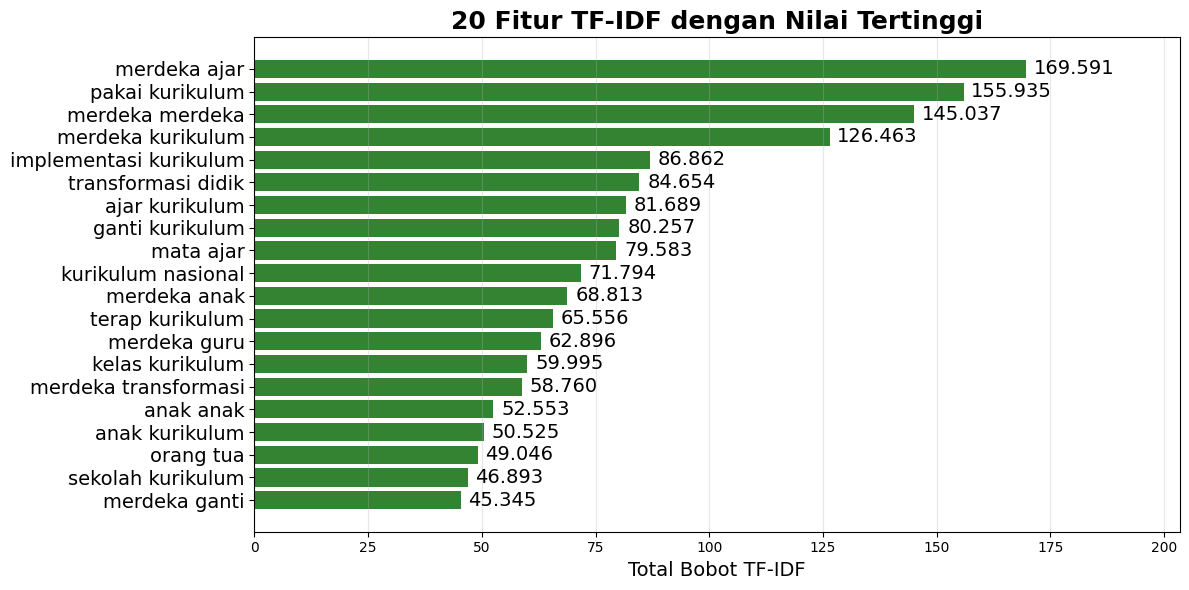

In [ ]:
plot_top_tfidf_features(top_20_bi)

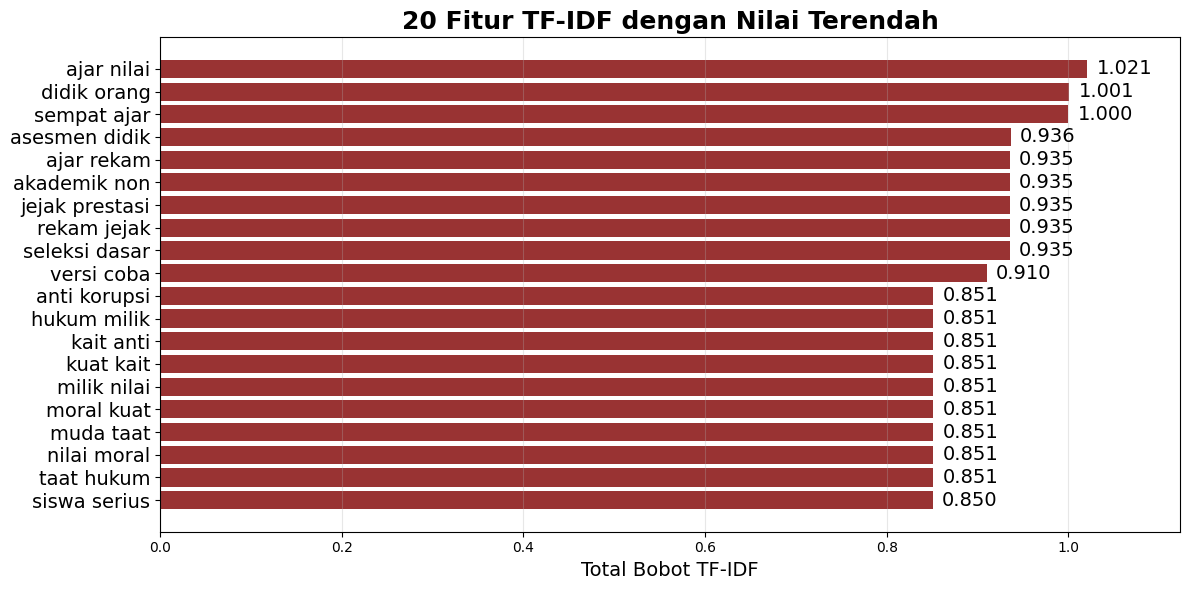

In [ ]:
plot_bottom_tfidf_features(bottom_20_bi)

### **12.1.3 Sentimen Positif**

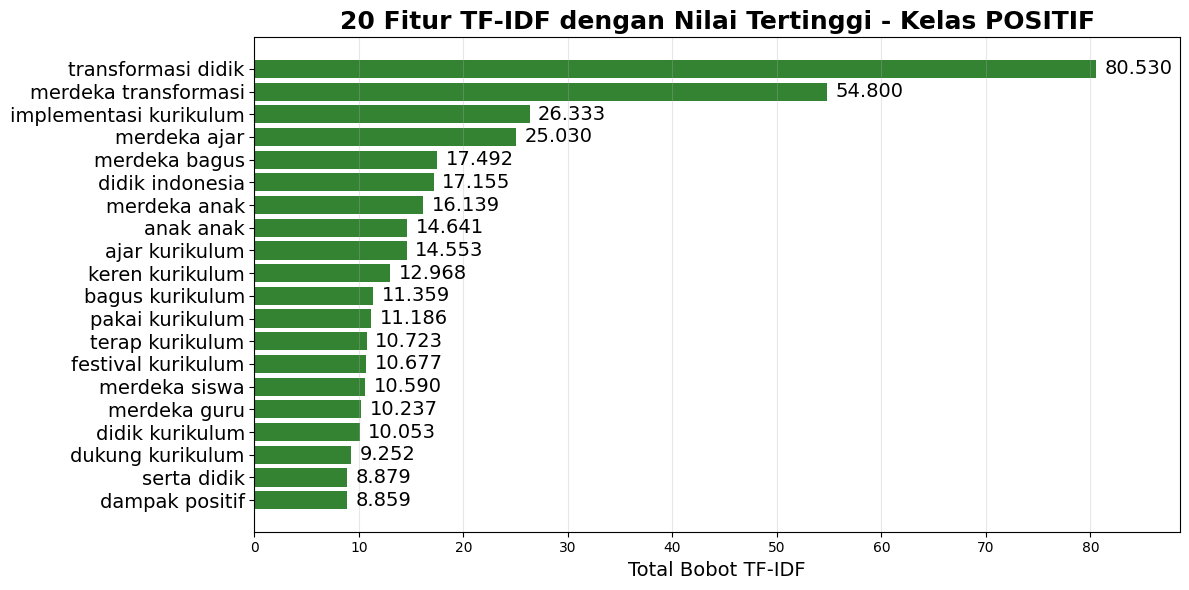

In [ ]:
viz_tfidf_positif(x_train, y_train_enc, vectorizer)

### **12.1.4 Sentimen Negatif**

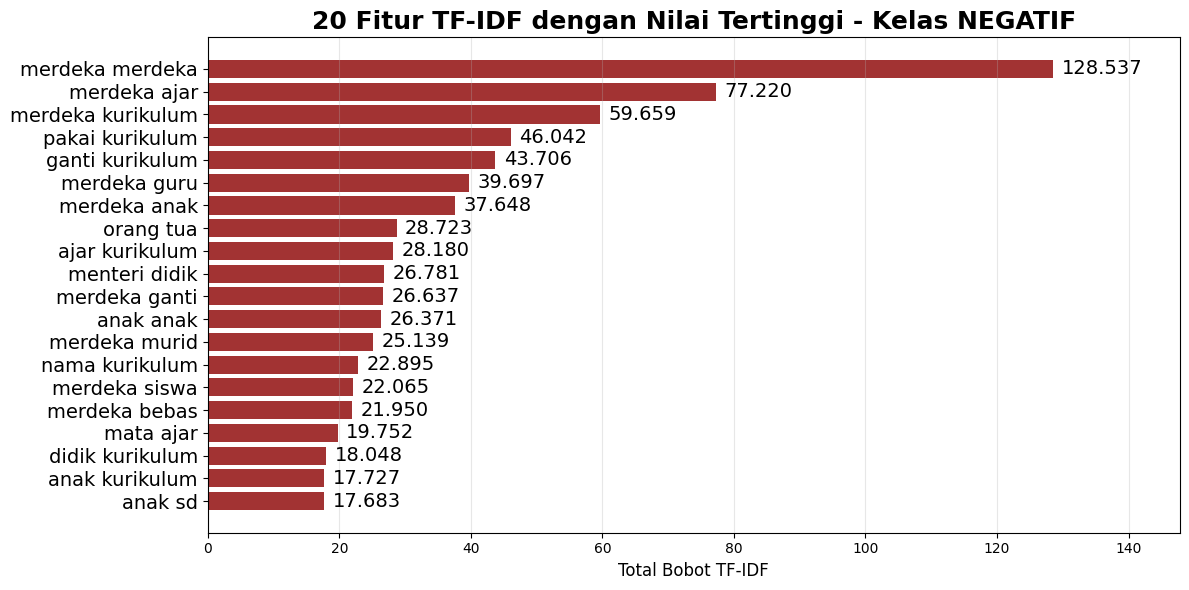

In [ ]:
viz_tfidf_negatif(x_train, y_train_enc, vectorizer)

### **12.1.5 Sentimen Netral**

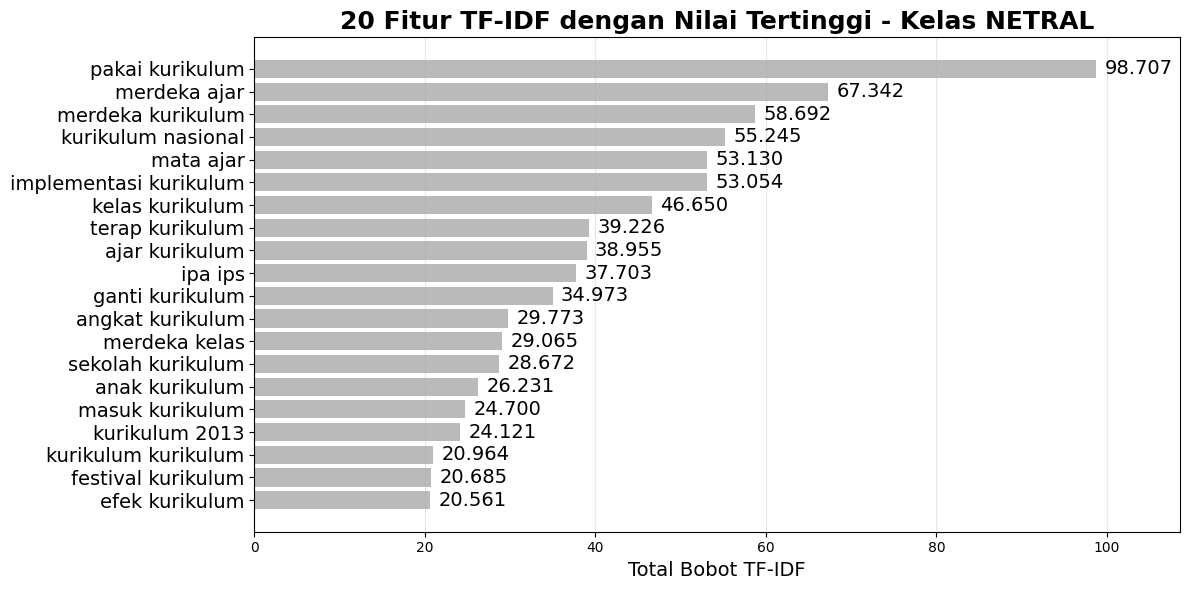

In [ ]:
viz_tfidf_netral(x_train, y_train_enc, vectorizer)

## **12.2 Word Cloud Visualization**

### **12.2.1 Main Code**

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

def create_wordcloud(text, colormap='viridis', background_color='white'):
    if not text or text.strip() == '':
        return None

    wordcloud = WordCloud(
        width=800,
        height=500,
        background_color=background_color,
        colormap=colormap,
        max_words=10000,
        relative_scaling=0.6,
        random_state=42,
        collocations=False,
        min_font_size=10
    ).generate(text)

    return wordcloud

def display_wordcloud(wordcloud, sentiment_name=""):
    plt.figure(figsize=(12, 8))

    if wordcloud is not None:
        plt.imshow(wordcloud, interpolation='bilinear')
    else:
        plt.text(0.5, 0.5, f'Tidak ada data untuk sentimen {sentiment_name}',
                ha='center', va='center', fontsize=16,
                transform=plt.gca().transAxes)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def print_top_words(text, sentiment_name, top_n=10):
    if not text or text.strip() == '':
        print(f"\nTidak ada data untuk sentimen {sentiment_name}")
        return

    words = text.split()
    word_freq = Counter(words)

    print(f"\n=== TOP {top_n} KATA PADA SENTIMEN {sentiment_name.upper()} ===")
    for i, (word, freq) in enumerate(word_freq.most_common(top_n), 1):
        print(f"{i:2d}. {word:<20} : {freq} kali")

# Pastikan data sudah dalam format yang benar
cleanData['stemming_text'] = cleanData['stemming_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Pisahkan teks berdasarkan sentimen
all_text = ' '.join(cleanData['stemming_text'].dropna())
positive_text = ' '.join(cleanData[cleanData['sentimen'] == 'positif']['stemming_text'].dropna())
negative_text = ' '.join(cleanData[cleanData['sentimen'] == 'negatif']['stemming_text'].dropna())
neutral_text = ' '.join(cleanData[cleanData['sentimen'] == 'netral']['stemming_text'].dropna())

### **12.2.2 Semua Sentimen**

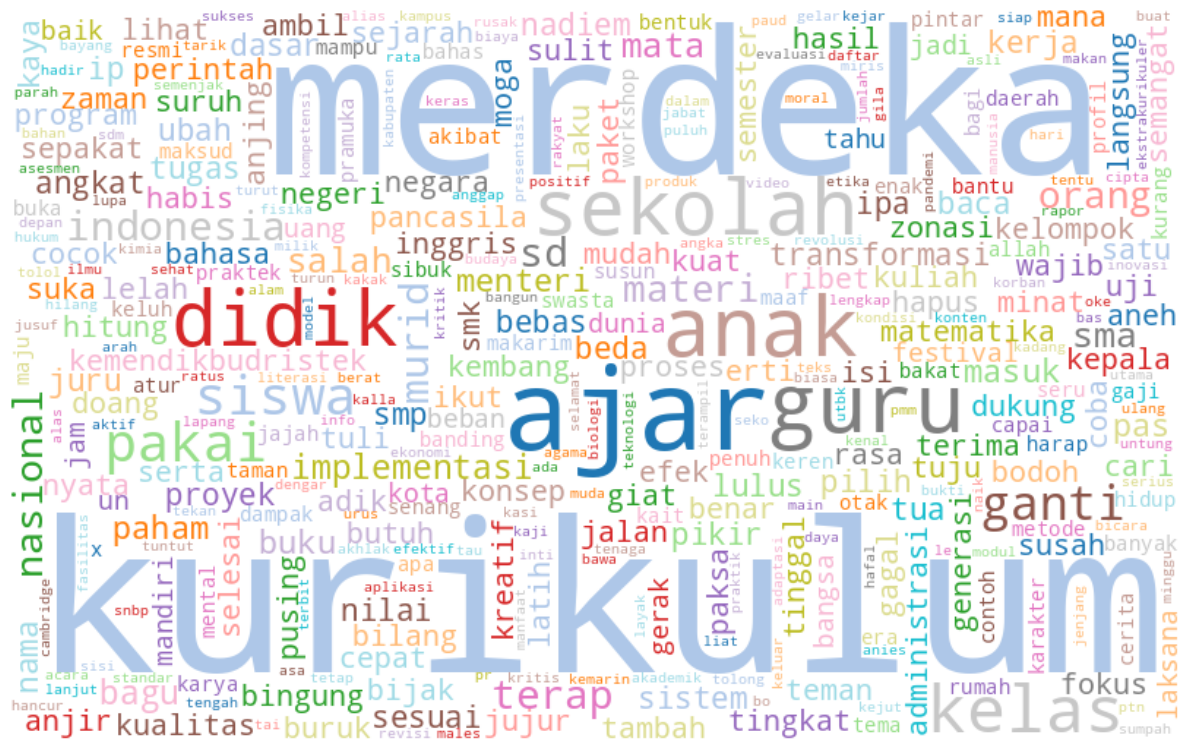

In [ ]:
# 1. Word Cloud untuk SEMUA SENTIMEN
wc_all = create_wordcloud(all_text, 'tab20')
display_wordcloud(wc_all, "semua")

### **12.2.3 Sentimen Positif**

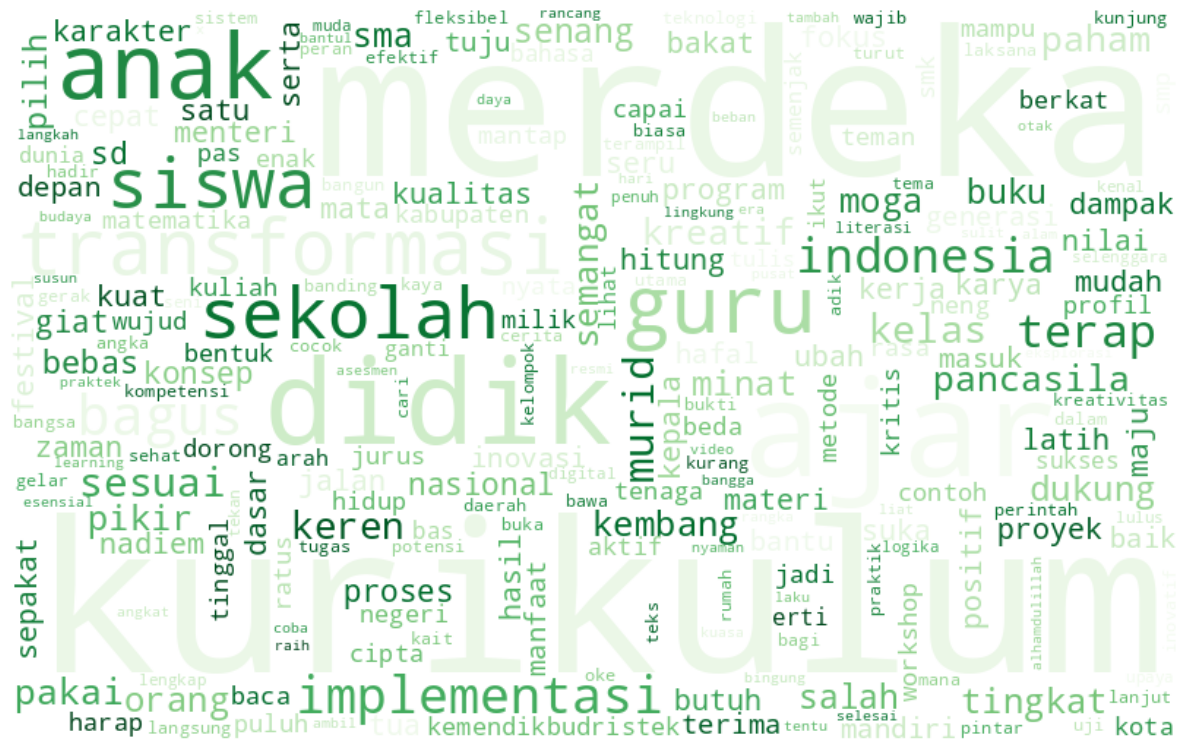

In [ ]:
# 2. Word Cloud untuk SENTIMEN POSITIF
wc_positive = create_wordcloud(positive_text, 'Greens')
display_wordcloud(wc_positive, "positif")

### **12.2.4 Sentimen Negatif**

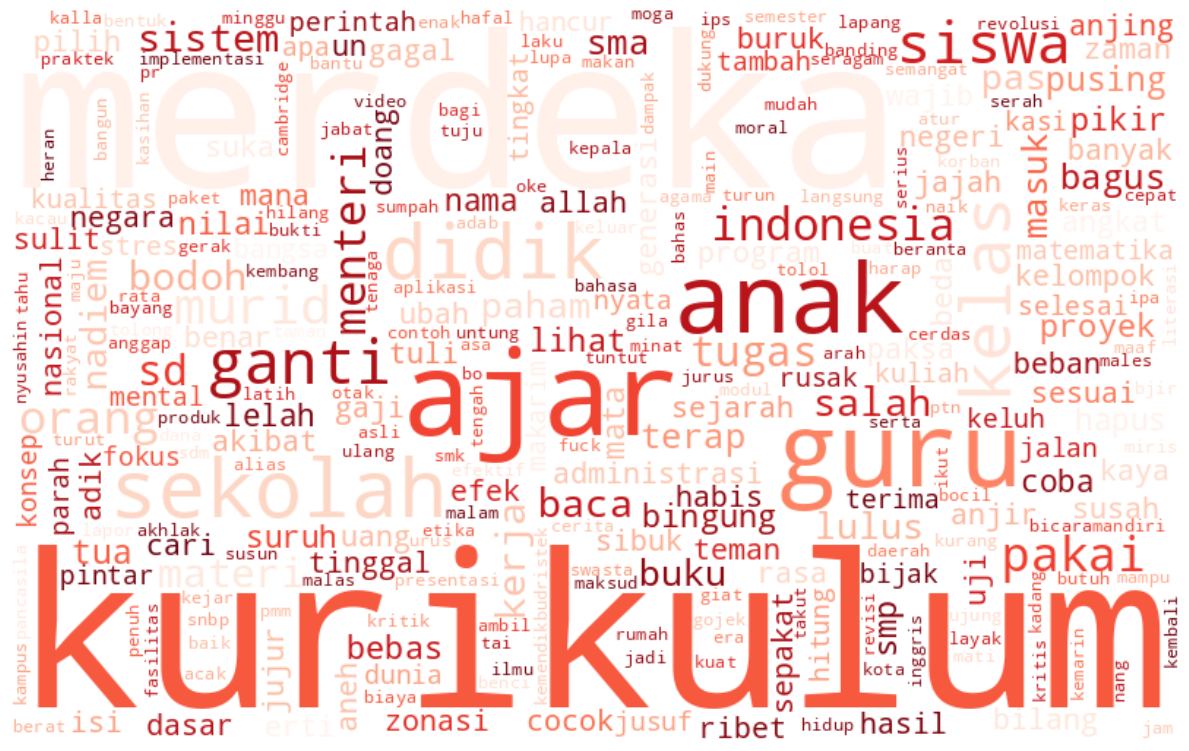

In [ ]:
# 3. Word Cloud untuk SENTIMEN NEGATIF
wc_negative = create_wordcloud(negative_text, 'Reds')
display_wordcloud(wc_negative, "negatif")

### **12.2.5 Sentimen Netral**

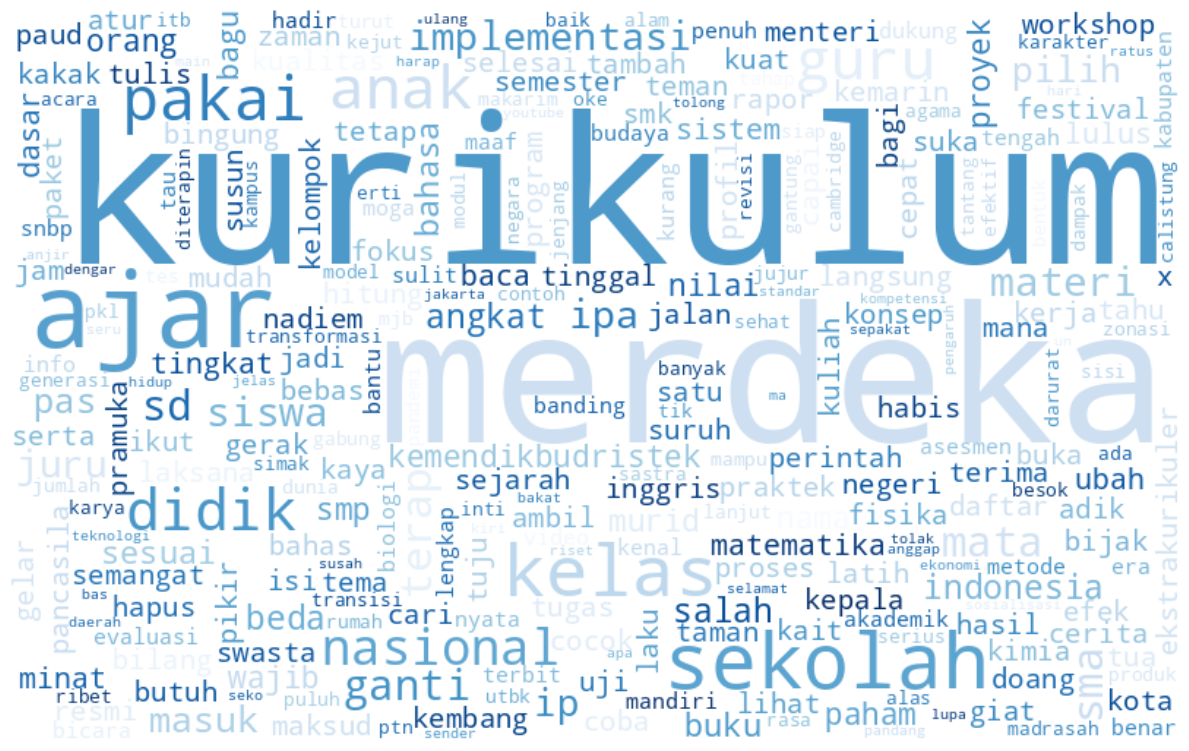

In [ ]:
# 4. Word Cloud untuk SENTIMEN NETRAL
wc_neutral = create_wordcloud(neutral_text, 'Blues')
display_wordcloud(wc_neutral, "netral")

## **12.3 Time Series Visualization**

### **12.3.1 Main Code**

In [ ]:
def create_sentiment_timeseries(df):
    # Convert date column to datetime if not already
    df['date'] = pd.to_datetime(df['date'])

    # Create year-month column for grouping
    df['year_month'] = df['date'].dt.to_period('M')

    # Count sentiments by month
    sentiment_counts = df.groupby(['year_month', 'sentimen']).size().unstack(fill_value=0)

    # Calculate total tweets per month
    sentiment_counts['Total'] = sentiment_counts.sum(axis=1)

    # Calculate percentages
    sentiment_percentages = sentiment_counts.div(sentiment_counts['Total'], axis=0) * 100

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(16, 10))

    # Plot sentiment lines
    months = range(len(sentiment_counts))
    month_labels = [str(period) for period in sentiment_counts.index]

    # Primary y-axis - Volume of tweets
    ax1.set_xlabel('Bulan', fontsize=16)
    ax1.set_ylabel('Volume Tweet (Jumlah)', fontsize=16, color='black')

    # Plot total volume as bar chart
    bars = ax1.bar(months, sentiment_counts['Total'], alpha=0.4, color='orange',
                   label='Total Volume')

    # Plot sentiment count lines (solid lines only)
    if 'negatif' in sentiment_counts.columns:
        line1 = ax1.plot(months, sentiment_counts['negatif'], 'o-', color='red',
                        linewidth=2, markersize=6, label='Negatif')

    if 'netral' in sentiment_counts.columns:
        line2 = ax1.plot(months, sentiment_counts['netral'], 'o-', color='blue',
                        linewidth=2, markersize=6, label='Netral')

    if 'positif' in sentiment_counts.columns:
        line3 = ax1.plot(months, sentiment_counts['positif'], 'o-', color='green',
                        linewidth=2, markersize=6, label='Positif')

    # Customize x-axis
    ax1.set_xticks(months)
    ax1.set_xticklabels(month_labels, rotation=45, ha='right')

    # Set fontsize for x-axis (bulan) and y-axis (volume) tick labels
    ax1.tick_params(axis='x', labelsize=14)  # Fontsize untuk nilai bulan
    ax1.tick_params(axis='y', labelsize=14)  # Fontsize untuk nilai volume

    # Add grid
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Add legend
    ax1.legend(loc='upper left', fontsize=16)

    # Set title
    plt.title('Tren Persepsi Masyarakat terhadap Implementasi Kurikulum Merdeka\n' +
              f'({df["date"].min().strftime("%B %Y")} - {df["date"].max().strftime("%B %Y")})',
              fontsize=18, fontweight='bold', pad=15)

    # Adjust layout
    plt.tight_layout()

    return fig, sentiment_counts, sentiment_percentages

def create_detailed_sentiment_analysis(df):
    # Basic statistics
    total_tweets = len(df)
    sentiment_distribution = df['sentimen'].value_counts()
    sentiment_percentage = df['sentimen'].value_counts(normalize=True) * 100

    print("=== STATISTIK SENTIMEN ===")
    print(f"Total Tweet: {total_tweets:,}")
    print("\nDistribusi Sentimen:")
    for sentiment in sentiment_distribution.index:
        count = sentiment_distribution[sentiment]
        pct = sentiment_percentage[sentiment]
        print(f"  {sentiment.capitalize()}: {count:,} tweet ({pct:.1f}%)")

    # Monthly trend analysis
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')

    monthly_sentiment = df.groupby(['year_month', 'sentimen']).size().unstack(fill_value=0)
    monthly_total = monthly_sentiment.sum(axis=1)

    print(f"\n=== VOLUME TWEET BULANAN ===")
    print(f"Rata-rata volume tweet per bulan: {monthly_total.mean():.0f}")
    print("Bulan dengan volume tweet tertinggi:")
    top_month = monthly_total.idxmax()
    print(f"  {top_month}: {monthly_total[top_month]:,} tweet")

    print("Bulan dengan volume tweet terendah:")
    low_month = monthly_total.idxmin()
    print(f"  {low_month}: {monthly_total[low_month]:,} tweet")

    print(f"\nVariasi volume:")
    print(f"  Standar deviasi: {monthly_total.std():.0f}")
    print(f"  Range: {monthly_total.max() - monthly_total.min():,} tweet")

    return monthly_sentiment

def create_pie_chart(df):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Get sentiment counts
    sentiment_counts = df['sentimen'].value_counts()
    colors = {'positif': '#2ecc71', 'netral': '#3498db', 'negatif': '#e74c3c'}
    pie_colors = [colors.get(sentiment, '#95a5a6') for sentiment in sentiment_counts.index]

    # Create custom labels with percentage and count
    def autopct_format(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return f'{pct:.1f}%\n({absolute:,})'

    # Create pie chart
    wedges, texts, autotexts = ax.pie(sentiment_counts.values,
                                     labels=sentiment_counts.index,
                                     autopct=lambda pct: autopct_format(pct, sentiment_counts.values),
                                     colors=pie_colors,
                                     startangle=90,
                                     textprops={'fontsize': 14})

    # Enhance text formatting
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    ax.set_title('Distribusi Sentimen Publik terhadap Kurikulum Merdeka', fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    return fig

def create_bar_chart(df):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Prepare data
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')
    monthly_sentiment = df.groupby(['year_month', 'sentimen']).size().unstack(fill_value=0)

    # Define colors
    colors = {'positif': '#2ecc71', 'netral': '#3498db', 'negatif': '#e74c3c'}
    bar_colors = [colors.get(col, '#95a5a6') for col in monthly_sentiment.columns]

    # Create bar chart
    bars = monthly_sentiment.plot(kind='bar', ax=ax, color=bar_colors, width=0.8)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%g', padding=3, fontsize=9, fontweight='bold', rotation=90)

    ax.set_title('Tren Persepsi Masyarakat terhadap Implementasi Kurikulum Merdeka', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Bulan', fontsize=12)
    ax.set_ylabel('Jumlah Tweet', fontsize=12)
    ax.legend(title='Sentimen', title_fontsize=12, fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

    # Add some space at the top for labels
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max * 1.1)

    plt.tight_layout()
    return fig

### **12.3.2 Time Series Visualization**

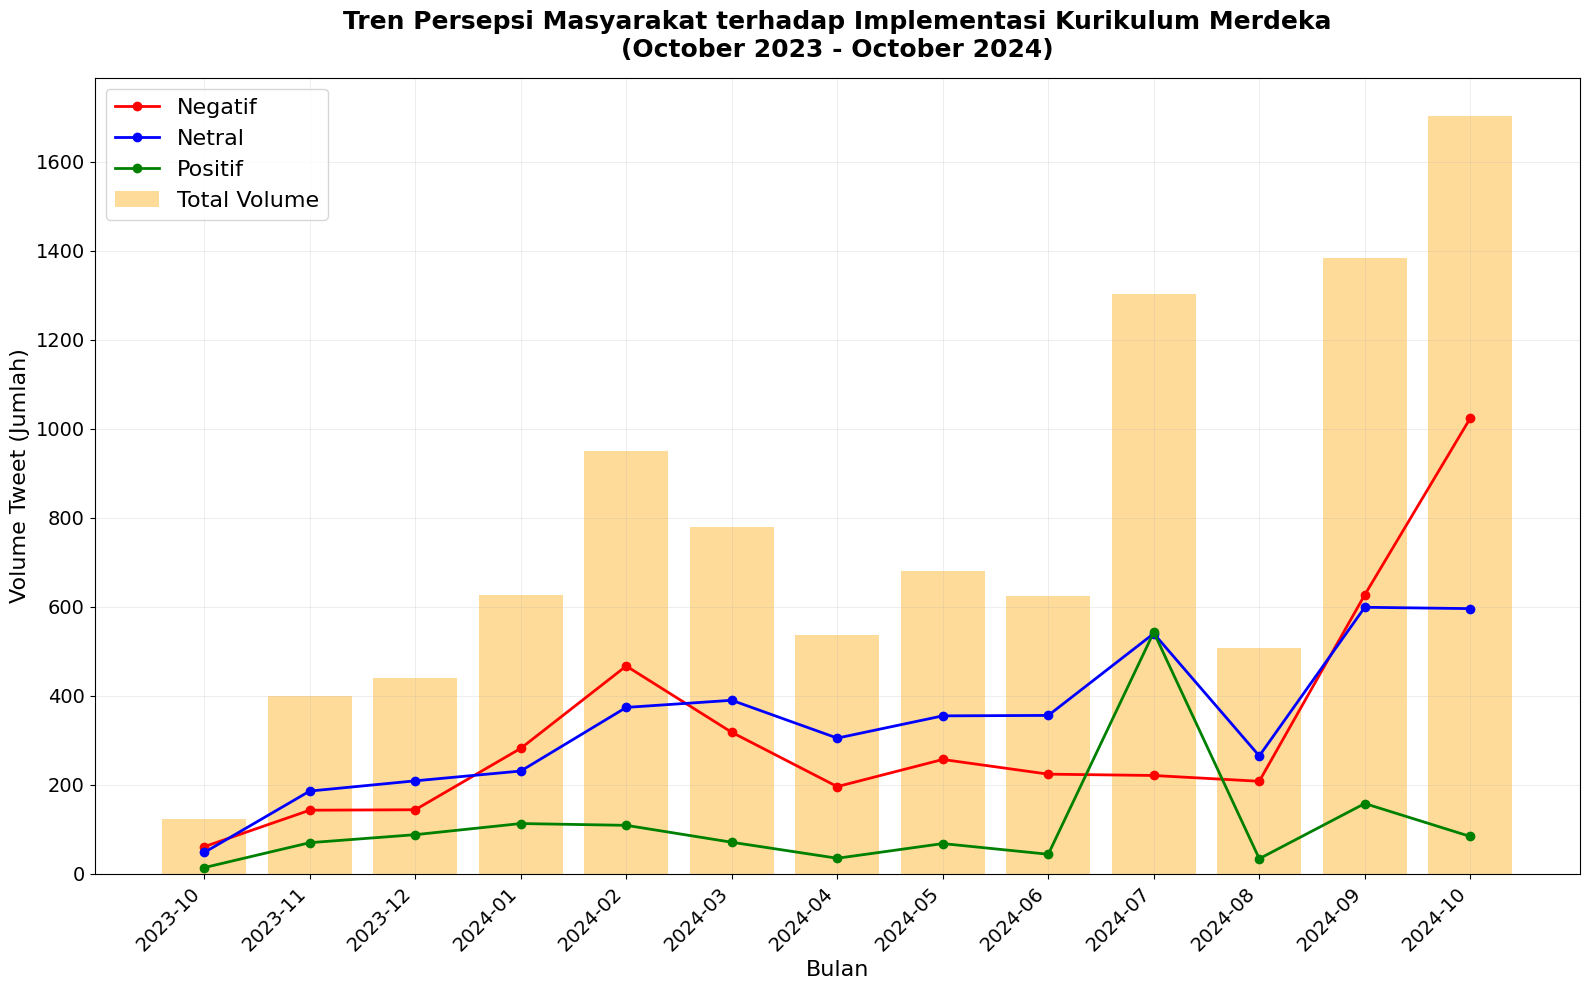

In [ ]:
fig1, counts, percentages = create_sentiment_timeseries(cleanData)
plt.show()

In [ ]:
# Create detailed analysis
monthly_data = create_detailed_sentiment_analysis(cleanData)

=== STATISTIK SENTIMEN ===
Total Tweet: 10,057

Distribusi Sentimen:
  Netral: 4,454 tweet (44.3%)
  Negatif: 4,172 tweet (41.5%)
  Positif: 1,431 tweet (14.2%)

=== VOLUME TWEET BULANAN ===
Rata-rata volume tweet per bulan: 774
Bulan dengan volume tweet tertinggi:
  2024-10: 1,704 tweet
Bulan dengan volume tweet terendah:
  2023-10: 123 tweet

Variasi volume:
  Standar deviasi: 448
  Range: 1,581 tweet


### **12.3.4 Visualisasi Distribusi Sentimen**

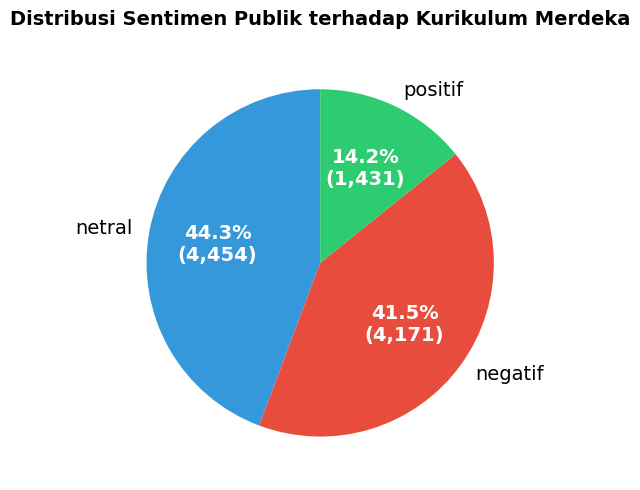

In [ ]:
# Pie chart terpisah
pie_fig = create_pie_chart(cleanData)
plt.show()

### **12.3.5 Visualisasi Trend Sentimen Bulanan**

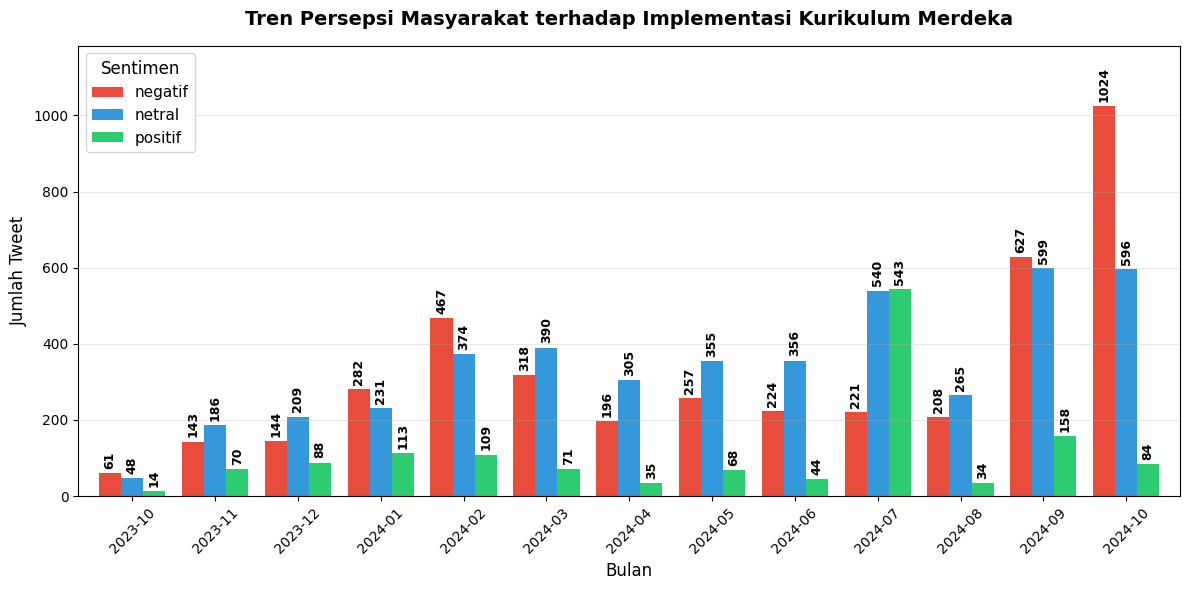

In [ ]:
bar_fig = create_bar_chart(cleanData)
plt.show()